In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 920)
(4629816, 8)
validation
(621056, 920)
(621056, 8)
test
(624904, 920)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1633160 (6.23 MB)


Trainable params: 1633160 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 13:10 - loss: 2.4075 - STD: 0.1022 - MAE: 0.2203

  4/463 [..............................] - ETA: 11s - loss: 2.1779 - STD: 0.0554 - MAE: 0.2183  

  7/463 [..............................] - ETA: 11s - loss: 2.1384 - STD: 0.0568 - MAE: 0.2170

 10/463 [..............................] - ETA: 10s - loss: 2.1258 - STD: 0.0569 - MAE: 0.2166

 12/463 [..............................] - ETA: 11s - loss: 2.1161 - STD: 0.0550 - MAE: 0.2165

 15/463 [..............................] - ETA: 10s - loss: 2.1041 - STD: 0.0514 - MAE: 0.2165

 18/463 [>.............................] - ETA: 10s - loss: 2.0960 - STD: 0.0478 - MAE: 0.2166

 21/463 [>.............................] - ETA: 10s - loss: 2.0905 - STD: 0.0449 - MAE: 0.2167

 24/463 [>.............................] - ETA: 10s - loss: 2.0857 - STD: 0.0427 - MAE: 0.2167

 27/463 [>.............................] - ETA: 10s - loss: 2.0808 - STD: 0.0412 - MAE: 0.2167

 30/463 [>.............................] - ETA: 10s - loss: 2.0763 - STD: 0.0407 - MAE: 0.2166

 33/463 [=>............................] - ETA: 10s - loss: 2.0719 - STD: 0.0404 - MAE: 0.2165

 36/463 [=>............................] - ETA: 10s - loss: 2.0664 - STD: 0.0402 - MAE: 0.2164

 39/463 [=>............................] - ETA: 10s - loss: 2.0595 - STD: 0.0402 - MAE: 0.2162

 42/463 [=>............................] - ETA: 10s - loss: 2.0513 - STD: 0.0405 - MAE: 0.2159

 45/463 [=>............................] - ETA: 10s - loss: 2.0421 - STD: 0.0415 - MAE: 0.2155

 48/463 [==>...........................] - ETA: 10s - loss: 2.0322 - STD: 0.0428 - MAE: 0.2151

 51/463 [==>...........................] - ETA: 9s - loss: 2.0222 - STD: 0.0446 - MAE: 0.2146 

 54/463 [==>...........................] - ETA: 9s - loss: 2.0122 - STD: 0.0464 - MAE: 0.2141

 57/463 [==>...........................] - ETA: 9s - loss: 2.0021 - STD: 0.0483 - MAE: 0.2136

 60/463 [==>...........................] - ETA: 9s - loss: 1.9925 - STD: 0.0500 - MAE: 0.2132

 63/463 [===>..........................] - ETA: 9s - loss: 1.9828 - STD: 0.0515 - MAE: 0.2127

 66/463 [===>..........................] - ETA: 9s - loss: 1.9732 - STD: 0.0531 - MAE: 0.2122

 69/463 [===>..........................] - ETA: 9s - loss: 1.9636 - STD: 0.0546 - MAE: 0.2118

 72/463 [===>..........................] - ETA: 9s - loss: 1.9539 - STD: 0.0561 - MAE: 0.2113

 74/463 [===>..........................] - ETA: 9s - loss: 1.9474 - STD: 0.0570 - MAE: 0.2110

 77/463 [===>..........................] - ETA: 9s - loss: 1.9375 - STD: 0.0585 - MAE: 0.2105

 80/463 [====>.........................] - ETA: 9s - loss: 1.9277 - STD: 0.0599 - MAE: 0.2101

 83/463 [====>.........................] - ETA: 9s - loss: 1.9173 - STD: 0.0612 - MAE: 0.2096

 86/463 [====>.........................] - ETA: 9s - loss: 1.9074 - STD: 0.0626 - MAE: 0.2091

 89/463 [====>.........................] - ETA: 9s - loss: 1.8977 - STD: 0.0640 - MAE: 0.2086

 92/463 [====>.........................] - ETA: 8s - loss: 1.8884 - STD: 0.0653 - MAE: 0.2081

 95/463 [=====>........................] - ETA: 8s - loss: 1.8793 - STD: 0.0667 - MAE: 0.2076

 97/463 [=====>........................] - ETA: 8s - loss: 1.8734 - STD: 0.0676 - MAE: 0.2073

100/463 [=====>........................] - ETA: 8s - loss: 1.8644 - STD: 0.0690 - MAE: 0.2068

103/463 [=====>........................] - ETA: 8s - loss: 1.8558 - STD: 0.0703 - MAE: 0.2063

106/463 [=====>........................] - ETA: 8s - loss: 1.8473 - STD: 0.0715 - MAE: 0.2059

109/463 [======>.......................] - ETA: 8s - loss: 1.8392 - STD: 0.0728 - MAE: 0.2054

111/463 [======>.......................] - ETA: 8s - loss: 1.8337 - STD: 0.0736 - MAE: 0.2051

114/463 [======>.......................] - ETA: 8s - loss: 1.8256 - STD: 0.0748 - MAE: 0.2046

117/463 [======>.......................] - ETA: 8s - loss: 1.8176 - STD: 0.0761 - MAE: 0.2041

120/463 [======>.......................] - ETA: 8s - loss: 1.8098 - STD: 0.0773 - MAE: 0.2036

122/463 [======>.......................] - ETA: 8s - loss: 1.8046 - STD: 0.0781 - MAE: 0.2033

125/463 [=======>......................] - ETA: 8s - loss: 1.7969 - STD: 0.0793 - MAE: 0.2028

128/463 [=======>......................] - ETA: 8s - loss: 1.7891 - STD: 0.0805 - MAE: 0.2023

131/463 [=======>......................] - ETA: 7s - loss: 1.7815 - STD: 0.0817 - MAE: 0.2018

134/463 [=======>......................] - ETA: 7s - loss: 1.7736 - STD: 0.0828 - MAE: 0.2013

137/463 [=======>......................] - ETA: 7s - loss: 1.7656 - STD: 0.0840 - MAE: 0.2008

140/463 [========>.....................] - ETA: 7s - loss: 1.7576 - STD: 0.0852 - MAE: 0.2002

143/463 [========>.....................] - ETA: 7s - loss: 1.7497 - STD: 0.0864 - MAE: 0.1997

146/463 [========>.....................] - ETA: 7s - loss: 1.7417 - STD: 0.0876 - MAE: 0.1991

149/463 [========>.....................] - ETA: 7s - loss: 1.7339 - STD: 0.0888 - MAE: 0.1986

152/463 [========>.....................] - ETA: 7s - loss: 1.7262 - STD: 0.0900 - MAE: 0.1980

155/463 [=========>....................] - ETA: 7s - loss: 1.7184 - STD: 0.0912 - MAE: 0.1974

158/463 [=========>....................] - ETA: 7s - loss: 1.7109 - STD: 0.0924 - MAE: 0.1969

160/463 [=========>....................] - ETA: 7s - loss: 1.7060 - STD: 0.0932 - MAE: 0.1965

163/463 [=========>....................] - ETA: 7s - loss: 1.6986 - STD: 0.0944 - MAE: 0.1960

166/463 [=========>....................] - ETA: 7s - loss: 1.6913 - STD: 0.0955 - MAE: 0.1954

169/463 [=========>....................] - ETA: 7s - loss: 1.6841 - STD: 0.0967 - MAE: 0.1948

172/463 [==========>...................] - ETA: 7s - loss: 1.6771 - STD: 0.0978 - MAE: 0.1943

175/463 [==========>...................] - ETA: 6s - loss: 1.6701 - STD: 0.0990 - MAE: 0.1937

178/463 [==========>...................] - ETA: 6s - loss: 1.6633 - STD: 0.1001 - MAE: 0.1932

181/463 [==========>...................] - ETA: 6s - loss: 1.6566 - STD: 0.1011 - MAE: 0.1927

184/463 [==========>...................] - ETA: 6s - loss: 1.6499 - STD: 0.1022 - MAE: 0.1922

187/463 [===========>..................] - ETA: 6s - loss: 1.6436 - STD: 0.1032 - MAE: 0.1917

190/463 [===========>..................] - ETA: 6s - loss: 1.6374 - STD: 0.1042 - MAE: 0.1912

193/463 [===========>..................] - ETA: 6s - loss: 1.6314 - STD: 0.1052 - MAE: 0.1907

196/463 [===========>..................] - ETA: 6s - loss: 1.6255 - STD: 0.1062 - MAE: 0.1902

198/463 [===========>..................] - ETA: 6s - loss: 1.6216 - STD: 0.1068 - MAE: 0.1899

201/463 [============>.................] - ETA: 6s - loss: 1.6159 - STD: 0.1077 - MAE: 0.1894

204/463 [============>.................] - ETA: 6s - loss: 1.6103 - STD: 0.1086 - MAE: 0.1890

207/463 [============>.................] - ETA: 6s - loss: 1.6046 - STD: 0.1095 - MAE: 0.1885

210/463 [============>.................] - ETA: 6s - loss: 1.5992 - STD: 0.1104 - MAE: 0.1880

213/463 [============>.................] - ETA: 6s - loss: 1.5938 - STD: 0.1113 - MAE: 0.1876

216/463 [============>.................] - ETA: 5s - loss: 1.5885 - STD: 0.1122 - MAE: 0.1872

219/463 [=============>................] - ETA: 5s - loss: 1.5836 - STD: 0.1130 - MAE: 0.1868

222/463 [=============>................] - ETA: 5s - loss: 1.5788 - STD: 0.1138 - MAE: 0.1863

224/463 [=============>................] - ETA: 5s - loss: 1.5756 - STD: 0.1143 - MAE: 0.1861

227/463 [=============>................] - ETA: 5s - loss: 1.5708 - STD: 0.1151 - MAE: 0.1857

230/463 [=============>................] - ETA: 5s - loss: 1.5660 - STD: 0.1159 - MAE: 0.1853

233/463 [==============>...............] - ETA: 5s - loss: 1.5614 - STD: 0.1167 - MAE: 0.1849

235/463 [==============>...............] - ETA: 5s - loss: 1.5583 - STD: 0.1172 - MAE: 0.1846

238/463 [==============>...............] - ETA: 5s - loss: 1.5538 - STD: 0.1179 - MAE: 0.1843

241/463 [==============>...............] - ETA: 5s - loss: 1.5491 - STD: 0.1186 - MAE: 0.1839

244/463 [==============>...............] - ETA: 5s - loss: 1.5446 - STD: 0.1193 - MAE: 0.1835

246/463 [==============>...............] - ETA: 5s - loss: 1.5418 - STD: 0.1198 - MAE: 0.1833

249/463 [===============>..............] - ETA: 5s - loss: 1.5375 - STD: 0.1205 - MAE: 0.1829

252/463 [===============>..............] - ETA: 5s - loss: 1.5331 - STD: 0.1212 - MAE: 0.1825

255/463 [===============>..............] - ETA: 5s - loss: 1.5290 - STD: 0.1218 - MAE: 0.1822

257/463 [===============>..............] - ETA: 4s - loss: 1.5262 - STD: 0.1223 - MAE: 0.1819

260/463 [===============>..............] - ETA: 4s - loss: 1.5222 - STD: 0.1229 - MAE: 0.1816

263/463 [================>.............] - ETA: 4s - loss: 1.5181 - STD: 0.1235 - MAE: 0.1813

266/463 [================>.............] - ETA: 4s - loss: 1.5142 - STD: 0.1242 - MAE: 0.1809

268/463 [================>.............] - ETA: 4s - loss: 1.5116 - STD: 0.1246 - MAE: 0.1807

271/463 [================>.............] - ETA: 4s - loss: 1.5081 - STD: 0.1252 - MAE: 0.1804

274/463 [================>.............] - ETA: 4s - loss: 1.5043 - STD: 0.1258 - MAE: 0.1801

277/463 [================>.............] - ETA: 4s - loss: 1.5006 - STD: 0.1264 - MAE: 0.1798

279/463 [=================>............] - ETA: 4s - loss: 1.4982 - STD: 0.1268 - MAE: 0.1795

281/463 [=================>............] - ETA: 4s - loss: 1.4958 - STD: 0.1272 - MAE: 0.1793

284/463 [=================>............] - ETA: 4s - loss: 1.4922 - STD: 0.1277 - MAE: 0.1790

287/463 [=================>............] - ETA: 4s - loss: 1.4886 - STD: 0.1283 - MAE: 0.1787

290/463 [=================>............] - ETA: 4s - loss: 1.4851 - STD: 0.1289 - MAE: 0.1784

292/463 [=================>............] - ETA: 4s - loss: 1.4829 - STD: 0.1293 - MAE: 0.1782

295/463 [==================>...........] - ETA: 4s - loss: 1.4795 - STD: 0.1298 - MAE: 0.1779

298/463 [==================>...........] - ETA: 3s - loss: 1.4763 - STD: 0.1303 - MAE: 0.1776

301/463 [==================>...........] - ETA: 3s - loss: 1.4730 - STD: 0.1309 - MAE: 0.1773

304/463 [==================>...........] - ETA: 3s - loss: 1.4697 - STD: 0.1314 - MAE: 0.1771

307/463 [==================>...........] - ETA: 3s - loss: 1.4666 - STD: 0.1319 - MAE: 0.1768

310/463 [===================>..........] - ETA: 3s - loss: 1.4636 - STD: 0.1324 - MAE: 0.1765

313/463 [===================>..........] - ETA: 3s - loss: 1.4605 - STD: 0.1329 - MAE: 0.1762

316/463 [===================>..........] - ETA: 3s - loss: 1.4574 - STD: 0.1334 - MAE: 0.1760

319/463 [===================>..........] - ETA: 3s - loss: 1.4546 - STD: 0.1339 - MAE: 0.1757

322/463 [===================>..........] - ETA: 3s - loss: 1.4517 - STD: 0.1344 - MAE: 0.1755

325/463 [====================>.........] - ETA: 3s - loss: 1.4488 - STD: 0.1348 - MAE: 0.1752

328/463 [====================>.........] - ETA: 3s - loss: 1.4459 - STD: 0.1353 - MAE: 0.1749

331/463 [====================>.........] - ETA: 3s - loss: 1.4431 - STD: 0.1358 - MAE: 0.1747

334/463 [====================>.........] - ETA: 3s - loss: 1.4406 - STD: 0.1362 - MAE: 0.1744

337/463 [====================>.........] - ETA: 3s - loss: 1.4380 - STD: 0.1367 - MAE: 0.1742

340/463 [=====================>........] - ETA: 2s - loss: 1.4354 - STD: 0.1371 - MAE: 0.1740

342/463 [=====================>........] - ETA: 2s - loss: 1.4336 - STD: 0.1374 - MAE: 0.1738

345/463 [=====================>........] - ETA: 2s - loss: 1.4311 - STD: 0.1378 - MAE: 0.1736

348/463 [=====================>........] - ETA: 2s - loss: 1.4284 - STD: 0.1382 - MAE: 0.1733

351/463 [=====================>........] - ETA: 2s - loss: 1.4257 - STD: 0.1387 - MAE: 0.1731

354/463 [=====================>........] - ETA: 2s - loss: 1.4232 - STD: 0.1391 - MAE: 0.1729

356/463 [======================>.......] - ETA: 2s - loss: 1.4215 - STD: 0.1394 - MAE: 0.1727

359/463 [======================>.......] - ETA: 2s - loss: 1.4189 - STD: 0.1398 - MAE: 0.1725

362/463 [======================>.......] - ETA: 2s - loss: 1.4164 - STD: 0.1402 - MAE: 0.1722

365/463 [======================>.......] - ETA: 2s - loss: 1.4139 - STD: 0.1406 - MAE: 0.1720

368/463 [======================>.......] - ETA: 2s - loss: 1.4114 - STD: 0.1410 - MAE: 0.1718

371/463 [=======================>......] - ETA: 2s - loss: 1.4089 - STD: 0.1414 - MAE: 0.1716

374/463 [=======================>......] - ETA: 2s - loss: 1.4065 - STD: 0.1418 - MAE: 0.1714

377/463 [=======================>......] - ETA: 2s - loss: 1.4041 - STD: 0.1422 - MAE: 0.1711

380/463 [=======================>......] - ETA: 1s - loss: 1.4017 - STD: 0.1425 - MAE: 0.1709

383/463 [=======================>......] - ETA: 1s - loss: 1.3993 - STD: 0.1429 - MAE: 0.1707

386/463 [========================>.....] - ETA: 1s - loss: 1.3969 - STD: 0.1433 - MAE: 0.1705

389/463 [========================>.....] - ETA: 1s - loss: 1.3945 - STD: 0.1437 - MAE: 0.1703

391/463 [========================>.....] - ETA: 1s - loss: 1.3930 - STD: 0.1439 - MAE: 0.1701

394/463 [========================>.....] - ETA: 1s - loss: 1.3907 - STD: 0.1443 - MAE: 0.1699

397/463 [========================>.....] - ETA: 1s - loss: 1.3885 - STD: 0.1446 - MAE: 0.1697

400/463 [========================>.....] - ETA: 1s - loss: 1.3863 - STD: 0.1450 - MAE: 0.1695

403/463 [=========================>....] - ETA: 1s - loss: 1.3841 - STD: 0.1454 - MAE: 0.1693

406/463 [=========================>....] - ETA: 1s - loss: 1.3819 - STD: 0.1457 - MAE: 0.1691

409/463 [=========================>....] - ETA: 1s - loss: 1.3797 - STD: 0.1461 - MAE: 0.1689

412/463 [=========================>....] - ETA: 1s - loss: 1.3777 - STD: 0.1464 - MAE: 0.1687

415/463 [=========================>....] - ETA: 1s - loss: 1.3755 - STD: 0.1467 - MAE: 0.1685

417/463 [==========================>...] - ETA: 1s - loss: 1.3740 - STD: 0.1470 - MAE: 0.1684

418/463 [==========================>...] - ETA: 1s - loss: 1.3733 - STD: 0.1471 - MAE: 0.1683

421/463 [==========================>...] - ETA: 1s - loss: 1.3714 - STD: 0.1474 - MAE: 0.1681

424/463 [==========================>...] - ETA: 1s - loss: 1.3693 - STD: 0.1478 - MAE: 0.1679

427/463 [==========================>...] - ETA: 0s - loss: 1.3673 - STD: 0.1481 - MAE: 0.1677

429/463 [==========================>...] - ETA: 0s - loss: 1.3661 - STD: 0.1483 - MAE: 0.1676

432/463 [==========================>...] - ETA: 0s - loss: 1.3642 - STD: 0.1486 - MAE: 0.1674

435/463 [===========================>..] - ETA: 0s - loss: 1.3622 - STD: 0.1489 - MAE: 0.1672

438/463 [===========================>..] - ETA: 0s - loss: 1.3603 - STD: 0.1493 - MAE: 0.1671

441/463 [===========================>..] - ETA: 0s - loss: 1.3584 - STD: 0.1496 - MAE: 0.1669

443/463 [===========================>..] - ETA: 0s - loss: 1.3573 - STD: 0.1498 - MAE: 0.1668

446/463 [===========================>..] - ETA: 0s - loss: 1.3554 - STD: 0.1501 - MAE: 0.1666

449/463 [============================>.] - ETA: 0s - loss: 1.3535 - STD: 0.1504 - MAE: 0.1664

452/463 [============================>.] - ETA: 0s - loss: 1.3516 - STD: 0.1507 - MAE: 0.1662

454/463 [============================>.] - ETA: 0s - loss: 1.3504 - STD: 0.1509 - MAE: 0.1661

457/463 [============================>.] - ETA: 0s - loss: 1.3486 - STD: 0.1512 - MAE: 0.1660

460/463 [============================>.] - ETA: 0s - loss: 1.3468 - STD: 0.1515 - MAE: 0.1658

463/463 [==============================] - ETA: 0s - loss: 1.3450 - STD: 0.1518 - MAE: 0.1656

463/463 [==============================] - 16s 30ms/step - loss: 1.3450 - STD: 0.1518 - MAE: 0.1656 - val_loss: 1.2539 - val_STD: 0.1951 - val_MAE: 0.1488


Epoch 2/10000


  1/463 [..............................] - ETA: 25s - loss: 1.0542 - STD: 0.1962 - MAE: 0.1388

  4/463 [..............................] - ETA: 10s - loss: 1.0619 - STD: 0.1960 - MAE: 0.1392

  7/463 [..............................] - ETA: 11s - loss: 1.0672 - STD: 0.1965 - MAE: 0.1394

 10/463 [..............................] - ETA: 11s - loss: 1.0684 - STD: 0.1966 - MAE: 0.1394

 13/463 [..............................] - ETA: 10s - loss: 1.0698 - STD: 0.1966 - MAE: 0.1395

 16/463 [>.............................] - ETA: 10s - loss: 1.0680 - STD: 0.1968 - MAE: 0.1393

 19/463 [>.............................] - ETA: 10s - loss: 1.0677 - STD: 0.1967 - MAE: 0.1393

 22/463 [>.............................] - ETA: 10s - loss: 1.0664 - STD: 0.1968 - MAE: 0.1392

 25/463 [>.............................] - ETA: 10s - loss: 1.0654 - STD: 0.1969 - MAE: 0.1391

 28/463 [>.............................] - ETA: 10s - loss: 1.0655 - STD: 0.1971 - MAE: 0.1390

 31/463 [=>............................] - ETA: 10s - loss: 1.0648 - STD: 0.1972 - MAE: 0.1390

 34/463 [=>............................] - ETA: 10s - loss: 1.0647 - STD: 0.1972 - MAE: 0.1389

 37/463 [=>............................] - ETA: 10s - loss: 1.0635 - STD: 0.1973 - MAE: 0.1388

 40/463 [=>............................] - ETA: 10s - loss: 1.0631 - STD: 0.1973 - MAE: 0.1388

 43/463 [=>............................] - ETA: 10s - loss: 1.0622 - STD: 0.1974 - MAE: 0.1387

 46/463 [=>............................] - ETA: 10s - loss: 1.0615 - STD: 0.1975 - MAE: 0.1386

 49/463 [==>...........................] - ETA: 9s - loss: 1.0610 - STD: 0.1976 - MAE: 0.1386 

 52/463 [==>...........................] - ETA: 9s - loss: 1.0626 - STD: 0.1976 - MAE: 0.1386

 55/463 [==>...........................] - ETA: 9s - loss: 1.0624 - STD: 0.1978 - MAE: 0.1386

 57/463 [==>...........................] - ETA: 9s - loss: 1.0617 - STD: 0.1979 - MAE: 0.1385

 60/463 [==>...........................] - ETA: 9s - loss: 1.0608 - STD: 0.1980 - MAE: 0.1384

 63/463 [===>..........................] - ETA: 9s - loss: 1.0604 - STD: 0.1981 - MAE: 0.1384

 66/463 [===>..........................] - ETA: 9s - loss: 1.0606 - STD: 0.1982 - MAE: 0.1383

 68/463 [===>..........................] - ETA: 9s - loss: 1.0602 - STD: 0.1983 - MAE: 0.1383

 71/463 [===>..........................] - ETA: 9s - loss: 1.0600 - STD: 0.1983 - MAE: 0.1383

 74/463 [===>..........................] - ETA: 9s - loss: 1.0597 - STD: 0.1984 - MAE: 0.1382

 77/463 [===>..........................] - ETA: 9s - loss: 1.0594 - STD: 0.1985 - MAE: 0.1382

 79/463 [====>.........................] - ETA: 9s - loss: 1.0594 - STD: 0.1986 - MAE: 0.1382

 82/463 [====>.........................] - ETA: 9s - loss: 1.0587 - STD: 0.1986 - MAE: 0.1381

 85/463 [====>.........................] - ETA: 9s - loss: 1.0581 - STD: 0.1986 - MAE: 0.1381

 88/463 [====>.........................] - ETA: 9s - loss: 1.0582 - STD: 0.1987 - MAE: 0.1380

 91/463 [====>.........................] - ETA: 8s - loss: 1.0577 - STD: 0.1987 - MAE: 0.1380

 93/463 [=====>........................] - ETA: 8s - loss: 1.0572 - STD: 0.1988 - MAE: 0.1380

 96/463 [=====>........................] - ETA: 8s - loss: 1.0567 - STD: 0.1988 - MAE: 0.1379

 99/463 [=====>........................] - ETA: 8s - loss: 1.0564 - STD: 0.1989 - MAE: 0.1379

102/463 [=====>........................] - ETA: 8s - loss: 1.0558 - STD: 0.1989 - MAE: 0.1378

104/463 [=====>........................] - ETA: 8s - loss: 1.0556 - STD: 0.1989 - MAE: 0.1378

107/463 [=====>........................] - ETA: 8s - loss: 1.0552 - STD: 0.1990 - MAE: 0.1377

110/463 [======>.......................] - ETA: 8s - loss: 1.0547 - STD: 0.1991 - MAE: 0.1377

113/463 [======>.......................] - ETA: 8s - loss: 1.0542 - STD: 0.1991 - MAE: 0.1376

116/463 [======>.......................] - ETA: 8s - loss: 1.0536 - STD: 0.1992 - MAE: 0.1376

118/463 [======>.......................] - ETA: 8s - loss: 1.0531 - STD: 0.1993 - MAE: 0.1375

121/463 [======>.......................] - ETA: 8s - loss: 1.0525 - STD: 0.1994 - MAE: 0.1374

124/463 [=======>......................] - ETA: 8s - loss: 1.0520 - STD: 0.1994 - MAE: 0.1374

127/463 [=======>......................] - ETA: 8s - loss: 1.0516 - STD: 0.1995 - MAE: 0.1373

130/463 [=======>......................] - ETA: 8s - loss: 1.0520 - STD: 0.1996 - MAE: 0.1373

133/463 [=======>......................] - ETA: 7s - loss: 1.0517 - STD: 0.1997 - MAE: 0.1373

136/463 [=======>......................] - ETA: 7s - loss: 1.0511 - STD: 0.1997 - MAE: 0.1372

139/463 [========>.....................] - ETA: 7s - loss: 1.0508 - STD: 0.1998 - MAE: 0.1372

142/463 [========>.....................] - ETA: 7s - loss: 1.0504 - STD: 0.1998 - MAE: 0.1371

145/463 [========>.....................] - ETA: 7s - loss: 1.0498 - STD: 0.1999 - MAE: 0.1371

148/463 [========>.....................] - ETA: 7s - loss: 1.0493 - STD: 0.2000 - MAE: 0.1370

151/463 [========>.....................] - ETA: 7s - loss: 1.0487 - STD: 0.2001 - MAE: 0.1369

154/463 [========>.....................] - ETA: 7s - loss: 1.0483 - STD: 0.2001 - MAE: 0.1369

157/463 [=========>....................] - ETA: 7s - loss: 1.0478 - STD: 0.2002 - MAE: 0.1368

160/463 [=========>....................] - ETA: 7s - loss: 1.0473 - STD: 0.2002 - MAE: 0.1368

163/463 [=========>....................] - ETA: 7s - loss: 1.0465 - STD: 0.2003 - MAE: 0.1367

166/463 [=========>....................] - ETA: 7s - loss: 1.0461 - STD: 0.2004 - MAE: 0.1367

168/463 [=========>....................] - ETA: 7s - loss: 1.0458 - STD: 0.2004 - MAE: 0.1366

171/463 [==========>...................] - ETA: 7s - loss: 1.0455 - STD: 0.2005 - MAE: 0.1366

174/463 [==========>...................] - ETA: 6s - loss: 1.0451 - STD: 0.2006 - MAE: 0.1365

177/463 [==========>...................] - ETA: 6s - loss: 1.0448 - STD: 0.2007 - MAE: 0.1365

179/463 [==========>...................] - ETA: 6s - loss: 1.0448 - STD: 0.2007 - MAE: 0.1365

182/463 [==========>...................] - ETA: 6s - loss: 1.0443 - STD: 0.2007 - MAE: 0.1364

185/463 [==========>...................] - ETA: 6s - loss: 1.0438 - STD: 0.2008 - MAE: 0.1364

188/463 [===========>..................] - ETA: 6s - loss: 1.0433 - STD: 0.2009 - MAE: 0.1363

191/463 [===========>..................] - ETA: 6s - loss: 1.0429 - STD: 0.2009 - MAE: 0.1363

194/463 [===========>..................] - ETA: 6s - loss: 1.0424 - STD: 0.2010 - MAE: 0.1362

197/463 [===========>..................] - ETA: 6s - loss: 1.0421 - STD: 0.2011 - MAE: 0.1361

200/463 [===========>..................] - ETA: 6s - loss: 1.0418 - STD: 0.2012 - MAE: 0.1361

202/463 [============>.................] - ETA: 6s - loss: 1.0414 - STD: 0.2012 - MAE: 0.1361

205/463 [============>.................] - ETA: 6s - loss: 1.0411 - STD: 0.2013 - MAE: 0.1360

208/463 [============>.................] - ETA: 6s - loss: 1.0410 - STD: 0.2013 - MAE: 0.1360

211/463 [============>.................] - ETA: 6s - loss: 1.0410 - STD: 0.2014 - MAE: 0.1360

213/463 [============>.................] - ETA: 6s - loss: 1.0409 - STD: 0.2014 - MAE: 0.1359

216/463 [============>.................] - ETA: 5s - loss: 1.0408 - STD: 0.2015 - MAE: 0.1359

219/463 [=============>................] - ETA: 5s - loss: 1.0406 - STD: 0.2016 - MAE: 0.1359

222/463 [=============>................] - ETA: 5s - loss: 1.0404 - STD: 0.2016 - MAE: 0.1359

224/463 [=============>................] - ETA: 5s - loss: 1.0402 - STD: 0.2016 - MAE: 0.1358

227/463 [=============>................] - ETA: 5s - loss: 1.0398 - STD: 0.2017 - MAE: 0.1358

230/463 [=============>................] - ETA: 5s - loss: 1.0393 - STD: 0.2017 - MAE: 0.1357

233/463 [==============>...............] - ETA: 5s - loss: 1.0388 - STD: 0.2018 - MAE: 0.1357

236/463 [==============>...............] - ETA: 5s - loss: 1.0383 - STD: 0.2019 - MAE: 0.1356

238/463 [==============>...............] - ETA: 5s - loss: 1.0381 - STD: 0.2019 - MAE: 0.1356

241/463 [==============>...............] - ETA: 5s - loss: 1.0377 - STD: 0.2019 - MAE: 0.1356

244/463 [==============>...............] - ETA: 5s - loss: 1.0372 - STD: 0.2020 - MAE: 0.1355

247/463 [===============>..............] - ETA: 5s - loss: 1.0367 - STD: 0.2020 - MAE: 0.1355

249/463 [===============>..............] - ETA: 5s - loss: 1.0365 - STD: 0.2021 - MAE: 0.1354

252/463 [===============>..............] - ETA: 5s - loss: 1.0360 - STD: 0.2021 - MAE: 0.1354

255/463 [===============>..............] - ETA: 5s - loss: 1.0357 - STD: 0.2022 - MAE: 0.1353

258/463 [===============>..............] - ETA: 4s - loss: 1.0353 - STD: 0.2023 - MAE: 0.1353

260/463 [===============>..............] - ETA: 4s - loss: 1.0353 - STD: 0.2023 - MAE: 0.1353

262/463 [===============>..............] - ETA: 4s - loss: 1.0350 - STD: 0.2023 - MAE: 0.1352

265/463 [================>.............] - ETA: 4s - loss: 1.0346 - STD: 0.2024 - MAE: 0.1352

268/463 [================>.............] - ETA: 4s - loss: 1.0342 - STD: 0.2025 - MAE: 0.1351

271/463 [================>.............] - ETA: 4s - loss: 1.0337 - STD: 0.2025 - MAE: 0.1351

273/463 [================>.............] - ETA: 4s - loss: 1.0334 - STD: 0.2026 - MAE: 0.1351

276/463 [================>.............] - ETA: 4s - loss: 1.0329 - STD: 0.2026 - MAE: 0.1350

279/463 [=================>............] - ETA: 4s - loss: 1.0324 - STD: 0.2027 - MAE: 0.1350

282/463 [=================>............] - ETA: 4s - loss: 1.0318 - STD: 0.2028 - MAE: 0.1349

285/463 [=================>............] - ETA: 4s - loss: 1.0314 - STD: 0.2028 - MAE: 0.1348

288/463 [=================>............] - ETA: 4s - loss: 1.0310 - STD: 0.2029 - MAE: 0.1348

291/463 [=================>............] - ETA: 4s - loss: 1.0305 - STD: 0.2029 - MAE: 0.1347

294/463 [==================>...........] - ETA: 4s - loss: 1.0301 - STD: 0.2030 - MAE: 0.1347

297/463 [==================>...........] - ETA: 3s - loss: 1.0296 - STD: 0.2031 - MAE: 0.1346

300/463 [==================>...........] - ETA: 3s - loss: 1.0291 - STD: 0.2031 - MAE: 0.1346

303/463 [==================>...........] - ETA: 3s - loss: 1.0287 - STD: 0.2032 - MAE: 0.1345

306/463 [==================>...........] - ETA: 3s - loss: 1.0282 - STD: 0.2033 - MAE: 0.1345

309/463 [===================>..........] - ETA: 3s - loss: 1.0278 - STD: 0.2033 - MAE: 0.1344

312/463 [===================>..........] - ETA: 3s - loss: 1.0273 - STD: 0.2034 - MAE: 0.1344

315/463 [===================>..........] - ETA: 3s - loss: 1.0268 - STD: 0.2035 - MAE: 0.1343

318/463 [===================>..........] - ETA: 3s - loss: 1.0264 - STD: 0.2035 - MAE: 0.1343

321/463 [===================>..........] - ETA: 3s - loss: 1.0260 - STD: 0.2036 - MAE: 0.1342

324/463 [===================>..........] - ETA: 3s - loss: 1.0256 - STD: 0.2037 - MAE: 0.1342

327/463 [====================>.........] - ETA: 3s - loss: 1.0251 - STD: 0.2037 - MAE: 0.1341

330/463 [====================>.........] - ETA: 3s - loss: 1.0246 - STD: 0.2038 - MAE: 0.1341

333/463 [====================>.........] - ETA: 3s - loss: 1.0241 - STD: 0.2038 - MAE: 0.1340

336/463 [====================>.........] - ETA: 3s - loss: 1.0237 - STD: 0.2039 - MAE: 0.1340

339/463 [====================>.........] - ETA: 2s - loss: 1.0231 - STD: 0.2040 - MAE: 0.1339

342/463 [=====================>........] - ETA: 2s - loss: 1.0228 - STD: 0.2040 - MAE: 0.1339

345/463 [=====================>........] - ETA: 2s - loss: 1.0223 - STD: 0.2041 - MAE: 0.1338

348/463 [=====================>........] - ETA: 2s - loss: 1.0220 - STD: 0.2041 - MAE: 0.1338

351/463 [=====================>........] - ETA: 2s - loss: 1.0216 - STD: 0.2042 - MAE: 0.1337

354/463 [=====================>........] - ETA: 2s - loss: 1.0212 - STD: 0.2043 - MAE: 0.1337

357/463 [======================>.......] - ETA: 2s - loss: 1.0209 - STD: 0.2043 - MAE: 0.1336

360/463 [======================>.......] - ETA: 2s - loss: 1.0203 - STD: 0.2044 - MAE: 0.1336

363/463 [======================>.......] - ETA: 2s - loss: 1.0199 - STD: 0.2044 - MAE: 0.1335

366/463 [======================>.......] - ETA: 2s - loss: 1.0195 - STD: 0.2045 - MAE: 0.1335

369/463 [======================>.......] - ETA: 2s - loss: 1.0190 - STD: 0.2046 - MAE: 0.1334

372/463 [=======================>......] - ETA: 2s - loss: 1.0185 - STD: 0.2046 - MAE: 0.1334

375/463 [=======================>......] - ETA: 2s - loss: 1.0181 - STD: 0.2047 - MAE: 0.1333

378/463 [=======================>......] - ETA: 2s - loss: 1.0176 - STD: 0.2047 - MAE: 0.1333

380/463 [=======================>......] - ETA: 1s - loss: 1.0173 - STD: 0.2048 - MAE: 0.1332

383/463 [=======================>......] - ETA: 1s - loss: 1.0169 - STD: 0.2048 - MAE: 0.1332

386/463 [========================>.....] - ETA: 1s - loss: 1.0165 - STD: 0.2049 - MAE: 0.1332

389/463 [========================>.....] - ETA: 1s - loss: 1.0163 - STD: 0.2049 - MAE: 0.1331

392/463 [========================>.....] - ETA: 1s - loss: 1.0161 - STD: 0.2050 - MAE: 0.1331

395/463 [========================>.....] - ETA: 1s - loss: 1.0157 - STD: 0.2051 - MAE: 0.1330

398/463 [========================>.....] - ETA: 1s - loss: 1.0154 - STD: 0.2051 - MAE: 0.1330

401/463 [========================>.....] - ETA: 1s - loss: 1.0150 - STD: 0.2052 - MAE: 0.1330

404/463 [=========================>....] - ETA: 1s - loss: 1.0146 - STD: 0.2052 - MAE: 0.1329

407/463 [=========================>....] - ETA: 1s - loss: 1.0143 - STD: 0.2053 - MAE: 0.1329

410/463 [=========================>....] - ETA: 1s - loss: 1.0139 - STD: 0.2053 - MAE: 0.1328

413/463 [=========================>....] - ETA: 1s - loss: 1.0134 - STD: 0.2054 - MAE: 0.1328

416/463 [=========================>....] - ETA: 1s - loss: 1.0131 - STD: 0.2055 - MAE: 0.1327

419/463 [==========================>...] - ETA: 1s - loss: 1.0127 - STD: 0.2055 - MAE: 0.1327

422/463 [==========================>...] - ETA: 0s - loss: 1.0123 - STD: 0.2056 - MAE: 0.1326

425/463 [==========================>...] - ETA: 0s - loss: 1.0119 - STD: 0.2056 - MAE: 0.1326

428/463 [==========================>...] - ETA: 0s - loss: 1.0115 - STD: 0.2057 - MAE: 0.1325

431/463 [==========================>...] - ETA: 0s - loss: 1.0112 - STD: 0.2057 - MAE: 0.1325

434/463 [===========================>..] - ETA: 0s - loss: 1.0108 - STD: 0.2058 - MAE: 0.1325

437/463 [===========================>..] - ETA: 0s - loss: 1.0104 - STD: 0.2059 - MAE: 0.1324

439/463 [===========================>..] - ETA: 0s - loss: 1.0102 - STD: 0.2059 - MAE: 0.1324

442/463 [===========================>..] - ETA: 0s - loss: 1.0099 - STD: 0.2059 - MAE: 0.1324

445/463 [===========================>..] - ETA: 0s - loss: 1.0096 - STD: 0.2060 - MAE: 0.1323

448/463 [============================>.] - ETA: 0s - loss: 1.0093 - STD: 0.2060 - MAE: 0.1323

451/463 [============================>.] - ETA: 0s - loss: 1.0090 - STD: 0.2061 - MAE: 0.1322

454/463 [============================>.] - ETA: 0s - loss: 1.0087 - STD: 0.2062 - MAE: 0.1322

457/463 [============================>.] - ETA: 0s - loss: 1.0084 - STD: 0.2062 - MAE: 0.1322

460/463 [============================>.] - ETA: 0s - loss: 1.0081 - STD: 0.2063 - MAE: 0.1321

463/463 [==============================] - ETA: 0s - loss: 1.0078 - STD: 0.2063 - MAE: 0.1321

463/463 [==============================] - 12s 27ms/step - loss: 1.0078 - STD: 0.2063 - MAE: 0.1321 - val_loss: 1.0997 - val_STD: 0.2106 - val_MAE: 0.1358


Epoch 3/10000


  1/463 [..............................] - ETA: 25s - loss: 0.9692 - STD: 0.2139 - MAE: 0.1269

  4/463 [..............................] - ETA: 11s - loss: 0.9594 - STD: 0.2150 - MAE: 0.1258

  7/463 [..............................] - ETA: 11s - loss: 0.9518 - STD: 0.2150 - MAE: 0.1253

 10/463 [..............................] - ETA: 11s - loss: 0.9494 - STD: 0.2147 - MAE: 0.1253

 13/463 [..............................] - ETA: 10s - loss: 0.9477 - STD: 0.2146 - MAE: 0.1252

 16/463 [>.............................] - ETA: 10s - loss: 0.9452 - STD: 0.2147 - MAE: 0.1250

 19/463 [>.............................] - ETA: 10s - loss: 0.9455 - STD: 0.2147 - MAE: 0.1250

 22/463 [>.............................] - ETA: 10s - loss: 0.9439 - STD: 0.2148 - MAE: 0.1249

 25/463 [>.............................] - ETA: 10s - loss: 0.9433 - STD: 0.2149 - MAE: 0.1248

 28/463 [>.............................] - ETA: 10s - loss: 0.9447 - STD: 0.2150 - MAE: 0.1249

 31/463 [=>............................] - ETA: 10s - loss: 0.9458 - STD: 0.2150 - MAE: 0.1250

 34/463 [=>............................] - ETA: 10s - loss: 0.9453 - STD: 0.2149 - MAE: 0.1249

 37/463 [=>............................] - ETA: 10s - loss: 0.9454 - STD: 0.2150 - MAE: 0.1249

 40/463 [=>............................] - ETA: 10s - loss: 0.9449 - STD: 0.2149 - MAE: 0.1249

 43/463 [=>............................] - ETA: 10s - loss: 0.9447 - STD: 0.2150 - MAE: 0.1249

 46/463 [=>............................] - ETA: 10s - loss: 0.9444 - STD: 0.2150 - MAE: 0.1248

 49/463 [==>...........................] - ETA: 9s - loss: 0.9444 - STD: 0.2151 - MAE: 0.1248 

 52/463 [==>...........................] - ETA: 9s - loss: 0.9472 - STD: 0.2152 - MAE: 0.1250

 54/463 [==>...........................] - ETA: 9s - loss: 0.9475 - STD: 0.2152 - MAE: 0.1250

 57/463 [==>...........................] - ETA: 9s - loss: 0.9478 - STD: 0.2152 - MAE: 0.1250

 60/463 [==>...........................] - ETA: 9s - loss: 0.9477 - STD: 0.2152 - MAE: 0.1250

 63/463 [===>..........................] - ETA: 9s - loss: 0.9475 - STD: 0.2152 - MAE: 0.1249

 66/463 [===>..........................] - ETA: 9s - loss: 0.9480 - STD: 0.2152 - MAE: 0.1250

 69/463 [===>..........................] - ETA: 9s - loss: 0.9475 - STD: 0.2152 - MAE: 0.1250

 72/463 [===>..........................] - ETA: 9s - loss: 0.9479 - STD: 0.2152 - MAE: 0.1250

 75/463 [===>..........................] - ETA: 9s - loss: 0.9475 - STD: 0.2152 - MAE: 0.1250

 78/463 [====>.........................] - ETA: 9s - loss: 0.9473 - STD: 0.2152 - MAE: 0.1249

 81/463 [====>.........................] - ETA: 9s - loss: 0.9469 - STD: 0.2153 - MAE: 0.1249

 84/463 [====>.........................] - ETA: 9s - loss: 0.9467 - STD: 0.2153 - MAE: 0.1249

 87/463 [====>.........................] - ETA: 9s - loss: 0.9462 - STD: 0.2153 - MAE: 0.1249

 90/463 [====>.........................] - ETA: 8s - loss: 0.9458 - STD: 0.2153 - MAE: 0.1248

 93/463 [=====>........................] - ETA: 8s - loss: 0.9453 - STD: 0.2154 - MAE: 0.1248

 96/463 [=====>........................] - ETA: 8s - loss: 0.9450 - STD: 0.2154 - MAE: 0.1248

 99/463 [=====>........................] - ETA: 8s - loss: 0.9446 - STD: 0.2154 - MAE: 0.1247

102/463 [=====>........................] - ETA: 8s - loss: 0.9441 - STD: 0.2155 - MAE: 0.1247

105/463 [=====>........................] - ETA: 8s - loss: 0.9442 - STD: 0.2155 - MAE: 0.1247

108/463 [=====>........................] - ETA: 8s - loss: 0.9437 - STD: 0.2156 - MAE: 0.1246

111/463 [======>.......................] - ETA: 8s - loss: 0.9437 - STD: 0.2156 - MAE: 0.1246

114/463 [======>.......................] - ETA: 8s - loss: 0.9437 - STD: 0.2156 - MAE: 0.1246

116/463 [======>.......................] - ETA: 8s - loss: 0.9438 - STD: 0.2157 - MAE: 0.1246

119/463 [======>.......................] - ETA: 8s - loss: 0.9440 - STD: 0.2157 - MAE: 0.1246

122/463 [======>.......................] - ETA: 8s - loss: 0.9441 - STD: 0.2157 - MAE: 0.1246

125/463 [=======>......................] - ETA: 8s - loss: 0.9443 - STD: 0.2157 - MAE: 0.1246

128/463 [=======>......................] - ETA: 8s - loss: 0.9441 - STD: 0.2157 - MAE: 0.1246

131/463 [=======>......................] - ETA: 7s - loss: 0.9443 - STD: 0.2158 - MAE: 0.1246

134/463 [=======>......................] - ETA: 7s - loss: 0.9440 - STD: 0.2158 - MAE: 0.1245

137/463 [=======>......................] - ETA: 7s - loss: 0.9437 - STD: 0.2158 - MAE: 0.1245

140/463 [========>.....................] - ETA: 7s - loss: 0.9432 - STD: 0.2159 - MAE: 0.1245

142/463 [========>.....................] - ETA: 7s - loss: 0.9434 - STD: 0.2159 - MAE: 0.1245

145/463 [========>.....................] - ETA: 7s - loss: 0.9433 - STD: 0.2159 - MAE: 0.1245

148/463 [========>.....................] - ETA: 7s - loss: 0.9434 - STD: 0.2159 - MAE: 0.1245

151/463 [========>.....................] - ETA: 7s - loss: 0.9430 - STD: 0.2159 - MAE: 0.1245

154/463 [========>.....................] - ETA: 7s - loss: 0.9428 - STD: 0.2159 - MAE: 0.1244

157/463 [=========>....................] - ETA: 7s - loss: 0.9429 - STD: 0.2160 - MAE: 0.1244

160/463 [=========>....................] - ETA: 7s - loss: 0.9425 - STD: 0.2160 - MAE: 0.1244

163/463 [=========>....................] - ETA: 7s - loss: 0.9423 - STD: 0.2160 - MAE: 0.1243

166/463 [=========>....................] - ETA: 7s - loss: 0.9422 - STD: 0.2161 - MAE: 0.1243

169/463 [=========>....................] - ETA: 7s - loss: 0.9423 - STD: 0.2161 - MAE: 0.1243

172/463 [==========>...................] - ETA: 6s - loss: 0.9431 - STD: 0.2161 - MAE: 0.1244

175/463 [==========>...................] - ETA: 6s - loss: 0.9443 - STD: 0.2161 - MAE: 0.1244

178/463 [==========>...................] - ETA: 6s - loss: 0.9457 - STD: 0.2161 - MAE: 0.1245

181/463 [==========>...................] - ETA: 6s - loss: 0.9468 - STD: 0.2161 - MAE: 0.1246

184/463 [==========>...................] - ETA: 6s - loss: 0.9472 - STD: 0.2161 - MAE: 0.1246

187/463 [===========>..................] - ETA: 6s - loss: 0.9473 - STD: 0.2161 - MAE: 0.1246

190/463 [===========>..................] - ETA: 6s - loss: 0.9472 - STD: 0.2161 - MAE: 0.1246

192/463 [===========>..................] - ETA: 6s - loss: 0.9472 - STD: 0.2161 - MAE: 0.1246

195/463 [===========>..................] - ETA: 6s - loss: 0.9469 - STD: 0.2161 - MAE: 0.1246

198/463 [===========>..................] - ETA: 6s - loss: 0.9466 - STD: 0.2161 - MAE: 0.1246

201/463 [============>.................] - ETA: 6s - loss: 0.9462 - STD: 0.2161 - MAE: 0.1246

204/463 [============>.................] - ETA: 6s - loss: 0.9459 - STD: 0.2161 - MAE: 0.1245

207/463 [============>.................] - ETA: 6s - loss: 0.9457 - STD: 0.2161 - MAE: 0.1245

210/463 [============>.................] - ETA: 6s - loss: 0.9453 - STD: 0.2161 - MAE: 0.1245

213/463 [============>.................] - ETA: 5s - loss: 0.9449 - STD: 0.2161 - MAE: 0.1245

215/463 [============>.................] - ETA: 5s - loss: 0.9448 - STD: 0.2161 - MAE: 0.1245

218/463 [=============>................] - ETA: 5s - loss: 0.9447 - STD: 0.2161 - MAE: 0.1244

221/463 [=============>................] - ETA: 5s - loss: 0.9444 - STD: 0.2161 - MAE: 0.1244

224/463 [=============>................] - ETA: 5s - loss: 0.9440 - STD: 0.2162 - MAE: 0.1244

227/463 [=============>................] - ETA: 5s - loss: 0.9437 - STD: 0.2162 - MAE: 0.1244

230/463 [=============>................] - ETA: 5s - loss: 0.9432 - STD: 0.2162 - MAE: 0.1243

233/463 [==============>...............] - ETA: 5s - loss: 0.9429 - STD: 0.2163 - MAE: 0.1243

236/463 [==============>...............] - ETA: 5s - loss: 0.9424 - STD: 0.2163 - MAE: 0.1242

239/463 [==============>...............] - ETA: 5s - loss: 0.9420 - STD: 0.2163 - MAE: 0.1242

242/463 [==============>...............] - ETA: 5s - loss: 0.9417 - STD: 0.2164 - MAE: 0.1242

245/463 [==============>...............] - ETA: 5s - loss: 0.9413 - STD: 0.2164 - MAE: 0.1241

248/463 [===============>..............] - ETA: 5s - loss: 0.9409 - STD: 0.2164 - MAE: 0.1241

250/463 [===============>..............] - ETA: 5s - loss: 0.9407 - STD: 0.2164 - MAE: 0.1241

253/463 [===============>..............] - ETA: 5s - loss: 0.9403 - STD: 0.2165 - MAE: 0.1240

256/463 [===============>..............] - ETA: 4s - loss: 0.9400 - STD: 0.2165 - MAE: 0.1240

259/463 [===============>..............] - ETA: 4s - loss: 0.9398 - STD: 0.2165 - MAE: 0.1240

262/463 [===============>..............] - ETA: 4s - loss: 0.9395 - STD: 0.2166 - MAE: 0.1239

264/463 [================>.............] - ETA: 4s - loss: 0.9392 - STD: 0.2166 - MAE: 0.1239

267/463 [================>.............] - ETA: 4s - loss: 0.9389 - STD: 0.2166 - MAE: 0.1239

270/463 [================>.............] - ETA: 4s - loss: 0.9386 - STD: 0.2167 - MAE: 0.1239

273/463 [================>.............] - ETA: 4s - loss: 0.9383 - STD: 0.2167 - MAE: 0.1238

276/463 [================>.............] - ETA: 4s - loss: 0.9380 - STD: 0.2167 - MAE: 0.1238

278/463 [=================>............] - ETA: 4s - loss: 0.9378 - STD: 0.2168 - MAE: 0.1238

281/463 [=================>............] - ETA: 4s - loss: 0.9375 - STD: 0.2168 - MAE: 0.1237

284/463 [=================>............] - ETA: 4s - loss: 0.9372 - STD: 0.2168 - MAE: 0.1237

287/463 [=================>............] - ETA: 4s - loss: 0.9371 - STD: 0.2169 - MAE: 0.1237

290/463 [=================>............] - ETA: 4s - loss: 0.9367 - STD: 0.2169 - MAE: 0.1237

293/463 [=================>............] - ETA: 4s - loss: 0.9365 - STD: 0.2169 - MAE: 0.1236

296/463 [==================>...........] - ETA: 4s - loss: 0.9364 - STD: 0.2170 - MAE: 0.1236

299/463 [==================>...........] - ETA: 3s - loss: 0.9361 - STD: 0.2170 - MAE: 0.1236

302/463 [==================>...........] - ETA: 3s - loss: 0.9358 - STD: 0.2170 - MAE: 0.1236

304/463 [==================>...........] - ETA: 3s - loss: 0.9356 - STD: 0.2170 - MAE: 0.1235

307/463 [==================>...........] - ETA: 3s - loss: 0.9354 - STD: 0.2171 - MAE: 0.1235

310/463 [===================>..........] - ETA: 3s - loss: 0.9351 - STD: 0.2171 - MAE: 0.1235

313/463 [===================>..........] - ETA: 3s - loss: 0.9347 - STD: 0.2172 - MAE: 0.1234

316/463 [===================>..........] - ETA: 3s - loss: 0.9345 - STD: 0.2172 - MAE: 0.1234

319/463 [===================>..........] - ETA: 3s - loss: 0.9342 - STD: 0.2172 - MAE: 0.1234

322/463 [===================>..........] - ETA: 3s - loss: 0.9340 - STD: 0.2172 - MAE: 0.1233

325/463 [====================>.........] - ETA: 3s - loss: 0.9338 - STD: 0.2173 - MAE: 0.1233

328/463 [====================>.........] - ETA: 3s - loss: 0.9335 - STD: 0.2173 - MAE: 0.1233

331/463 [====================>.........] - ETA: 3s - loss: 0.9333 - STD: 0.2173 - MAE: 0.1233

334/463 [====================>.........] - ETA: 3s - loss: 0.9330 - STD: 0.2174 - MAE: 0.1232

337/463 [====================>.........] - ETA: 3s - loss: 0.9327 - STD: 0.2174 - MAE: 0.1232

340/463 [=====================>........] - ETA: 2s - loss: 0.9324 - STD: 0.2174 - MAE: 0.1232

343/463 [=====================>........] - ETA: 2s - loss: 0.9320 - STD: 0.2175 - MAE: 0.1231

346/463 [=====================>........] - ETA: 2s - loss: 0.9317 - STD: 0.2175 - MAE: 0.1231

349/463 [=====================>........] - ETA: 2s - loss: 0.9314 - STD: 0.2175 - MAE: 0.1231

352/463 [=====================>........] - ETA: 2s - loss: 0.9312 - STD: 0.2176 - MAE: 0.1231

355/463 [======================>.......] - ETA: 2s - loss: 0.9309 - STD: 0.2176 - MAE: 0.1230

358/463 [======================>.......] - ETA: 2s - loss: 0.9307 - STD: 0.2176 - MAE: 0.1230

361/463 [======================>.......] - ETA: 2s - loss: 0.9304 - STD: 0.2176 - MAE: 0.1230

364/463 [======================>.......] - ETA: 2s - loss: 0.9301 - STD: 0.2177 - MAE: 0.1229

367/463 [======================>.......] - ETA: 2s - loss: 0.9298 - STD: 0.2177 - MAE: 0.1229

370/463 [======================>.......] - ETA: 2s - loss: 0.9295 - STD: 0.2177 - MAE: 0.1229

373/463 [=======================>......] - ETA: 2s - loss: 0.9293 - STD: 0.2178 - MAE: 0.1229

376/463 [=======================>......] - ETA: 2s - loss: 0.9289 - STD: 0.2178 - MAE: 0.1228

379/463 [=======================>......] - ETA: 2s - loss: 0.9287 - STD: 0.2178 - MAE: 0.1228

382/463 [=======================>......] - ETA: 1s - loss: 0.9286 - STD: 0.2179 - MAE: 0.1228

385/463 [=======================>......] - ETA: 1s - loss: 0.9284 - STD: 0.2179 - MAE: 0.1227

388/463 [========================>.....] - ETA: 1s - loss: 0.9282 - STD: 0.2179 - MAE: 0.1227

391/463 [========================>.....] - ETA: 1s - loss: 0.9282 - STD: 0.2180 - MAE: 0.1227

394/463 [========================>.....] - ETA: 1s - loss: 0.9280 - STD: 0.2180 - MAE: 0.1227

397/463 [========================>.....] - ETA: 1s - loss: 0.9279 - STD: 0.2180 - MAE: 0.1227

400/463 [========================>.....] - ETA: 1s - loss: 0.9277 - STD: 0.2181 - MAE: 0.1226

403/463 [=========================>....] - ETA: 1s - loss: 0.9275 - STD: 0.2181 - MAE: 0.1226

406/463 [=========================>....] - ETA: 1s - loss: 0.9273 - STD: 0.2181 - MAE: 0.1226

409/463 [=========================>....] - ETA: 1s - loss: 0.9272 - STD: 0.2181 - MAE: 0.1226

411/463 [=========================>....] - ETA: 1s - loss: 0.9270 - STD: 0.2182 - MAE: 0.1226

414/463 [=========================>....] - ETA: 1s - loss: 0.9268 - STD: 0.2182 - MAE: 0.1225

417/463 [==========================>...] - ETA: 1s - loss: 0.9267 - STD: 0.2182 - MAE: 0.1225

420/463 [==========================>...] - ETA: 1s - loss: 0.9266 - STD: 0.2182 - MAE: 0.1225

423/463 [==========================>...] - ETA: 0s - loss: 0.9264 - STD: 0.2183 - MAE: 0.1225

426/463 [==========================>...] - ETA: 0s - loss: 0.9264 - STD: 0.2183 - MAE: 0.1225

429/463 [==========================>...] - ETA: 0s - loss: 0.9262 - STD: 0.2183 - MAE: 0.1225

432/463 [==========================>...] - ETA: 0s - loss: 0.9260 - STD: 0.2183 - MAE: 0.1224

435/463 [===========================>..] - ETA: 0s - loss: 0.9257 - STD: 0.2183 - MAE: 0.1224

437/463 [===========================>..] - ETA: 0s - loss: 0.9256 - STD: 0.2183 - MAE: 0.1224

440/463 [===========================>..] - ETA: 0s - loss: 0.9253 - STD: 0.2184 - MAE: 0.1224

443/463 [===========================>..] - ETA: 0s - loss: 0.9251 - STD: 0.2184 - MAE: 0.1223

446/463 [===========================>..] - ETA: 0s - loss: 0.9248 - STD: 0.2184 - MAE: 0.1223

448/463 [============================>.] - ETA: 0s - loss: 0.9247 - STD: 0.2184 - MAE: 0.1223

451/463 [============================>.] - ETA: 0s - loss: 0.9244 - STD: 0.2185 - MAE: 0.1223

454/463 [============================>.] - ETA: 0s - loss: 0.9242 - STD: 0.2185 - MAE: 0.1223

457/463 [============================>.] - ETA: 0s - loss: 0.9240 - STD: 0.2185 - MAE: 0.1222

460/463 [============================>.] - ETA: 0s - loss: 0.9239 - STD: 0.2185 - MAE: 0.1222

463/463 [==============================] - ETA: 0s - loss: 0.9237 - STD: 0.2186 - MAE: 0.1222

463/463 [==============================] - 12s 27ms/step - loss: 0.9237 - STD: 0.2186 - MAE: 0.1222 - val_loss: 1.1072 - val_STD: 0.2173 - val_MAE: 0.1320


Epoch 4/10000


  1/463 [..............................] - ETA: 24s - loss: 0.9046 - STD: 0.2211 - MAE: 0.1200

  4/463 [..............................] - ETA: 11s - loss: 0.8878 - STD: 0.2215 - MAE: 0.1188

  7/463 [..............................] - ETA: 11s - loss: 0.8902 - STD: 0.2219 - MAE: 0.1188

 10/463 [..............................] - ETA: 10s - loss: 0.8992 - STD: 0.2226 - MAE: 0.1191

 13/463 [..............................] - ETA: 10s - loss: 0.9026 - STD: 0.2229 - MAE: 0.1191

 16/463 [>.............................] - ETA: 10s - loss: 0.9042 - STD: 0.2228 - MAE: 0.1193

 19/463 [>.............................] - ETA: 10s - loss: 0.9045 - STD: 0.2228 - MAE: 0.1193

 22/463 [>.............................] - ETA: 10s - loss: 0.9044 - STD: 0.2227 - MAE: 0.1194

 25/463 [>.............................] - ETA: 10s - loss: 0.9025 - STD: 0.2227 - MAE: 0.1193

 27/463 [>.............................] - ETA: 10s - loss: 0.9010 - STD: 0.2227 - MAE: 0.1192

 30/463 [>.............................] - ETA: 10s - loss: 0.8987 - STD: 0.2227 - MAE: 0.1190

 32/463 [=>............................] - ETA: 10s - loss: 0.8978 - STD: 0.2226 - MAE: 0.1190

 35/463 [=>............................] - ETA: 10s - loss: 0.8972 - STD: 0.2225 - MAE: 0.1190

 38/463 [=>............................] - ETA: 10s - loss: 0.8966 - STD: 0.2225 - MAE: 0.1189

 41/463 [=>............................] - ETA: 10s - loss: 0.8960 - STD: 0.2226 - MAE: 0.1189

 43/463 [=>............................] - ETA: 10s - loss: 0.8960 - STD: 0.2226 - MAE: 0.1189

 46/463 [=>............................] - ETA: 10s - loss: 0.8955 - STD: 0.2225 - MAE: 0.1189

 49/463 [==>...........................] - ETA: 10s - loss: 0.8943 - STD: 0.2226 - MAE: 0.1188

 51/463 [==>...........................] - ETA: 10s - loss: 0.8941 - STD: 0.2226 - MAE: 0.1188

 54/463 [==>...........................] - ETA: 10s - loss: 0.8931 - STD: 0.2227 - MAE: 0.1187

 56/463 [==>...........................] - ETA: 10s - loss: 0.8923 - STD: 0.2227 - MAE: 0.1186

 59/463 [==>...........................] - ETA: 9s - loss: 0.8913 - STD: 0.2227 - MAE: 0.1186 

 62/463 [===>..........................] - ETA: 9s - loss: 0.8900 - STD: 0.2228 - MAE: 0.1184

 65/463 [===>..........................] - ETA: 9s - loss: 0.8895 - STD: 0.2228 - MAE: 0.1184

 68/463 [===>..........................] - ETA: 9s - loss: 0.8885 - STD: 0.2229 - MAE: 0.1183

 70/463 [===>..........................] - ETA: 9s - loss: 0.8883 - STD: 0.2229 - MAE: 0.1183

 73/463 [===>..........................] - ETA: 9s - loss: 0.8881 - STD: 0.2229 - MAE: 0.1182

 76/463 [===>..........................] - ETA: 9s - loss: 0.8882 - STD: 0.2230 - MAE: 0.1182

 79/463 [====>.........................] - ETA: 9s - loss: 0.8883 - STD: 0.2231 - MAE: 0.1182

 82/463 [====>.........................] - ETA: 9s - loss: 0.8882 - STD: 0.2231 - MAE: 0.1182

 84/463 [====>.........................] - ETA: 9s - loss: 0.8881 - STD: 0.2231 - MAE: 0.1182

 87/463 [====>.........................] - ETA: 9s - loss: 0.8875 - STD: 0.2231 - MAE: 0.1181

 90/463 [====>.........................] - ETA: 9s - loss: 0.8872 - STD: 0.2232 - MAE: 0.1181

 93/463 [=====>........................] - ETA: 9s - loss: 0.8868 - STD: 0.2232 - MAE: 0.1180

 95/463 [=====>........................] - ETA: 8s - loss: 0.8867 - STD: 0.2232 - MAE: 0.1180

 98/463 [=====>........................] - ETA: 8s - loss: 0.8872 - STD: 0.2232 - MAE: 0.1181

101/463 [=====>........................] - ETA: 8s - loss: 0.8878 - STD: 0.2232 - MAE: 0.1181

104/463 [=====>........................] - ETA: 8s - loss: 0.8875 - STD: 0.2233 - MAE: 0.1181

107/463 [=====>........................] - ETA: 8s - loss: 0.8872 - STD: 0.2233 - MAE: 0.1180

109/463 [======>.......................] - ETA: 8s - loss: 0.8870 - STD: 0.2234 - MAE: 0.1180

112/463 [======>.......................] - ETA: 8s - loss: 0.8868 - STD: 0.2234 - MAE: 0.1180

115/463 [======>.......................] - ETA: 8s - loss: 0.8868 - STD: 0.2234 - MAE: 0.1180

118/463 [======>.......................] - ETA: 8s - loss: 0.8865 - STD: 0.2234 - MAE: 0.1179

120/463 [======>.......................] - ETA: 8s - loss: 0.8869 - STD: 0.2235 - MAE: 0.1179

122/463 [======>.......................] - ETA: 8s - loss: 0.8868 - STD: 0.2235 - MAE: 0.1179

125/463 [=======>......................] - ETA: 8s - loss: 0.8870 - STD: 0.2235 - MAE: 0.1179

128/463 [=======>......................] - ETA: 8s - loss: 0.8870 - STD: 0.2235 - MAE: 0.1179

131/463 [=======>......................] - ETA: 8s - loss: 0.8869 - STD: 0.2235 - MAE: 0.1179

133/463 [=======>......................] - ETA: 8s - loss: 0.8869 - STD: 0.2235 - MAE: 0.1179

136/463 [=======>......................] - ETA: 7s - loss: 0.8868 - STD: 0.2236 - MAE: 0.1179

139/463 [========>.....................] - ETA: 7s - loss: 0.8865 - STD: 0.2236 - MAE: 0.1179

142/463 [========>.....................] - ETA: 7s - loss: 0.8861 - STD: 0.2236 - MAE: 0.1178

145/463 [========>.....................] - ETA: 7s - loss: 0.8859 - STD: 0.2236 - MAE: 0.1178

148/463 [========>.....................] - ETA: 7s - loss: 0.8855 - STD: 0.2236 - MAE: 0.1178

151/463 [========>.....................] - ETA: 7s - loss: 0.8851 - STD: 0.2236 - MAE: 0.1178

154/463 [========>.....................] - ETA: 7s - loss: 0.8850 - STD: 0.2236 - MAE: 0.1178

157/463 [=========>....................] - ETA: 7s - loss: 0.8853 - STD: 0.2237 - MAE: 0.1178

159/463 [=========>....................] - ETA: 7s - loss: 0.8850 - STD: 0.2237 - MAE: 0.1177

162/463 [=========>....................] - ETA: 7s - loss: 0.8851 - STD: 0.2237 - MAE: 0.1177

165/463 [=========>....................] - ETA: 7s - loss: 0.8850 - STD: 0.2237 - MAE: 0.1177

168/463 [=========>....................] - ETA: 7s - loss: 0.8854 - STD: 0.2237 - MAE: 0.1178

171/463 [==========>...................] - ETA: 7s - loss: 0.8852 - STD: 0.2237 - MAE: 0.1177

174/463 [==========>...................] - ETA: 6s - loss: 0.8849 - STD: 0.2237 - MAE: 0.1177

177/463 [==========>...................] - ETA: 6s - loss: 0.8849 - STD: 0.2238 - MAE: 0.1177

180/463 [==========>...................] - ETA: 6s - loss: 0.8846 - STD: 0.2238 - MAE: 0.1177

183/463 [==========>...................] - ETA: 6s - loss: 0.8845 - STD: 0.2238 - MAE: 0.1177

186/463 [===========>..................] - ETA: 6s - loss: 0.8843 - STD: 0.2238 - MAE: 0.1176

189/463 [===========>..................] - ETA: 6s - loss: 0.8841 - STD: 0.2238 - MAE: 0.1176

192/463 [===========>..................] - ETA: 6s - loss: 0.8839 - STD: 0.2238 - MAE: 0.1176

195/463 [===========>..................] - ETA: 6s - loss: 0.8836 - STD: 0.2238 - MAE: 0.1176

197/463 [===========>..................] - ETA: 6s - loss: 0.8835 - STD: 0.2238 - MAE: 0.1176

200/463 [===========>..................] - ETA: 6s - loss: 0.8831 - STD: 0.2238 - MAE: 0.1175

203/463 [============>.................] - ETA: 6s - loss: 0.8828 - STD: 0.2238 - MAE: 0.1175

206/463 [============>.................] - ETA: 6s - loss: 0.8827 - STD: 0.2239 - MAE: 0.1175

208/463 [============>.................] - ETA: 6s - loss: 0.8825 - STD: 0.2239 - MAE: 0.1175

211/463 [============>.................] - ETA: 6s - loss: 0.8822 - STD: 0.2239 - MAE: 0.1175

214/463 [============>.................] - ETA: 6s - loss: 0.8820 - STD: 0.2239 - MAE: 0.1174

217/463 [=============>................] - ETA: 5s - loss: 0.8817 - STD: 0.2239 - MAE: 0.1174

220/463 [=============>................] - ETA: 5s - loss: 0.8813 - STD: 0.2240 - MAE: 0.1174

223/463 [=============>................] - ETA: 5s - loss: 0.8811 - STD: 0.2240 - MAE: 0.1174

226/463 [=============>................] - ETA: 5s - loss: 0.8808 - STD: 0.2240 - MAE: 0.1173

229/463 [=============>................] - ETA: 5s - loss: 0.8805 - STD: 0.2240 - MAE: 0.1173

232/463 [==============>...............] - ETA: 5s - loss: 0.8804 - STD: 0.2241 - MAE: 0.1173

234/463 [==============>...............] - ETA: 5s - loss: 0.8802 - STD: 0.2241 - MAE: 0.1173

237/463 [==============>...............] - ETA: 5s - loss: 0.8803 - STD: 0.2241 - MAE: 0.1173

240/463 [==============>...............] - ETA: 5s - loss: 0.8805 - STD: 0.2241 - MAE: 0.1173

243/463 [==============>...............] - ETA: 5s - loss: 0.8804 - STD: 0.2242 - MAE: 0.1172

246/463 [==============>...............] - ETA: 5s - loss: 0.8806 - STD: 0.2242 - MAE: 0.1173

249/463 [===============>..............] - ETA: 5s - loss: 0.8806 - STD: 0.2242 - MAE: 0.1172

252/463 [===============>..............] - ETA: 5s - loss: 0.8804 - STD: 0.2242 - MAE: 0.1172

255/463 [===============>..............] - ETA: 5s - loss: 0.8803 - STD: 0.2242 - MAE: 0.1172

258/463 [===============>..............] - ETA: 4s - loss: 0.8804 - STD: 0.2243 - MAE: 0.1172

260/463 [===============>..............] - ETA: 4s - loss: 0.8802 - STD: 0.2243 - MAE: 0.1172

263/463 [================>.............] - ETA: 4s - loss: 0.8801 - STD: 0.2243 - MAE: 0.1172

266/463 [================>.............] - ETA: 4s - loss: 0.8799 - STD: 0.2243 - MAE: 0.1172

269/463 [================>.............] - ETA: 4s - loss: 0.8797 - STD: 0.2243 - MAE: 0.1171

272/463 [================>.............] - ETA: 4s - loss: 0.8796 - STD: 0.2243 - MAE: 0.1171

275/463 [================>.............] - ETA: 4s - loss: 0.8795 - STD: 0.2244 - MAE: 0.1171

278/463 [=================>............] - ETA: 4s - loss: 0.8793 - STD: 0.2244 - MAE: 0.1171

281/463 [=================>............] - ETA: 4s - loss: 0.8792 - STD: 0.2244 - MAE: 0.1171

284/463 [=================>............] - ETA: 4s - loss: 0.8789 - STD: 0.2244 - MAE: 0.1171

287/463 [=================>............] - ETA: 4s - loss: 0.8787 - STD: 0.2244 - MAE: 0.1170

290/463 [=================>............] - ETA: 4s - loss: 0.8785 - STD: 0.2244 - MAE: 0.1170

293/463 [=================>............] - ETA: 4s - loss: 0.8783 - STD: 0.2245 - MAE: 0.1170

296/463 [==================>...........] - ETA: 4s - loss: 0.8782 - STD: 0.2245 - MAE: 0.1170

299/463 [==================>...........] - ETA: 3s - loss: 0.8783 - STD: 0.2245 - MAE: 0.1170

302/463 [==================>...........] - ETA: 3s - loss: 0.8783 - STD: 0.2245 - MAE: 0.1170

305/463 [==================>...........] - ETA: 3s - loss: 0.8783 - STD: 0.2245 - MAE: 0.1170

308/463 [==================>...........] - ETA: 3s - loss: 0.8782 - STD: 0.2246 - MAE: 0.1169

311/463 [===================>..........] - ETA: 3s - loss: 0.8779 - STD: 0.2246 - MAE: 0.1169

314/463 [===================>..........] - ETA: 3s - loss: 0.8777 - STD: 0.2246 - MAE: 0.1169

317/463 [===================>..........] - ETA: 3s - loss: 0.8774 - STD: 0.2246 - MAE: 0.1169

320/463 [===================>..........] - ETA: 3s - loss: 0.8772 - STD: 0.2246 - MAE: 0.1169

323/463 [===================>..........] - ETA: 3s - loss: 0.8771 - STD: 0.2246 - MAE: 0.1168

325/463 [====================>.........] - ETA: 3s - loss: 0.8769 - STD: 0.2246 - MAE: 0.1168

328/463 [====================>.........] - ETA: 3s - loss: 0.8767 - STD: 0.2247 - MAE: 0.1168

331/463 [====================>.........] - ETA: 3s - loss: 0.8765 - STD: 0.2247 - MAE: 0.1168

334/463 [====================>.........] - ETA: 3s - loss: 0.8764 - STD: 0.2247 - MAE: 0.1168

336/463 [====================>.........] - ETA: 3s - loss: 0.8762 - STD: 0.2247 - MAE: 0.1167

339/463 [====================>.........] - ETA: 2s - loss: 0.8759 - STD: 0.2248 - MAE: 0.1167

342/463 [=====================>........] - ETA: 2s - loss: 0.8757 - STD: 0.2248 - MAE: 0.1167

345/463 [=====================>........] - ETA: 2s - loss: 0.8754 - STD: 0.2248 - MAE: 0.1167

348/463 [=====================>........] - ETA: 2s - loss: 0.8755 - STD: 0.2248 - MAE: 0.1167

351/463 [=====================>........] - ETA: 2s - loss: 0.8756 - STD: 0.2248 - MAE: 0.1167

354/463 [=====================>........] - ETA: 2s - loss: 0.8755 - STD: 0.2249 - MAE: 0.1166

357/463 [======================>.......] - ETA: 2s - loss: 0.8754 - STD: 0.2249 - MAE: 0.1166

360/463 [======================>.......] - ETA: 2s - loss: 0.8753 - STD: 0.2249 - MAE: 0.1166

363/463 [======================>.......] - ETA: 2s - loss: 0.8751 - STD: 0.2249 - MAE: 0.1166

366/463 [======================>.......] - ETA: 2s - loss: 0.8749 - STD: 0.2249 - MAE: 0.1166

369/463 [======================>.......] - ETA: 2s - loss: 0.8747 - STD: 0.2250 - MAE: 0.1166

372/463 [=======================>......] - ETA: 2s - loss: 0.8746 - STD: 0.2250 - MAE: 0.1165

374/463 [=======================>......] - ETA: 2s - loss: 0.8748 - STD: 0.2250 - MAE: 0.1165

377/463 [=======================>......] - ETA: 2s - loss: 0.8751 - STD: 0.2250 - MAE: 0.1166

380/463 [=======================>......] - ETA: 1s - loss: 0.8752 - STD: 0.2250 - MAE: 0.1166

383/463 [=======================>......] - ETA: 1s - loss: 0.8752 - STD: 0.2250 - MAE: 0.1165

386/463 [========================>.....] - ETA: 1s - loss: 0.8752 - STD: 0.2250 - MAE: 0.1165

389/463 [========================>.....] - ETA: 1s - loss: 0.8751 - STD: 0.2250 - MAE: 0.1165

392/463 [========================>.....] - ETA: 1s - loss: 0.8750 - STD: 0.2251 - MAE: 0.1165

395/463 [========================>.....] - ETA: 1s - loss: 0.8750 - STD: 0.2251 - MAE: 0.1165

398/463 [========================>.....] - ETA: 1s - loss: 0.8749 - STD: 0.2251 - MAE: 0.1165

400/463 [========================>.....] - ETA: 1s - loss: 0.8748 - STD: 0.2251 - MAE: 0.1165

403/463 [=========================>....] - ETA: 1s - loss: 0.8747 - STD: 0.2251 - MAE: 0.1165

406/463 [=========================>....] - ETA: 1s - loss: 0.8748 - STD: 0.2251 - MAE: 0.1165

409/463 [=========================>....] - ETA: 1s - loss: 0.8749 - STD: 0.2251 - MAE: 0.1165

412/463 [=========================>....] - ETA: 1s - loss: 0.8751 - STD: 0.2251 - MAE: 0.1165

415/463 [=========================>....] - ETA: 1s - loss: 0.8753 - STD: 0.2251 - MAE: 0.1165

418/463 [==========================>...] - ETA: 1s - loss: 0.8756 - STD: 0.2251 - MAE: 0.1165

421/463 [==========================>...] - ETA: 1s - loss: 0.8759 - STD: 0.2252 - MAE: 0.1165

424/463 [==========================>...] - ETA: 0s - loss: 0.8761 - STD: 0.2252 - MAE: 0.1165

427/463 [==========================>...] - ETA: 0s - loss: 0.8762 - STD: 0.2252 - MAE: 0.1165

430/463 [==========================>...] - ETA: 0s - loss: 0.8763 - STD: 0.2252 - MAE: 0.1165

433/463 [===========================>..] - ETA: 0s - loss: 0.8763 - STD: 0.2252 - MAE: 0.1165

436/463 [===========================>..] - ETA: 0s - loss: 0.8762 - STD: 0.2252 - MAE: 0.1165

438/463 [===========================>..] - ETA: 0s - loss: 0.8762 - STD: 0.2252 - MAE: 0.1165

441/463 [===========================>..] - ETA: 0s - loss: 0.8761 - STD: 0.2252 - MAE: 0.1165

444/463 [===========================>..] - ETA: 0s - loss: 0.8759 - STD: 0.2252 - MAE: 0.1165

447/463 [===========================>..] - ETA: 0s - loss: 0.8758 - STD: 0.2252 - MAE: 0.1165

449/463 [============================>.] - ETA: 0s - loss: 0.8756 - STD: 0.2252 - MAE: 0.1165

452/463 [============================>.] - ETA: 0s - loss: 0.8754 - STD: 0.2252 - MAE: 0.1165

455/463 [============================>.] - ETA: 0s - loss: 0.8752 - STD: 0.2252 - MAE: 0.1165

458/463 [============================>.] - ETA: 0s - loss: 0.8751 - STD: 0.2252 - MAE: 0.1165

461/463 [============================>.] - ETA: 0s - loss: 0.8749 - STD: 0.2252 - MAE: 0.1165

463/463 [==============================] - 12s 27ms/step - loss: 0.8749 - STD: 0.2252 - MAE: 0.1164 - val_loss: 1.1166 - val_STD: 0.2222 - val_MAE: 0.1309


Epoch 5/10000


  1/463 [..............................] - ETA: 24s - loss: 0.8545 - STD: 0.2265 - MAE: 0.1145

  4/463 [..............................] - ETA: 11s - loss: 0.8427 - STD: 0.2273 - MAE: 0.1135

  6/463 [..............................] - ETA: 11s - loss: 0.8429 - STD: 0.2272 - MAE: 0.1135

  9/463 [..............................] - ETA: 11s - loss: 0.8423 - STD: 0.2270 - MAE: 0.1137

 12/463 [..............................] - ETA: 10s - loss: 0.8411 - STD: 0.2269 - MAE: 0.1136

 15/463 [..............................] - ETA: 10s - loss: 0.8415 - STD: 0.2271 - MAE: 0.1136

 17/463 [>.............................] - ETA: 10s - loss: 0.8407 - STD: 0.2272 - MAE: 0.1135

 20/463 [>.............................] - ETA: 10s - loss: 0.8401 - STD: 0.2272 - MAE: 0.1134

 23/463 [>.............................] - ETA: 10s - loss: 0.8404 - STD: 0.2274 - MAE: 0.1134

 26/463 [>.............................] - ETA: 10s - loss: 0.8396 - STD: 0.2276 - MAE: 0.1132

 29/463 [>.............................] - ETA: 10s - loss: 0.8412 - STD: 0.2276 - MAE: 0.1133

 32/463 [=>............................] - ETA: 10s - loss: 0.8406 - STD: 0.2277 - MAE: 0.1133

 35/463 [=>............................] - ETA: 10s - loss: 0.8410 - STD: 0.2277 - MAE: 0.1133

 38/463 [=>............................] - ETA: 10s - loss: 0.8412 - STD: 0.2278 - MAE: 0.1133

 41/463 [=>............................] - ETA: 10s - loss: 0.8402 - STD: 0.2279 - MAE: 0.1132

 43/463 [=>............................] - ETA: 10s - loss: 0.8403 - STD: 0.2280 - MAE: 0.1131

 46/463 [=>............................] - ETA: 10s - loss: 0.8402 - STD: 0.2280 - MAE: 0.1131

 49/463 [==>...........................] - ETA: 9s - loss: 0.8399 - STD: 0.2280 - MAE: 0.1131 

 52/463 [==>...........................] - ETA: 9s - loss: 0.8394 - STD: 0.2281 - MAE: 0.1130

 55/463 [==>...........................] - ETA: 9s - loss: 0.8393 - STD: 0.2282 - MAE: 0.1130

 58/463 [==>...........................] - ETA: 9s - loss: 0.8392 - STD: 0.2282 - MAE: 0.1129

 61/463 [==>...........................] - ETA: 9s - loss: 0.8390 - STD: 0.2282 - MAE: 0.1129

 64/463 [===>..........................] - ETA: 9s - loss: 0.8387 - STD: 0.2282 - MAE: 0.1129

 67/463 [===>..........................] - ETA: 9s - loss: 0.8392 - STD: 0.2283 - MAE: 0.1129

 69/463 [===>..........................] - ETA: 9s - loss: 0.8398 - STD: 0.2283 - MAE: 0.1129

 71/463 [===>..........................] - ETA: 9s - loss: 0.8399 - STD: 0.2283 - MAE: 0.1129

 74/463 [===>..........................] - ETA: 9s - loss: 0.8410 - STD: 0.2284 - MAE: 0.1130

 77/463 [===>..........................] - ETA: 9s - loss: 0.8412 - STD: 0.2284 - MAE: 0.1130

 80/463 [====>.........................] - ETA: 9s - loss: 0.8415 - STD: 0.2284 - MAE: 0.1130

 82/463 [====>.........................] - ETA: 9s - loss: 0.8421 - STD: 0.2284 - MAE: 0.1130

 84/463 [====>.........................] - ETA: 9s - loss: 0.8430 - STD: 0.2284 - MAE: 0.1131

 86/463 [====>.........................] - ETA: 9s - loss: 0.8430 - STD: 0.2285 - MAE: 0.1131

 89/463 [====>.........................] - ETA: 9s - loss: 0.8427 - STD: 0.2285 - MAE: 0.1130

 92/463 [====>.........................] - ETA: 9s - loss: 0.8428 - STD: 0.2285 - MAE: 0.1130

 95/463 [=====>........................] - ETA: 8s - loss: 0.8426 - STD: 0.2285 - MAE: 0.1130

 98/463 [=====>........................] - ETA: 8s - loss: 0.8423 - STD: 0.2286 - MAE: 0.1130

101/463 [=====>........................] - ETA: 8s - loss: 0.8425 - STD: 0.2286 - MAE: 0.1130

103/463 [=====>........................] - ETA: 8s - loss: 0.8423 - STD: 0.2286 - MAE: 0.1130

106/463 [=====>........................] - ETA: 8s - loss: 0.8422 - STD: 0.2286 - MAE: 0.1130

109/463 [======>.......................] - ETA: 8s - loss: 0.8424 - STD: 0.2286 - MAE: 0.1130

112/463 [======>.......................] - ETA: 8s - loss: 0.8425 - STD: 0.2286 - MAE: 0.1129

115/463 [======>.......................] - ETA: 8s - loss: 0.8422 - STD: 0.2286 - MAE: 0.1129

118/463 [======>.......................] - ETA: 8s - loss: 0.8425 - STD: 0.2286 - MAE: 0.1130

121/463 [======>.......................] - ETA: 8s - loss: 0.8426 - STD: 0.2286 - MAE: 0.1129

123/463 [======>.......................] - ETA: 8s - loss: 0.8424 - STD: 0.2287 - MAE: 0.1129

126/463 [=======>......................] - ETA: 8s - loss: 0.8423 - STD: 0.2287 - MAE: 0.1129

129/463 [=======>......................] - ETA: 8s - loss: 0.8421 - STD: 0.2287 - MAE: 0.1129

132/463 [=======>......................] - ETA: 8s - loss: 0.8423 - STD: 0.2287 - MAE: 0.1129

134/463 [=======>......................] - ETA: 8s - loss: 0.8421 - STD: 0.2287 - MAE: 0.1129

136/463 [=======>......................] - ETA: 7s - loss: 0.8422 - STD: 0.2287 - MAE: 0.1129

138/463 [=======>......................] - ETA: 7s - loss: 0.8422 - STD: 0.2287 - MAE: 0.1129

141/463 [========>.....................] - ETA: 7s - loss: 0.8420 - STD: 0.2287 - MAE: 0.1129

144/463 [========>.....................] - ETA: 7s - loss: 0.8421 - STD: 0.2288 - MAE: 0.1129

147/463 [========>.....................] - ETA: 7s - loss: 0.8419 - STD: 0.2288 - MAE: 0.1128

150/463 [========>.....................] - ETA: 7s - loss: 0.8417 - STD: 0.2288 - MAE: 0.1128

153/463 [========>.....................] - ETA: 7s - loss: 0.8415 - STD: 0.2288 - MAE: 0.1128

156/463 [=========>....................] - ETA: 7s - loss: 0.8415 - STD: 0.2288 - MAE: 0.1128

159/463 [=========>....................] - ETA: 7s - loss: 0.8410 - STD: 0.2289 - MAE: 0.1127

162/463 [=========>....................] - ETA: 7s - loss: 0.8406 - STD: 0.2289 - MAE: 0.1127

164/463 [=========>....................] - ETA: 7s - loss: 0.8406 - STD: 0.2289 - MAE: 0.1127

166/463 [=========>....................] - ETA: 7s - loss: 0.8404 - STD: 0.2289 - MAE: 0.1127

168/463 [=========>....................] - ETA: 7s - loss: 0.8406 - STD: 0.2289 - MAE: 0.1127

171/463 [==========>...................] - ETA: 7s - loss: 0.8410 - STD: 0.2289 - MAE: 0.1127

174/463 [==========>...................] - ETA: 7s - loss: 0.8412 - STD: 0.2289 - MAE: 0.1127

177/463 [==========>...................] - ETA: 7s - loss: 0.8411 - STD: 0.2290 - MAE: 0.1127

180/463 [==========>...................] - ETA: 6s - loss: 0.8413 - STD: 0.2290 - MAE: 0.1127

182/463 [==========>...................] - ETA: 6s - loss: 0.8413 - STD: 0.2290 - MAE: 0.1127

185/463 [==========>...................] - ETA: 6s - loss: 0.8413 - STD: 0.2290 - MAE: 0.1127

188/463 [===========>..................] - ETA: 6s - loss: 0.8414 - STD: 0.2290 - MAE: 0.1127

191/463 [===========>..................] - ETA: 6s - loss: 0.8418 - STD: 0.2290 - MAE: 0.1127

194/463 [===========>..................] - ETA: 6s - loss: 0.8420 - STD: 0.2290 - MAE: 0.1127

197/463 [===========>..................] - ETA: 6s - loss: 0.8421 - STD: 0.2290 - MAE: 0.1127

199/463 [===========>..................] - ETA: 6s - loss: 0.8422 - STD: 0.2290 - MAE: 0.1127

202/463 [============>.................] - ETA: 6s - loss: 0.8423 - STD: 0.2290 - MAE: 0.1128

204/463 [============>.................] - ETA: 6s - loss: 0.8424 - STD: 0.2290 - MAE: 0.1128

206/463 [============>.................] - ETA: 6s - loss: 0.8424 - STD: 0.2290 - MAE: 0.1128

208/463 [============>.................] - ETA: 6s - loss: 0.8422 - STD: 0.2290 - MAE: 0.1128

211/463 [============>.................] - ETA: 6s - loss: 0.8421 - STD: 0.2290 - MAE: 0.1128

214/463 [============>.................] - ETA: 6s - loss: 0.8419 - STD: 0.2290 - MAE: 0.1127

217/463 [=============>................] - ETA: 6s - loss: 0.8417 - STD: 0.2290 - MAE: 0.1127

220/463 [=============>................] - ETA: 5s - loss: 0.8414 - STD: 0.2290 - MAE: 0.1127

223/463 [=============>................] - ETA: 5s - loss: 0.8414 - STD: 0.2291 - MAE: 0.1127

225/463 [=============>................] - ETA: 5s - loss: 0.8413 - STD: 0.2291 - MAE: 0.1127

228/463 [=============>................] - ETA: 5s - loss: 0.8412 - STD: 0.2291 - MAE: 0.1127

231/463 [=============>................] - ETA: 5s - loss: 0.8414 - STD: 0.2291 - MAE: 0.1127

234/463 [==============>...............] - ETA: 5s - loss: 0.8413 - STD: 0.2291 - MAE: 0.1127

236/463 [==============>...............] - ETA: 5s - loss: 0.8411 - STD: 0.2291 - MAE: 0.1126

238/463 [==============>...............] - ETA: 5s - loss: 0.8410 - STD: 0.2291 - MAE: 0.1126

240/463 [==============>...............] - ETA: 5s - loss: 0.8409 - STD: 0.2291 - MAE: 0.1126

242/463 [==============>...............] - ETA: 5s - loss: 0.8407 - STD: 0.2291 - MAE: 0.1126

245/463 [==============>...............] - ETA: 5s - loss: 0.8405 - STD: 0.2292 - MAE: 0.1126

248/463 [===============>..............] - ETA: 5s - loss: 0.8403 - STD: 0.2292 - MAE: 0.1126

251/463 [===============>..............] - ETA: 5s - loss: 0.8402 - STD: 0.2292 - MAE: 0.1126

254/463 [===============>..............] - ETA: 5s - loss: 0.8404 - STD: 0.2292 - MAE: 0.1126

257/463 [===============>..............] - ETA: 5s - loss: 0.8404 - STD: 0.2292 - MAE: 0.1125

260/463 [===============>..............] - ETA: 4s - loss: 0.8406 - STD: 0.2292 - MAE: 0.1126

263/463 [================>.............] - ETA: 4s - loss: 0.8409 - STD: 0.2292 - MAE: 0.1126

265/463 [================>.............] - ETA: 4s - loss: 0.8408 - STD: 0.2293 - MAE: 0.1125

268/463 [================>.............] - ETA: 4s - loss: 0.8406 - STD: 0.2293 - MAE: 0.1125

271/463 [================>.............] - ETA: 4s - loss: 0.8405 - STD: 0.2293 - MAE: 0.1125

274/463 [================>.............] - ETA: 4s - loss: 0.8405 - STD: 0.2293 - MAE: 0.1125

277/463 [================>.............] - ETA: 4s - loss: 0.8403 - STD: 0.2293 - MAE: 0.1125

280/463 [=================>............] - ETA: 4s - loss: 0.8400 - STD: 0.2293 - MAE: 0.1125

283/463 [=================>............] - ETA: 4s - loss: 0.8399 - STD: 0.2293 - MAE: 0.1125

286/463 [=================>............] - ETA: 4s - loss: 0.8398 - STD: 0.2294 - MAE: 0.1124

288/463 [=================>............] - ETA: 4s - loss: 0.8399 - STD: 0.2294 - MAE: 0.1124

291/463 [=================>............] - ETA: 4s - loss: 0.8397 - STD: 0.2294 - MAE: 0.1124

294/463 [==================>...........] - ETA: 4s - loss: 0.8397 - STD: 0.2294 - MAE: 0.1124

297/463 [==================>...........] - ETA: 4s - loss: 0.8397 - STD: 0.2294 - MAE: 0.1124

299/463 [==================>...........] - ETA: 4s - loss: 0.8396 - STD: 0.2294 - MAE: 0.1124

301/463 [==================>...........] - ETA: 3s - loss: 0.8397 - STD: 0.2294 - MAE: 0.1124

303/463 [==================>...........] - ETA: 3s - loss: 0.8397 - STD: 0.2294 - MAE: 0.1124

305/463 [==================>...........] - ETA: 3s - loss: 0.8395 - STD: 0.2294 - MAE: 0.1124

308/463 [==================>...........] - ETA: 3s - loss: 0.8394 - STD: 0.2295 - MAE: 0.1124

311/463 [===================>..........] - ETA: 3s - loss: 0.8394 - STD: 0.2295 - MAE: 0.1124

314/463 [===================>..........] - ETA: 3s - loss: 0.8394 - STD: 0.2295 - MAE: 0.1124

317/463 [===================>..........] - ETA: 3s - loss: 0.8395 - STD: 0.2295 - MAE: 0.1124

320/463 [===================>..........] - ETA: 3s - loss: 0.8393 - STD: 0.2295 - MAE: 0.1123

323/463 [===================>..........] - ETA: 3s - loss: 0.8395 - STD: 0.2295 - MAE: 0.1124

326/463 [====================>.........] - ETA: 3s - loss: 0.8395 - STD: 0.2295 - MAE: 0.1123

329/463 [====================>.........] - ETA: 3s - loss: 0.8396 - STD: 0.2295 - MAE: 0.1123

331/463 [====================>.........] - ETA: 3s - loss: 0.8397 - STD: 0.2296 - MAE: 0.1123

334/463 [====================>.........] - ETA: 3s - loss: 0.8396 - STD: 0.2296 - MAE: 0.1123

337/463 [====================>.........] - ETA: 3s - loss: 0.8395 - STD: 0.2296 - MAE: 0.1123

340/463 [=====================>........] - ETA: 3s - loss: 0.8394 - STD: 0.2296 - MAE: 0.1123

343/463 [=====================>........] - ETA: 2s - loss: 0.8393 - STD: 0.2296 - MAE: 0.1123

346/463 [=====================>........] - ETA: 2s - loss: 0.8391 - STD: 0.2296 - MAE: 0.1123

349/463 [=====================>........] - ETA: 2s - loss: 0.8391 - STD: 0.2296 - MAE: 0.1123

352/463 [=====================>........] - ETA: 2s - loss: 0.8390 - STD: 0.2296 - MAE: 0.1123

355/463 [======================>.......] - ETA: 2s - loss: 0.8388 - STD: 0.2296 - MAE: 0.1122

358/463 [======================>.......] - ETA: 2s - loss: 0.8386 - STD: 0.2297 - MAE: 0.1122

361/463 [======================>.......] - ETA: 2s - loss: 0.8384 - STD: 0.2297 - MAE: 0.1122

364/463 [======================>.......] - ETA: 2s - loss: 0.8384 - STD: 0.2297 - MAE: 0.1122

367/463 [======================>.......] - ETA: 2s - loss: 0.8383 - STD: 0.2297 - MAE: 0.1122

370/463 [======================>.......] - ETA: 2s - loss: 0.8382 - STD: 0.2297 - MAE: 0.1122

373/463 [=======================>......] - ETA: 2s - loss: 0.8380 - STD: 0.2297 - MAE: 0.1121

376/463 [=======================>......] - ETA: 2s - loss: 0.8378 - STD: 0.2298 - MAE: 0.1121

379/463 [=======================>......] - ETA: 2s - loss: 0.8378 - STD: 0.2298 - MAE: 0.1121

382/463 [=======================>......] - ETA: 1s - loss: 0.8377 - STD: 0.2298 - MAE: 0.1121

385/463 [=======================>......] - ETA: 1s - loss: 0.8374 - STD: 0.2298 - MAE: 0.1121

388/463 [========================>.....] - ETA: 1s - loss: 0.8373 - STD: 0.2298 - MAE: 0.1121

391/463 [========================>.....] - ETA: 1s - loss: 0.8373 - STD: 0.2298 - MAE: 0.1121

394/463 [========================>.....] - ETA: 1s - loss: 0.8372 - STD: 0.2299 - MAE: 0.1121

397/463 [========================>.....] - ETA: 1s - loss: 0.8371 - STD: 0.2299 - MAE: 0.1120

400/463 [========================>.....] - ETA: 1s - loss: 0.8371 - STD: 0.2299 - MAE: 0.1120

403/463 [=========================>....] - ETA: 1s - loss: 0.8370 - STD: 0.2299 - MAE: 0.1120

406/463 [=========================>....] - ETA: 1s - loss: 0.8368 - STD: 0.2299 - MAE: 0.1120

409/463 [=========================>....] - ETA: 1s - loss: 0.8367 - STD: 0.2299 - MAE: 0.1120

412/463 [=========================>....] - ETA: 1s - loss: 0.8365 - STD: 0.2299 - MAE: 0.1120

415/463 [=========================>....] - ETA: 1s - loss: 0.8365 - STD: 0.2299 - MAE: 0.1120

418/463 [==========================>...] - ETA: 1s - loss: 0.8364 - STD: 0.2300 - MAE: 0.1120

421/463 [==========================>...] - ETA: 1s - loss: 0.8365 - STD: 0.2300 - MAE: 0.1119

424/463 [==========================>...] - ETA: 0s - loss: 0.8363 - STD: 0.2300 - MAE: 0.1119

426/463 [==========================>...] - ETA: 0s - loss: 0.8362 - STD: 0.2300 - MAE: 0.1119

429/463 [==========================>...] - ETA: 0s - loss: 0.8361 - STD: 0.2300 - MAE: 0.1119

432/463 [==========================>...] - ETA: 0s - loss: 0.8360 - STD: 0.2300 - MAE: 0.1119

435/463 [===========================>..] - ETA: 0s - loss: 0.8359 - STD: 0.2300 - MAE: 0.1119

438/463 [===========================>..] - ETA: 0s - loss: 0.8357 - STD: 0.2301 - MAE: 0.1119

441/463 [===========================>..] - ETA: 0s - loss: 0.8356 - STD: 0.2301 - MAE: 0.1118

444/463 [===========================>..] - ETA: 0s - loss: 0.8355 - STD: 0.2301 - MAE: 0.1118

446/463 [===========================>..] - ETA: 0s - loss: 0.8354 - STD: 0.2301 - MAE: 0.1118

449/463 [============================>.] - ETA: 0s - loss: 0.8353 - STD: 0.2301 - MAE: 0.1118

451/463 [============================>.] - ETA: 0s - loss: 0.8352 - STD: 0.2301 - MAE: 0.1118

454/463 [============================>.] - ETA: 0s - loss: 0.8350 - STD: 0.2301 - MAE: 0.1118

456/463 [============================>.] - ETA: 0s - loss: 0.8349 - STD: 0.2301 - MAE: 0.1118

458/463 [============================>.] - ETA: 0s - loss: 0.8348 - STD: 0.2301 - MAE: 0.1118

460/463 [============================>.] - ETA: 0s - loss: 0.8347 - STD: 0.2302 - MAE: 0.1118

462/463 [============================>.] - ETA: 0s - loss: 0.8347 - STD: 0.2302 - MAE: 0.1117

463/463 [==============================] - 13s 28ms/step - loss: 0.8346 - STD: 0.2302 - MAE: 0.1117 - val_loss: 1.1167 - val_STD: 0.2296 - val_MAE: 0.1285


Epoch 6/10000


  1/463 [..............................] - ETA: 28s - loss: 0.8315 - STD: 0.2336 - MAE: 0.1103

  3/463 [..............................] - ETA: 12s - loss: 0.8211 - STD: 0.2322 - MAE: 0.1102

  5/463 [..............................] - ETA: 12s - loss: 0.8175 - STD: 0.2320 - MAE: 0.1100

  7/463 [..............................] - ETA: 12s - loss: 0.8166 - STD: 0.2323 - MAE: 0.1097

  9/463 [..............................] - ETA: 11s - loss: 0.8176 - STD: 0.2323 - MAE: 0.1097

 11/463 [..............................] - ETA: 11s - loss: 0.8137 - STD: 0.2323 - MAE: 0.1094

 13/463 [..............................] - ETA: 11s - loss: 0.8152 - STD: 0.2322 - MAE: 0.1096

 15/463 [..............................] - ETA: 11s - loss: 0.8137 - STD: 0.2323 - MAE: 0.1095

 17/463 [>.............................] - ETA: 11s - loss: 0.8147 - STD: 0.2323 - MAE: 0.1095

 20/463 [>.............................] - ETA: 11s - loss: 0.8166 - STD: 0.2324 - MAE: 0.1097

 22/463 [>.............................] - ETA: 11s - loss: 0.8157 - STD: 0.2323 - MAE: 0.1096

 24/463 [>.............................] - ETA: 11s - loss: 0.8165 - STD: 0.2323 - MAE: 0.1097

 27/463 [>.............................] - ETA: 11s - loss: 0.8146 - STD: 0.2324 - MAE: 0.1095

 29/463 [>.............................] - ETA: 11s - loss: 0.8140 - STD: 0.2324 - MAE: 0.1095

 31/463 [=>............................] - ETA: 11s - loss: 0.8139 - STD: 0.2324 - MAE: 0.1094

 33/463 [=>............................] - ETA: 11s - loss: 0.8132 - STD: 0.2324 - MAE: 0.1094

 36/463 [=>............................] - ETA: 10s - loss: 0.8123 - STD: 0.2325 - MAE: 0.1093

 38/463 [=>............................] - ETA: 10s - loss: 0.8118 - STD: 0.2325 - MAE: 0.1093

 40/463 [=>............................] - ETA: 10s - loss: 0.8116 - STD: 0.2325 - MAE: 0.1093

 42/463 [=>............................] - ETA: 10s - loss: 0.8111 - STD: 0.2326 - MAE: 0.1092

 45/463 [=>............................] - ETA: 10s - loss: 0.8108 - STD: 0.2326 - MAE: 0.1092

 47/463 [==>...........................] - ETA: 10s - loss: 0.8103 - STD: 0.2326 - MAE: 0.1091

 49/463 [==>...........................] - ETA: 10s - loss: 0.8094 - STD: 0.2327 - MAE: 0.1090

 52/463 [==>...........................] - ETA: 10s - loss: 0.8085 - STD: 0.2327 - MAE: 0.1089

 54/463 [==>...........................] - ETA: 10s - loss: 0.8080 - STD: 0.2328 - MAE: 0.1089

 56/463 [==>...........................] - ETA: 10s - loss: 0.8079 - STD: 0.2328 - MAE: 0.1089

 58/463 [==>...........................] - ETA: 10s - loss: 0.8078 - STD: 0.2328 - MAE: 0.1089

 61/463 [==>...........................] - ETA: 10s - loss: 0.8074 - STD: 0.2329 - MAE: 0.1088

 63/463 [===>..........................] - ETA: 10s - loss: 0.8078 - STD: 0.2329 - MAE: 0.1088

 65/463 [===>..........................] - ETA: 10s - loss: 0.8077 - STD: 0.2329 - MAE: 0.1088

 68/463 [===>..........................] - ETA: 10s - loss: 0.8078 - STD: 0.2329 - MAE: 0.1088

 70/463 [===>..........................] - ETA: 9s - loss: 0.8075 - STD: 0.2329 - MAE: 0.1088 

 72/463 [===>..........................] - ETA: 9s - loss: 0.8077 - STD: 0.2329 - MAE: 0.1088

 74/463 [===>..........................] - ETA: 9s - loss: 0.8077 - STD: 0.2330 - MAE: 0.1088

 76/463 [===>..........................] - ETA: 9s - loss: 0.8074 - STD: 0.2330 - MAE: 0.1087

 78/463 [====>.........................] - ETA: 9s - loss: 0.8072 - STD: 0.2331 - MAE: 0.1087

 81/463 [====>.........................] - ETA: 9s - loss: 0.8070 - STD: 0.2331 - MAE: 0.1087

 83/463 [====>.........................] - ETA: 9s - loss: 0.8071 - STD: 0.2331 - MAE: 0.1087

 86/463 [====>.........................] - ETA: 9s - loss: 0.8074 - STD: 0.2332 - MAE: 0.1087

 88/463 [====>.........................] - ETA: 9s - loss: 0.8076 - STD: 0.2332 - MAE: 0.1087

 91/463 [====>.........................] - ETA: 9s - loss: 0.8084 - STD: 0.2332 - MAE: 0.1087

 93/463 [=====>........................] - ETA: 9s - loss: 0.8082 - STD: 0.2332 - MAE: 0.1087

 96/463 [=====>........................] - ETA: 9s - loss: 0.8082 - STD: 0.2332 - MAE: 0.1087

 99/463 [=====>........................] - ETA: 9s - loss: 0.8082 - STD: 0.2332 - MAE: 0.1087

101/463 [=====>........................] - ETA: 9s - loss: 0.8083 - STD: 0.2332 - MAE: 0.1087

103/463 [=====>........................] - ETA: 9s - loss: 0.8084 - STD: 0.2332 - MAE: 0.1087

105/463 [=====>........................] - ETA: 9s - loss: 0.8082 - STD: 0.2332 - MAE: 0.1087

108/463 [=====>........................] - ETA: 8s - loss: 0.8083 - STD: 0.2332 - MAE: 0.1087

110/463 [======>.......................] - ETA: 8s - loss: 0.8082 - STD: 0.2332 - MAE: 0.1087

112/463 [======>.......................] - ETA: 8s - loss: 0.8079 - STD: 0.2332 - MAE: 0.1087

114/463 [======>.......................] - ETA: 8s - loss: 0.8079 - STD: 0.2333 - MAE: 0.1086

116/463 [======>.......................] - ETA: 8s - loss: 0.8076 - STD: 0.2333 - MAE: 0.1086

119/463 [======>.......................] - ETA: 8s - loss: 0.8073 - STD: 0.2333 - MAE: 0.1086

121/463 [======>.......................] - ETA: 8s - loss: 0.8070 - STD: 0.2333 - MAE: 0.1086

123/463 [======>.......................] - ETA: 8s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1086

126/463 [=======>......................] - ETA: 8s - loss: 0.8071 - STD: 0.2333 - MAE: 0.1086

129/463 [=======>......................] - ETA: 8s - loss: 0.8071 - STD: 0.2333 - MAE: 0.1086

131/463 [=======>......................] - ETA: 8s - loss: 0.8069 - STD: 0.2333 - MAE: 0.1085

133/463 [=======>......................] - ETA: 8s - loss: 0.8068 - STD: 0.2334 - MAE: 0.1085

135/463 [=======>......................] - ETA: 8s - loss: 0.8065 - STD: 0.2334 - MAE: 0.1085

137/463 [=======>......................] - ETA: 8s - loss: 0.8065 - STD: 0.2334 - MAE: 0.1085

139/463 [========>.....................] - ETA: 8s - loss: 0.8065 - STD: 0.2334 - MAE: 0.1085

141/463 [========>.....................] - ETA: 8s - loss: 0.8065 - STD: 0.2334 - MAE: 0.1085

143/463 [========>.....................] - ETA: 8s - loss: 0.8065 - STD: 0.2334 - MAE: 0.1085

145/463 [========>.....................] - ETA: 8s - loss: 0.8065 - STD: 0.2334 - MAE: 0.1085

147/463 [========>.....................] - ETA: 7s - loss: 0.8063 - STD: 0.2334 - MAE: 0.1085

149/463 [========>.....................] - ETA: 7s - loss: 0.8062 - STD: 0.2334 - MAE: 0.1085

151/463 [========>.....................] - ETA: 7s - loss: 0.8060 - STD: 0.2334 - MAE: 0.1084

153/463 [========>.....................] - ETA: 7s - loss: 0.8060 - STD: 0.2334 - MAE: 0.1084

155/463 [=========>....................] - ETA: 7s - loss: 0.8059 - STD: 0.2335 - MAE: 0.1084

157/463 [=========>....................] - ETA: 7s - loss: 0.8059 - STD: 0.2335 - MAE: 0.1084

160/463 [=========>....................] - ETA: 7s - loss: 0.8060 - STD: 0.2335 - MAE: 0.1084

162/463 [=========>....................] - ETA: 7s - loss: 0.8063 - STD: 0.2335 - MAE: 0.1084

164/463 [=========>....................] - ETA: 7s - loss: 0.8062 - STD: 0.2335 - MAE: 0.1084

166/463 [=========>....................] - ETA: 7s - loss: 0.8061 - STD: 0.2335 - MAE: 0.1084

168/463 [=========>....................] - ETA: 7s - loss: 0.8059 - STD: 0.2335 - MAE: 0.1084

170/463 [==========>...................] - ETA: 7s - loss: 0.8058 - STD: 0.2335 - MAE: 0.1084

173/463 [==========>...................] - ETA: 7s - loss: 0.8058 - STD: 0.2336 - MAE: 0.1084

176/463 [==========>...................] - ETA: 7s - loss: 0.8057 - STD: 0.2336 - MAE: 0.1084

178/463 [==========>...................] - ETA: 7s - loss: 0.8055 - STD: 0.2336 - MAE: 0.1084

180/463 [==========>...................] - ETA: 7s - loss: 0.8055 - STD: 0.2336 - MAE: 0.1083

182/463 [==========>...................] - ETA: 7s - loss: 0.8055 - STD: 0.2336 - MAE: 0.1083

184/463 [==========>...................] - ETA: 7s - loss: 0.8057 - STD: 0.2336 - MAE: 0.1083

187/463 [===========>..................] - ETA: 6s - loss: 0.8056 - STD: 0.2336 - MAE: 0.1083

190/463 [===========>..................] - ETA: 6s - loss: 0.8058 - STD: 0.2336 - MAE: 0.1083

192/463 [===========>..................] - ETA: 6s - loss: 0.8060 - STD: 0.2336 - MAE: 0.1084

194/463 [===========>..................] - ETA: 6s - loss: 0.8059 - STD: 0.2336 - MAE: 0.1083

197/463 [===========>..................] - ETA: 6s - loss: 0.8061 - STD: 0.2336 - MAE: 0.1084

199/463 [===========>..................] - ETA: 6s - loss: 0.8061 - STD: 0.2336 - MAE: 0.1083

201/463 [============>.................] - ETA: 6s - loss: 0.8062 - STD: 0.2336 - MAE: 0.1084

203/463 [============>.................] - ETA: 6s - loss: 0.8062 - STD: 0.2337 - MAE: 0.1083

205/463 [============>.................] - ETA: 6s - loss: 0.8061 - STD: 0.2337 - MAE: 0.1083

208/463 [============>.................] - ETA: 6s - loss: 0.8060 - STD: 0.2337 - MAE: 0.1083

210/463 [============>.................] - ETA: 6s - loss: 0.8059 - STD: 0.2337 - MAE: 0.1083

212/463 [============>.................] - ETA: 6s - loss: 0.8056 - STD: 0.2337 - MAE: 0.1083

214/463 [============>.................] - ETA: 6s - loss: 0.8057 - STD: 0.2337 - MAE: 0.1083

216/463 [============>.................] - ETA: 6s - loss: 0.8060 - STD: 0.2337 - MAE: 0.1083

218/463 [=============>................] - ETA: 6s - loss: 0.8060 - STD: 0.2337 - MAE: 0.1083

221/463 [=============>................] - ETA: 6s - loss: 0.8061 - STD: 0.2337 - MAE: 0.1083

224/463 [=============>................] - ETA: 6s - loss: 0.8060 - STD: 0.2337 - MAE: 0.1083

227/463 [=============>................] - ETA: 5s - loss: 0.8059 - STD: 0.2337 - MAE: 0.1083

230/463 [=============>................] - ETA: 5s - loss: 0.8058 - STD: 0.2337 - MAE: 0.1083

233/463 [==============>...............] - ETA: 5s - loss: 0.8058 - STD: 0.2337 - MAE: 0.1083

236/463 [==============>...............] - ETA: 5s - loss: 0.8061 - STD: 0.2337 - MAE: 0.1083

239/463 [==============>...............] - ETA: 5s - loss: 0.8060 - STD: 0.2338 - MAE: 0.1083

242/463 [==============>...............] - ETA: 5s - loss: 0.8060 - STD: 0.2338 - MAE: 0.1083

245/463 [==============>...............] - ETA: 5s - loss: 0.8060 - STD: 0.2338 - MAE: 0.1083

248/463 [===============>..............] - ETA: 5s - loss: 0.8061 - STD: 0.2338 - MAE: 0.1083

251/463 [===============>..............] - ETA: 5s - loss: 0.8062 - STD: 0.2338 - MAE: 0.1083

254/463 [===============>..............] - ETA: 5s - loss: 0.8061 - STD: 0.2338 - MAE: 0.1083

257/463 [===============>..............] - ETA: 5s - loss: 0.8060 - STD: 0.2338 - MAE: 0.1083

260/463 [===============>..............] - ETA: 5s - loss: 0.8060 - STD: 0.2338 - MAE: 0.1083

263/463 [================>.............] - ETA: 5s - loss: 0.8060 - STD: 0.2338 - MAE: 0.1083

266/463 [================>.............] - ETA: 4s - loss: 0.8060 - STD: 0.2338 - MAE: 0.1083

269/463 [================>.............] - ETA: 4s - loss: 0.8058 - STD: 0.2338 - MAE: 0.1083

272/463 [================>.............] - ETA: 4s - loss: 0.8057 - STD: 0.2338 - MAE: 0.1082

275/463 [================>.............] - ETA: 4s - loss: 0.8054 - STD: 0.2338 - MAE: 0.1082

278/463 [=================>............] - ETA: 4s - loss: 0.8053 - STD: 0.2339 - MAE: 0.1082

281/463 [=================>............] - ETA: 4s - loss: 0.8052 - STD: 0.2339 - MAE: 0.1082

284/463 [=================>............] - ETA: 4s - loss: 0.8052 - STD: 0.2339 - MAE: 0.1082

287/463 [=================>............] - ETA: 4s - loss: 0.8051 - STD: 0.2339 - MAE: 0.1082

290/463 [=================>............] - ETA: 4s - loss: 0.8051 - STD: 0.2339 - MAE: 0.1082

293/463 [=================>............] - ETA: 4s - loss: 0.8052 - STD: 0.2339 - MAE: 0.1082

296/463 [==================>...........] - ETA: 4s - loss: 0.8051 - STD: 0.2339 - MAE: 0.1082

299/463 [==================>...........] - ETA: 4s - loss: 0.8052 - STD: 0.2339 - MAE: 0.1082

301/463 [==================>...........] - ETA: 4s - loss: 0.8052 - STD: 0.2339 - MAE: 0.1082

304/463 [==================>...........] - ETA: 3s - loss: 0.8052 - STD: 0.2339 - MAE: 0.1082

307/463 [==================>...........] - ETA: 3s - loss: 0.8052 - STD: 0.2339 - MAE: 0.1082

310/463 [===================>..........] - ETA: 3s - loss: 0.8051 - STD: 0.2339 - MAE: 0.1082

312/463 [===================>..........] - ETA: 3s - loss: 0.8051 - STD: 0.2339 - MAE: 0.1081

315/463 [===================>..........] - ETA: 3s - loss: 0.8049 - STD: 0.2340 - MAE: 0.1081

318/463 [===================>..........] - ETA: 3s - loss: 0.8048 - STD: 0.2340 - MAE: 0.1081

321/463 [===================>..........] - ETA: 3s - loss: 0.8047 - STD: 0.2340 - MAE: 0.1081

324/463 [===================>..........] - ETA: 3s - loss: 0.8047 - STD: 0.2340 - MAE: 0.1081

327/463 [====================>.........] - ETA: 3s - loss: 0.8046 - STD: 0.2340 - MAE: 0.1081

330/463 [====================>.........] - ETA: 3s - loss: 0.8045 - STD: 0.2340 - MAE: 0.1081

333/463 [====================>.........] - ETA: 3s - loss: 0.8047 - STD: 0.2340 - MAE: 0.1081

336/463 [====================>.........] - ETA: 3s - loss: 0.8047 - STD: 0.2340 - MAE: 0.1081

338/463 [====================>.........] - ETA: 3s - loss: 0.8049 - STD: 0.2340 - MAE: 0.1081

340/463 [=====================>........] - ETA: 3s - loss: 0.8050 - STD: 0.2340 - MAE: 0.1081

342/463 [=====================>........] - ETA: 3s - loss: 0.8049 - STD: 0.2340 - MAE: 0.1081

344/463 [=====================>........] - ETA: 2s - loss: 0.8050 - STD: 0.2340 - MAE: 0.1081

346/463 [=====================>........] - ETA: 2s - loss: 0.8049 - STD: 0.2340 - MAE: 0.1081

348/463 [=====================>........] - ETA: 2s - loss: 0.8048 - STD: 0.2340 - MAE: 0.1081

350/463 [=====================>........] - ETA: 2s - loss: 0.8048 - STD: 0.2340 - MAE: 0.1081

352/463 [=====================>........] - ETA: 2s - loss: 0.8050 - STD: 0.2340 - MAE: 0.1081

354/463 [=====================>........] - ETA: 2s - loss: 0.8049 - STD: 0.2340 - MAE: 0.1081

356/463 [======================>.......] - ETA: 2s - loss: 0.8050 - STD: 0.2340 - MAE: 0.1081

358/463 [======================>.......] - ETA: 2s - loss: 0.8048 - STD: 0.2340 - MAE: 0.1081

360/463 [======================>.......] - ETA: 2s - loss: 0.8048 - STD: 0.2340 - MAE: 0.1081

362/463 [======================>.......] - ETA: 2s - loss: 0.8046 - STD: 0.2340 - MAE: 0.1081

364/463 [======================>.......] - ETA: 2s - loss: 0.8045 - STD: 0.2341 - MAE: 0.1081

366/463 [======================>.......] - ETA: 2s - loss: 0.8043 - STD: 0.2341 - MAE: 0.1081

369/463 [======================>.......] - ETA: 2s - loss: 0.8041 - STD: 0.2341 - MAE: 0.1080

372/463 [=======================>......] - ETA: 2s - loss: 0.8040 - STD: 0.2341 - MAE: 0.1080

375/463 [=======================>......] - ETA: 2s - loss: 0.8038 - STD: 0.2341 - MAE: 0.1080

378/463 [=======================>......] - ETA: 2s - loss: 0.8035 - STD: 0.2341 - MAE: 0.1080

381/463 [=======================>......] - ETA: 2s - loss: 0.8034 - STD: 0.2341 - MAE: 0.1080

384/463 [=======================>......] - ETA: 1s - loss: 0.8032 - STD: 0.2341 - MAE: 0.1079

387/463 [========================>.....] - ETA: 1s - loss: 0.8032 - STD: 0.2341 - MAE: 0.1079

390/463 [========================>.....] - ETA: 1s - loss: 0.8031 - STD: 0.2342 - MAE: 0.1079

392/463 [========================>.....] - ETA: 1s - loss: 0.8033 - STD: 0.2342 - MAE: 0.1079

394/463 [========================>.....] - ETA: 1s - loss: 0.8035 - STD: 0.2342 - MAE: 0.1079

396/463 [========================>.....] - ETA: 1s - loss: 0.8036 - STD: 0.2342 - MAE: 0.1079

398/463 [========================>.....] - ETA: 1s - loss: 0.8039 - STD: 0.2342 - MAE: 0.1080

400/463 [========================>.....] - ETA: 1s - loss: 0.8041 - STD: 0.2342 - MAE: 0.1080

402/463 [=========================>....] - ETA: 1s - loss: 0.8042 - STD: 0.2342 - MAE: 0.1080

404/463 [=========================>....] - ETA: 1s - loss: 0.8044 - STD: 0.2342 - MAE: 0.1080

406/463 [=========================>....] - ETA: 1s - loss: 0.8044 - STD: 0.2342 - MAE: 0.1080

408/463 [=========================>....] - ETA: 1s - loss: 0.8044 - STD: 0.2342 - MAE: 0.1080

410/463 [=========================>....] - ETA: 1s - loss: 0.8044 - STD: 0.2342 - MAE: 0.1080

412/463 [=========================>....] - ETA: 1s - loss: 0.8043 - STD: 0.2342 - MAE: 0.1080

414/463 [=========================>....] - ETA: 1s - loss: 0.8043 - STD: 0.2342 - MAE: 0.1080

416/463 [=========================>....] - ETA: 1s - loss: 0.8042 - STD: 0.2342 - MAE: 0.1080

418/463 [==========================>...] - ETA: 1s - loss: 0.8042 - STD: 0.2342 - MAE: 0.1080

420/463 [==========================>...] - ETA: 1s - loss: 0.8041 - STD: 0.2342 - MAE: 0.1080

422/463 [==========================>...] - ETA: 1s - loss: 0.8040 - STD: 0.2342 - MAE: 0.1080

424/463 [==========================>...] - ETA: 0s - loss: 0.8039 - STD: 0.2342 - MAE: 0.1080

426/463 [==========================>...] - ETA: 0s - loss: 0.8038 - STD: 0.2342 - MAE: 0.1079

428/463 [==========================>...] - ETA: 0s - loss: 0.8038 - STD: 0.2342 - MAE: 0.1079

430/463 [==========================>...] - ETA: 0s - loss: 0.8036 - STD: 0.2342 - MAE: 0.1079

432/463 [==========================>...] - ETA: 0s - loss: 0.8036 - STD: 0.2342 - MAE: 0.1079

434/463 [===========================>..] - ETA: 0s - loss: 0.8035 - STD: 0.2342 - MAE: 0.1079

436/463 [===========================>..] - ETA: 0s - loss: 0.8035 - STD: 0.2342 - MAE: 0.1079

438/463 [===========================>..] - ETA: 0s - loss: 0.8034 - STD: 0.2342 - MAE: 0.1079

440/463 [===========================>..] - ETA: 0s - loss: 0.8034 - STD: 0.2342 - MAE: 0.1079

442/463 [===========================>..] - ETA: 0s - loss: 0.8033 - STD: 0.2342 - MAE: 0.1079

444/463 [===========================>..] - ETA: 0s - loss: 0.8033 - STD: 0.2342 - MAE: 0.1079

446/463 [===========================>..] - ETA: 0s - loss: 0.8032 - STD: 0.2342 - MAE: 0.1079

448/463 [============================>.] - ETA: 0s - loss: 0.8032 - STD: 0.2342 - MAE: 0.1079

450/463 [============================>.] - ETA: 0s - loss: 0.8031 - STD: 0.2343 - MAE: 0.1079

452/463 [============================>.] - ETA: 0s - loss: 0.8030 - STD: 0.2343 - MAE: 0.1079

454/463 [============================>.] - ETA: 0s - loss: 0.8029 - STD: 0.2343 - MAE: 0.1078

456/463 [============================>.] - ETA: 0s - loss: 0.8027 - STD: 0.2343 - MAE: 0.1078

458/463 [============================>.] - ETA: 0s - loss: 0.8026 - STD: 0.2343 - MAE: 0.1078

460/463 [============================>.] - ETA: 0s - loss: 0.8025 - STD: 0.2343 - MAE: 0.1078

462/463 [============================>.] - ETA: 0s - loss: 0.8024 - STD: 0.2343 - MAE: 0.1078

463/463 [==============================] - 13s 29ms/step - loss: 0.8023 - STD: 0.2343 - MAE: 0.1078 - val_loss: 1.1458 - val_STD: 0.2300 - val_MAE: 0.1292


Epoch 7/10000


  1/463 [..............................] - ETA: 26s - loss: 0.7697 - STD: 0.2350 - MAE: 0.1053

  4/463 [..............................] - ETA: 11s - loss: 0.7753 - STD: 0.2354 - MAE: 0.1055

  7/463 [..............................] - ETA: 11s - loss: 0.7739 - STD: 0.2357 - MAE: 0.1053

 10/463 [..............................] - ETA: 10s - loss: 0.7758 - STD: 0.2359 - MAE: 0.1053

 12/463 [..............................] - ETA: 11s - loss: 0.7775 - STD: 0.2360 - MAE: 0.1054

 14/463 [..............................] - ETA: 11s - loss: 0.7794 - STD: 0.2360 - MAE: 0.1055

 16/463 [>.............................] - ETA: 11s - loss: 0.7797 - STD: 0.2361 - MAE: 0.1055

 18/463 [>.............................] - ETA: 11s - loss: 0.7798 - STD: 0.2362 - MAE: 0.1054

 20/463 [>.............................] - ETA: 11s - loss: 0.7814 - STD: 0.2363 - MAE: 0.1055

 22/463 [>.............................] - ETA: 11s - loss: 0.7810 - STD: 0.2363 - MAE: 0.1055

 24/463 [>.............................] - ETA: 11s - loss: 0.7841 - STD: 0.2363 - MAE: 0.1057

 26/463 [>.............................] - ETA: 11s - loss: 0.7847 - STD: 0.2363 - MAE: 0.1057

 28/463 [>.............................] - ETA: 11s - loss: 0.7860 - STD: 0.2363 - MAE: 0.1058

 30/463 [>.............................] - ETA: 11s - loss: 0.7864 - STD: 0.2363 - MAE: 0.1059

 32/463 [=>............................] - ETA: 11s - loss: 0.7870 - STD: 0.2362 - MAE: 0.1059

 34/463 [=>............................] - ETA: 11s - loss: 0.7866 - STD: 0.2362 - MAE: 0.1059

 36/463 [=>............................] - ETA: 11s - loss: 0.7869 - STD: 0.2362 - MAE: 0.1059

 38/463 [=>............................] - ETA: 11s - loss: 0.7863 - STD: 0.2362 - MAE: 0.1059

 40/463 [=>............................] - ETA: 11s - loss: 0.7860 - STD: 0.2363 - MAE: 0.1058

 42/463 [=>............................] - ETA: 11s - loss: 0.7853 - STD: 0.2363 - MAE: 0.1058

 44/463 [=>............................] - ETA: 11s - loss: 0.7855 - STD: 0.2363 - MAE: 0.1058

 46/463 [=>............................] - ETA: 11s - loss: 0.7856 - STD: 0.2364 - MAE: 0.1058

 48/463 [==>...........................] - ETA: 11s - loss: 0.7855 - STD: 0.2363 - MAE: 0.1058

 50/463 [==>...........................] - ETA: 11s - loss: 0.7851 - STD: 0.2363 - MAE: 0.1057

 52/463 [==>...........................] - ETA: 10s - loss: 0.7853 - STD: 0.2363 - MAE: 0.1057

 54/463 [==>...........................] - ETA: 10s - loss: 0.7844 - STD: 0.2364 - MAE: 0.1057

 56/463 [==>...........................] - ETA: 10s - loss: 0.7852 - STD: 0.2364 - MAE: 0.1057

 58/463 [==>...........................] - ETA: 10s - loss: 0.7852 - STD: 0.2364 - MAE: 0.1057

 60/463 [==>...........................] - ETA: 10s - loss: 0.7854 - STD: 0.2364 - MAE: 0.1057

 62/463 [===>..........................] - ETA: 10s - loss: 0.7854 - STD: 0.2364 - MAE: 0.1057

 64/463 [===>..........................] - ETA: 10s - loss: 0.7853 - STD: 0.2364 - MAE: 0.1057

 66/463 [===>..........................] - ETA: 10s - loss: 0.7857 - STD: 0.2364 - MAE: 0.1058

 68/463 [===>..........................] - ETA: 10s - loss: 0.7854 - STD: 0.2364 - MAE: 0.1057

 70/463 [===>..........................] - ETA: 10s - loss: 0.7850 - STD: 0.2364 - MAE: 0.1057

 72/463 [===>..........................] - ETA: 10s - loss: 0.7850 - STD: 0.2364 - MAE: 0.1057

 74/463 [===>..........................] - ETA: 10s - loss: 0.7846 - STD: 0.2363 - MAE: 0.1057

 76/463 [===>..........................] - ETA: 10s - loss: 0.7844 - STD: 0.2364 - MAE: 0.1057

 78/463 [====>.........................] - ETA: 10s - loss: 0.7840 - STD: 0.2364 - MAE: 0.1057

 80/463 [====>.........................] - ETA: 10s - loss: 0.7840 - STD: 0.2363 - MAE: 0.1057

 82/463 [====>.........................] - ETA: 10s - loss: 0.7838 - STD: 0.2364 - MAE: 0.1057

 84/463 [====>.........................] - ETA: 10s - loss: 0.7836 - STD: 0.2364 - MAE: 0.1056

 86/463 [====>.........................] - ETA: 10s - loss: 0.7837 - STD: 0.2364 - MAE: 0.1057

 88/463 [====>.........................] - ETA: 10s - loss: 0.7837 - STD: 0.2364 - MAE: 0.1057

 90/463 [====>.........................] - ETA: 10s - loss: 0.7842 - STD: 0.2364 - MAE: 0.1057

 92/463 [====>.........................] - ETA: 10s - loss: 0.7838 - STD: 0.2364 - MAE: 0.1056

 94/463 [=====>........................] - ETA: 10s - loss: 0.7835 - STD: 0.2364 - MAE: 0.1056

 96/463 [=====>........................] - ETA: 9s - loss: 0.7834 - STD: 0.2364 - MAE: 0.1056 

 98/463 [=====>........................] - ETA: 9s - loss: 0.7834 - STD: 0.2364 - MAE: 0.1056

100/463 [=====>........................] - ETA: 9s - loss: 0.7834 - STD: 0.2364 - MAE: 0.1056

102/463 [=====>........................] - ETA: 9s - loss: 0.7833 - STD: 0.2364 - MAE: 0.1056

104/463 [=====>........................] - ETA: 9s - loss: 0.7834 - STD: 0.2364 - MAE: 0.1056

106/463 [=====>........................] - ETA: 9s - loss: 0.7833 - STD: 0.2364 - MAE: 0.1056

108/463 [=====>........................] - ETA: 9s - loss: 0.7832 - STD: 0.2364 - MAE: 0.1056

110/463 [======>.......................] - ETA: 9s - loss: 0.7840 - STD: 0.2364 - MAE: 0.1056

112/463 [======>.......................] - ETA: 9s - loss: 0.7838 - STD: 0.2365 - MAE: 0.1056

114/463 [======>.......................] - ETA: 9s - loss: 0.7839 - STD: 0.2365 - MAE: 0.1056

116/463 [======>.......................] - ETA: 9s - loss: 0.7837 - STD: 0.2365 - MAE: 0.1056

118/463 [======>.......................] - ETA: 9s - loss: 0.7837 - STD: 0.2365 - MAE: 0.1056

120/463 [======>.......................] - ETA: 9s - loss: 0.7835 - STD: 0.2365 - MAE: 0.1056

122/463 [======>.......................] - ETA: 9s - loss: 0.7832 - STD: 0.2365 - MAE: 0.1055

124/463 [=======>......................] - ETA: 9s - loss: 0.7828 - STD: 0.2365 - MAE: 0.1055

126/463 [=======>......................] - ETA: 9s - loss: 0.7827 - STD: 0.2365 - MAE: 0.1055

128/463 [=======>......................] - ETA: 9s - loss: 0.7825 - STD: 0.2366 - MAE: 0.1055

130/463 [=======>......................] - ETA: 9s - loss: 0.7822 - STD: 0.2366 - MAE: 0.1055

132/463 [=======>......................] - ETA: 9s - loss: 0.7820 - STD: 0.2366 - MAE: 0.1054

134/463 [=======>......................] - ETA: 8s - loss: 0.7819 - STD: 0.2366 - MAE: 0.1054

136/463 [=======>......................] - ETA: 8s - loss: 0.7818 - STD: 0.2366 - MAE: 0.1054

138/463 [=======>......................] - ETA: 8s - loss: 0.7817 - STD: 0.2366 - MAE: 0.1054

140/463 [========>.....................] - ETA: 8s - loss: 0.7815 - STD: 0.2366 - MAE: 0.1054

143/463 [========>.....................] - ETA: 8s - loss: 0.7812 - STD: 0.2366 - MAE: 0.1054

145/463 [========>.....................] - ETA: 8s - loss: 0.7810 - STD: 0.2366 - MAE: 0.1054

147/463 [========>.....................] - ETA: 8s - loss: 0.7807 - STD: 0.2366 - MAE: 0.1053

149/463 [========>.....................] - ETA: 8s - loss: 0.7803 - STD: 0.2366 - MAE: 0.1053

151/463 [========>.....................] - ETA: 8s - loss: 0.7801 - STD: 0.2366 - MAE: 0.1053

153/463 [========>.....................] - ETA: 8s - loss: 0.7800 - STD: 0.2366 - MAE: 0.1053

155/463 [=========>....................] - ETA: 8s - loss: 0.7799 - STD: 0.2366 - MAE: 0.1053

157/463 [=========>....................] - ETA: 8s - loss: 0.7799 - STD: 0.2367 - MAE: 0.1053

160/463 [=========>....................] - ETA: 8s - loss: 0.7797 - STD: 0.2367 - MAE: 0.1052

162/463 [=========>....................] - ETA: 8s - loss: 0.7797 - STD: 0.2367 - MAE: 0.1052

164/463 [=========>....................] - ETA: 8s - loss: 0.7795 - STD: 0.2367 - MAE: 0.1052

166/463 [=========>....................] - ETA: 8s - loss: 0.7795 - STD: 0.2367 - MAE: 0.1052

168/463 [=========>....................] - ETA: 8s - loss: 0.7797 - STD: 0.2367 - MAE: 0.1052

170/463 [==========>...................] - ETA: 7s - loss: 0.7795 - STD: 0.2368 - MAE: 0.1052

172/463 [==========>...................] - ETA: 7s - loss: 0.7797 - STD: 0.2368 - MAE: 0.1052

174/463 [==========>...................] - ETA: 7s - loss: 0.7796 - STD: 0.2368 - MAE: 0.1052

176/463 [==========>...................] - ETA: 7s - loss: 0.7795 - STD: 0.2368 - MAE: 0.1052

178/463 [==========>...................] - ETA: 7s - loss: 0.7796 - STD: 0.2368 - MAE: 0.1052

180/463 [==========>...................] - ETA: 7s - loss: 0.7796 - STD: 0.2369 - MAE: 0.1052

182/463 [==========>...................] - ETA: 7s - loss: 0.7797 - STD: 0.2369 - MAE: 0.1052

184/463 [==========>...................] - ETA: 7s - loss: 0.7798 - STD: 0.2369 - MAE: 0.1051

186/463 [===========>..................] - ETA: 7s - loss: 0.7800 - STD: 0.2369 - MAE: 0.1052

188/463 [===========>..................] - ETA: 7s - loss: 0.7801 - STD: 0.2369 - MAE: 0.1052

190/463 [===========>..................] - ETA: 7s - loss: 0.7802 - STD: 0.2369 - MAE: 0.1052

192/463 [===========>..................] - ETA: 7s - loss: 0.7804 - STD: 0.2369 - MAE: 0.1052

194/463 [===========>..................] - ETA: 7s - loss: 0.7803 - STD: 0.2369 - MAE: 0.1052

196/463 [===========>..................] - ETA: 7s - loss: 0.7801 - STD: 0.2369 - MAE: 0.1052

198/463 [===========>..................] - ETA: 7s - loss: 0.7801 - STD: 0.2369 - MAE: 0.1052

200/463 [===========>..................] - ETA: 7s - loss: 0.7802 - STD: 0.2369 - MAE: 0.1052

202/463 [============>.................] - ETA: 7s - loss: 0.7801 - STD: 0.2369 - MAE: 0.1052

204/463 [============>.................] - ETA: 7s - loss: 0.7799 - STD: 0.2369 - MAE: 0.1052

206/463 [============>.................] - ETA: 7s - loss: 0.7797 - STD: 0.2369 - MAE: 0.1051

208/463 [============>.................] - ETA: 6s - loss: 0.7795 - STD: 0.2369 - MAE: 0.1051

210/463 [============>.................] - ETA: 6s - loss: 0.7793 - STD: 0.2369 - MAE: 0.1051

212/463 [============>.................] - ETA: 6s - loss: 0.7792 - STD: 0.2369 - MAE: 0.1051

214/463 [============>.................] - ETA: 6s - loss: 0.7791 - STD: 0.2369 - MAE: 0.1051

216/463 [============>.................] - ETA: 6s - loss: 0.7790 - STD: 0.2369 - MAE: 0.1051

218/463 [=============>................] - ETA: 6s - loss: 0.7789 - STD: 0.2369 - MAE: 0.1051

220/463 [=============>................] - ETA: 6s - loss: 0.7788 - STD: 0.2369 - MAE: 0.1051

222/463 [=============>................] - ETA: 6s - loss: 0.7787 - STD: 0.2369 - MAE: 0.1050

224/463 [=============>................] - ETA: 6s - loss: 0.7785 - STD: 0.2370 - MAE: 0.1050

226/463 [=============>................] - ETA: 6s - loss: 0.7783 - STD: 0.2370 - MAE: 0.1050

228/463 [=============>................] - ETA: 6s - loss: 0.7782 - STD: 0.2370 - MAE: 0.1050

230/463 [=============>................] - ETA: 6s - loss: 0.7780 - STD: 0.2370 - MAE: 0.1050

232/463 [==============>...............] - ETA: 6s - loss: 0.7779 - STD: 0.2370 - MAE: 0.1050

234/463 [==============>...............] - ETA: 6s - loss: 0.7779 - STD: 0.2370 - MAE: 0.1050

236/463 [==============>...............] - ETA: 6s - loss: 0.7777 - STD: 0.2370 - MAE: 0.1049

238/463 [==============>...............] - ETA: 6s - loss: 0.7776 - STD: 0.2370 - MAE: 0.1049

240/463 [==============>...............] - ETA: 6s - loss: 0.7775 - STD: 0.2370 - MAE: 0.1049

242/463 [==============>...............] - ETA: 6s - loss: 0.7773 - STD: 0.2371 - MAE: 0.1049

244/463 [==============>...............] - ETA: 5s - loss: 0.7772 - STD: 0.2371 - MAE: 0.1049

246/463 [==============>...............] - ETA: 5s - loss: 0.7772 - STD: 0.2371 - MAE: 0.1049

248/463 [===============>..............] - ETA: 5s - loss: 0.7772 - STD: 0.2371 - MAE: 0.1049

250/463 [===============>..............] - ETA: 5s - loss: 0.7770 - STD: 0.2371 - MAE: 0.1049

252/463 [===============>..............] - ETA: 5s - loss: 0.7769 - STD: 0.2371 - MAE: 0.1048

254/463 [===============>..............] - ETA: 5s - loss: 0.7768 - STD: 0.2371 - MAE: 0.1048

256/463 [===============>..............] - ETA: 5s - loss: 0.7768 - STD: 0.2371 - MAE: 0.1048

258/463 [===============>..............] - ETA: 5s - loss: 0.7768 - STD: 0.2372 - MAE: 0.1048

260/463 [===============>..............] - ETA: 5s - loss: 0.7767 - STD: 0.2372 - MAE: 0.1048

262/463 [===============>..............] - ETA: 5s - loss: 0.7767 - STD: 0.2372 - MAE: 0.1048

264/463 [================>.............] - ETA: 5s - loss: 0.7766 - STD: 0.2372 - MAE: 0.1048

266/463 [================>.............] - ETA: 5s - loss: 0.7765 - STD: 0.2372 - MAE: 0.1048

268/463 [================>.............] - ETA: 5s - loss: 0.7764 - STD: 0.2372 - MAE: 0.1048

270/463 [================>.............] - ETA: 5s - loss: 0.7762 - STD: 0.2372 - MAE: 0.1048

272/463 [================>.............] - ETA: 5s - loss: 0.7763 - STD: 0.2372 - MAE: 0.1048

274/463 [================>.............] - ETA: 5s - loss: 0.7763 - STD: 0.2372 - MAE: 0.1048

276/463 [================>.............] - ETA: 5s - loss: 0.7763 - STD: 0.2372 - MAE: 0.1048

278/463 [=================>............] - ETA: 5s - loss: 0.7765 - STD: 0.2372 - MAE: 0.1048

280/463 [=================>............] - ETA: 5s - loss: 0.7765 - STD: 0.2372 - MAE: 0.1048

282/463 [=================>............] - ETA: 4s - loss: 0.7765 - STD: 0.2373 - MAE: 0.1048

284/463 [=================>............] - ETA: 4s - loss: 0.7765 - STD: 0.2373 - MAE: 0.1048

286/463 [=================>............] - ETA: 4s - loss: 0.7765 - STD: 0.2373 - MAE: 0.1047

288/463 [=================>............] - ETA: 4s - loss: 0.7765 - STD: 0.2373 - MAE: 0.1047

291/463 [=================>............] - ETA: 4s - loss: 0.7765 - STD: 0.2373 - MAE: 0.1047

293/463 [=================>............] - ETA: 4s - loss: 0.7766 - STD: 0.2373 - MAE: 0.1047

295/463 [==================>...........] - ETA: 4s - loss: 0.7765 - STD: 0.2373 - MAE: 0.1047

297/463 [==================>...........] - ETA: 4s - loss: 0.7765 - STD: 0.2373 - MAE: 0.1047

299/463 [==================>...........] - ETA: 4s - loss: 0.7764 - STD: 0.2373 - MAE: 0.1047

301/463 [==================>...........] - ETA: 4s - loss: 0.7763 - STD: 0.2373 - MAE: 0.1047

303/463 [==================>...........] - ETA: 4s - loss: 0.7763 - STD: 0.2373 - MAE: 0.1047

306/463 [==================>...........] - ETA: 4s - loss: 0.7761 - STD: 0.2373 - MAE: 0.1047

308/463 [==================>...........] - ETA: 4s - loss: 0.7762 - STD: 0.2373 - MAE: 0.1047

310/463 [===================>..........] - ETA: 4s - loss: 0.7762 - STD: 0.2374 - MAE: 0.1047

312/463 [===================>..........] - ETA: 4s - loss: 0.7761 - STD: 0.2374 - MAE: 0.1047

314/463 [===================>..........] - ETA: 4s - loss: 0.7760 - STD: 0.2374 - MAE: 0.1047

316/463 [===================>..........] - ETA: 4s - loss: 0.7759 - STD: 0.2374 - MAE: 0.1047

318/463 [===================>..........] - ETA: 3s - loss: 0.7758 - STD: 0.2374 - MAE: 0.1046

320/463 [===================>..........] - ETA: 3s - loss: 0.7757 - STD: 0.2374 - MAE: 0.1046

322/463 [===================>..........] - ETA: 3s - loss: 0.7756 - STD: 0.2374 - MAE: 0.1046

324/463 [===================>..........] - ETA: 3s - loss: 0.7755 - STD: 0.2374 - MAE: 0.1046

326/463 [====================>.........] - ETA: 3s - loss: 0.7755 - STD: 0.2374 - MAE: 0.1046

328/463 [====================>.........] - ETA: 3s - loss: 0.7755 - STD: 0.2374 - MAE: 0.1046

330/463 [====================>.........] - ETA: 3s - loss: 0.7755 - STD: 0.2374 - MAE: 0.1046

332/463 [====================>.........] - ETA: 3s - loss: 0.7754 - STD: 0.2374 - MAE: 0.1046

334/463 [====================>.........] - ETA: 3s - loss: 0.7752 - STD: 0.2374 - MAE: 0.1046

336/463 [====================>.........] - ETA: 3s - loss: 0.7751 - STD: 0.2374 - MAE: 0.1046

338/463 [====================>.........] - ETA: 3s - loss: 0.7749 - STD: 0.2374 - MAE: 0.1046

340/463 [=====================>........] - ETA: 3s - loss: 0.7748 - STD: 0.2374 - MAE: 0.1046

342/463 [=====================>........] - ETA: 3s - loss: 0.7747 - STD: 0.2375 - MAE: 0.1045

344/463 [=====================>........] - ETA: 3s - loss: 0.7746 - STD: 0.2375 - MAE: 0.1045

346/463 [=====================>........] - ETA: 3s - loss: 0.7745 - STD: 0.2375 - MAE: 0.1045

348/463 [=====================>........] - ETA: 3s - loss: 0.7743 - STD: 0.2375 - MAE: 0.1045

350/463 [=====================>........] - ETA: 3s - loss: 0.7743 - STD: 0.2375 - MAE: 0.1045

352/463 [=====================>........] - ETA: 3s - loss: 0.7742 - STD: 0.2375 - MAE: 0.1045

354/463 [=====================>........] - ETA: 2s - loss: 0.7740 - STD: 0.2375 - MAE: 0.1045

356/463 [======================>.......] - ETA: 2s - loss: 0.7739 - STD: 0.2375 - MAE: 0.1045

358/463 [======================>.......] - ETA: 2s - loss: 0.7737 - STD: 0.2375 - MAE: 0.1045

360/463 [======================>.......] - ETA: 2s - loss: 0.7736 - STD: 0.2375 - MAE: 0.1044

362/463 [======================>.......] - ETA: 2s - loss: 0.7735 - STD: 0.2375 - MAE: 0.1044

364/463 [======================>.......] - ETA: 2s - loss: 0.7735 - STD: 0.2375 - MAE: 0.1044

366/463 [======================>.......] - ETA: 2s - loss: 0.7738 - STD: 0.2375 - MAE: 0.1044

368/463 [======================>.......] - ETA: 2s - loss: 0.7738 - STD: 0.2376 - MAE: 0.1044

370/463 [======================>.......] - ETA: 2s - loss: 0.7738 - STD: 0.2376 - MAE: 0.1044

372/463 [=======================>......] - ETA: 2s - loss: 0.7737 - STD: 0.2376 - MAE: 0.1044

374/463 [=======================>......] - ETA: 2s - loss: 0.7738 - STD: 0.2376 - MAE: 0.1044

376/463 [=======================>......] - ETA: 2s - loss: 0.7737 - STD: 0.2376 - MAE: 0.1044

378/463 [=======================>......] - ETA: 2s - loss: 0.7736 - STD: 0.2376 - MAE: 0.1044

380/463 [=======================>......] - ETA: 2s - loss: 0.7736 - STD: 0.2376 - MAE: 0.1044

382/463 [=======================>......] - ETA: 2s - loss: 0.7736 - STD: 0.2376 - MAE: 0.1044

384/463 [=======================>......] - ETA: 2s - loss: 0.7736 - STD: 0.2376 - MAE: 0.1044

386/463 [========================>.....] - ETA: 2s - loss: 0.7735 - STD: 0.2376 - MAE: 0.1044

388/463 [========================>.....] - ETA: 2s - loss: 0.7735 - STD: 0.2377 - MAE: 0.1044

390/463 [========================>.....] - ETA: 2s - loss: 0.7734 - STD: 0.2377 - MAE: 0.1044

392/463 [========================>.....] - ETA: 1s - loss: 0.7734 - STD: 0.2377 - MAE: 0.1043

394/463 [========================>.....] - ETA: 1s - loss: 0.7735 - STD: 0.2377 - MAE: 0.1044

396/463 [========================>.....] - ETA: 1s - loss: 0.7735 - STD: 0.2377 - MAE: 0.1044

398/463 [========================>.....] - ETA: 1s - loss: 0.7735 - STD: 0.2377 - MAE: 0.1043

400/463 [========================>.....] - ETA: 1s - loss: 0.7735 - STD: 0.2377 - MAE: 0.1043

402/463 [=========================>....] - ETA: 1s - loss: 0.7735 - STD: 0.2377 - MAE: 0.1043

404/463 [=========================>....] - ETA: 1s - loss: 0.7734 - STD: 0.2377 - MAE: 0.1043

406/463 [=========================>....] - ETA: 1s - loss: 0.7734 - STD: 0.2377 - MAE: 0.1043

408/463 [=========================>....] - ETA: 1s - loss: 0.7733 - STD: 0.2377 - MAE: 0.1043

410/463 [=========================>....] - ETA: 1s - loss: 0.7733 - STD: 0.2377 - MAE: 0.1043

412/463 [=========================>....] - ETA: 1s - loss: 0.7732 - STD: 0.2377 - MAE: 0.1043

414/463 [=========================>....] - ETA: 1s - loss: 0.7732 - STD: 0.2377 - MAE: 0.1043

416/463 [=========================>....] - ETA: 1s - loss: 0.7731 - STD: 0.2378 - MAE: 0.1043

418/463 [==========================>...] - ETA: 1s - loss: 0.7730 - STD: 0.2378 - MAE: 0.1043

420/463 [==========================>...] - ETA: 1s - loss: 0.7730 - STD: 0.2378 - MAE: 0.1043

422/463 [==========================>...] - ETA: 1s - loss: 0.7730 - STD: 0.2378 - MAE: 0.1043

424/463 [==========================>...] - ETA: 1s - loss: 0.7729 - STD: 0.2378 - MAE: 0.1043

426/463 [==========================>...] - ETA: 1s - loss: 0.7729 - STD: 0.2378 - MAE: 0.1043

428/463 [==========================>...] - ETA: 0s - loss: 0.7728 - STD: 0.2378 - MAE: 0.1043

430/463 [==========================>...] - ETA: 0s - loss: 0.7727 - STD: 0.2378 - MAE: 0.1043

432/463 [==========================>...] - ETA: 0s - loss: 0.7726 - STD: 0.2378 - MAE: 0.1042

434/463 [===========================>..] - ETA: 0s - loss: 0.7725 - STD: 0.2378 - MAE: 0.1042

436/463 [===========================>..] - ETA: 0s - loss: 0.7725 - STD: 0.2378 - MAE: 0.1042

438/463 [===========================>..] - ETA: 0s - loss: 0.7726 - STD: 0.2378 - MAE: 0.1042

440/463 [===========================>..] - ETA: 0s - loss: 0.7726 - STD: 0.2378 - MAE: 0.1042

442/463 [===========================>..] - ETA: 0s - loss: 0.7726 - STD: 0.2378 - MAE: 0.1042

444/463 [===========================>..] - ETA: 0s - loss: 0.7726 - STD: 0.2379 - MAE: 0.1042

446/463 [===========================>..] - ETA: 0s - loss: 0.7725 - STD: 0.2379 - MAE: 0.1042

448/463 [============================>.] - ETA: 0s - loss: 0.7725 - STD: 0.2379 - MAE: 0.1042

450/463 [============================>.] - ETA: 0s - loss: 0.7724 - STD: 0.2379 - MAE: 0.1042

452/463 [============================>.] - ETA: 0s - loss: 0.7723 - STD: 0.2379 - MAE: 0.1042

455/463 [============================>.] - ETA: 0s - loss: 0.7723 - STD: 0.2379 - MAE: 0.1042

457/463 [============================>.] - ETA: 0s - loss: 0.7722 - STD: 0.2379 - MAE: 0.1042

459/463 [============================>.] - ETA: 0s - loss: 0.7721 - STD: 0.2379 - MAE: 0.1042

461/463 [============================>.] - ETA: 0s - loss: 0.7721 - STD: 0.2379 - MAE: 0.1042

463/463 [==============================] - ETA: 0s - loss: 0.7720 - STD: 0.2379 - MAE: 0.1042

463/463 [==============================] - 14s 31ms/step - loss: 0.7720 - STD: 0.2379 - MAE: 0.1042 - val_loss: 1.1577 - val_STD: 0.2349 - val_MAE: 0.1273


Epoch 8/10000


  1/463 [..............................] - ETA: 30s - loss: 0.7445 - STD: 0.2400 - MAE: 0.1012

  3/463 [..............................] - ETA: 12s - loss: 0.7418 - STD: 0.2398 - MAE: 0.1011

  5/463 [..............................] - ETA: 12s - loss: 0.7466 - STD: 0.2400 - MAE: 0.1014

  7/463 [..............................] - ETA: 12s - loss: 0.7540 - STD: 0.2396 - MAE: 0.1021

  9/463 [..............................] - ETA: 12s - loss: 0.7549 - STD: 0.2395 - MAE: 0.1022

 11/463 [..............................] - ETA: 12s - loss: 0.7554 - STD: 0.2397 - MAE: 0.1022

 13/463 [..............................] - ETA: 12s - loss: 0.7554 - STD: 0.2397 - MAE: 0.1022

 15/463 [..............................] - ETA: 12s - loss: 0.7550 - STD: 0.2396 - MAE: 0.1022

 17/463 [>.............................] - ETA: 12s - loss: 0.7549 - STD: 0.2396 - MAE: 0.1022

 19/463 [>.............................] - ETA: 12s - loss: 0.7535 - STD: 0.2396 - MAE: 0.1021

 21/463 [>.............................] - ETA: 12s - loss: 0.7540 - STD: 0.2395 - MAE: 0.1022

 23/463 [>.............................] - ETA: 12s - loss: 0.7543 - STD: 0.2396 - MAE: 0.1022

 25/463 [>.............................] - ETA: 12s - loss: 0.7535 - STD: 0.2396 - MAE: 0.1021

 27/463 [>.............................] - ETA: 12s - loss: 0.7538 - STD: 0.2396 - MAE: 0.1021

 29/463 [>.............................] - ETA: 12s - loss: 0.7540 - STD: 0.2397 - MAE: 0.1021

 31/463 [=>............................] - ETA: 12s - loss: 0.7542 - STD: 0.2396 - MAE: 0.1021

 33/463 [=>............................] - ETA: 12s - loss: 0.7548 - STD: 0.2396 - MAE: 0.1022

 35/463 [=>............................] - ETA: 12s - loss: 0.7546 - STD: 0.2397 - MAE: 0.1021

 37/463 [=>............................] - ETA: 12s - loss: 0.7549 - STD: 0.2397 - MAE: 0.1021

 39/463 [=>............................] - ETA: 11s - loss: 0.7542 - STD: 0.2398 - MAE: 0.1021

 41/463 [=>............................] - ETA: 11s - loss: 0.7535 - STD: 0.2398 - MAE: 0.1020

 43/463 [=>............................] - ETA: 11s - loss: 0.7527 - STD: 0.2399 - MAE: 0.1019

 45/463 [=>............................] - ETA: 11s - loss: 0.7524 - STD: 0.2399 - MAE: 0.1019

 47/463 [==>...........................] - ETA: 11s - loss: 0.7528 - STD: 0.2399 - MAE: 0.1019

 49/463 [==>...........................] - ETA: 11s - loss: 0.7532 - STD: 0.2399 - MAE: 0.1020

 51/463 [==>...........................] - ETA: 11s - loss: 0.7532 - STD: 0.2399 - MAE: 0.1020

 53/463 [==>...........................] - ETA: 11s - loss: 0.7531 - STD: 0.2399 - MAE: 0.1020

 55/463 [==>...........................] - ETA: 11s - loss: 0.7533 - STD: 0.2399 - MAE: 0.1020

 57/463 [==>...........................] - ETA: 11s - loss: 0.7531 - STD: 0.2399 - MAE: 0.1020

 59/463 [==>...........................] - ETA: 11s - loss: 0.7532 - STD: 0.2398 - MAE: 0.1020

 62/463 [===>..........................] - ETA: 11s - loss: 0.7528 - STD: 0.2399 - MAE: 0.1019

 64/463 [===>..........................] - ETA: 11s - loss: 0.7526 - STD: 0.2399 - MAE: 0.1019

 66/463 [===>..........................] - ETA: 11s - loss: 0.7524 - STD: 0.2399 - MAE: 0.1019

 68/463 [===>..........................] - ETA: 11s - loss: 0.7523 - STD: 0.2400 - MAE: 0.1019

 70/463 [===>..........................] - ETA: 10s - loss: 0.7522 - STD: 0.2400 - MAE: 0.1019

 72/463 [===>..........................] - ETA: 10s - loss: 0.7522 - STD: 0.2400 - MAE: 0.1019

 74/463 [===>..........................] - ETA: 10s - loss: 0.7519 - STD: 0.2400 - MAE: 0.1019

 77/463 [===>..........................] - ETA: 10s - loss: 0.7519 - STD: 0.2400 - MAE: 0.1018

 79/463 [====>.........................] - ETA: 10s - loss: 0.7523 - STD: 0.2400 - MAE: 0.1019

 81/463 [====>.........................] - ETA: 10s - loss: 0.7523 - STD: 0.2400 - MAE: 0.1019

 83/463 [====>.........................] - ETA: 10s - loss: 0.7523 - STD: 0.2401 - MAE: 0.1018

 85/463 [====>.........................] - ETA: 10s - loss: 0.7524 - STD: 0.2401 - MAE: 0.1018

 87/463 [====>.........................] - ETA: 10s - loss: 0.7526 - STD: 0.2401 - MAE: 0.1019

 89/463 [====>.........................] - ETA: 10s - loss: 0.7537 - STD: 0.2401 - MAE: 0.1019

 91/463 [====>.........................] - ETA: 10s - loss: 0.7546 - STD: 0.2401 - MAE: 0.1020

 93/463 [=====>........................] - ETA: 10s - loss: 0.7546 - STD: 0.2401 - MAE: 0.1020

 95/463 [=====>........................] - ETA: 10s - loss: 0.7557 - STD: 0.2401 - MAE: 0.1020

 97/463 [=====>........................] - ETA: 10s - loss: 0.7558 - STD: 0.2402 - MAE: 0.1020

 99/463 [=====>........................] - ETA: 10s - loss: 0.7564 - STD: 0.2401 - MAE: 0.1021

101/463 [=====>........................] - ETA: 10s - loss: 0.7562 - STD: 0.2401 - MAE: 0.1021

103/463 [=====>........................] - ETA: 9s - loss: 0.7560 - STD: 0.2402 - MAE: 0.1020 

105/463 [=====>........................] - ETA: 9s - loss: 0.7557 - STD: 0.2402 - MAE: 0.1020

107/463 [=====>........................] - ETA: 9s - loss: 0.7557 - STD: 0.2401 - MAE: 0.1020

109/463 [======>.......................] - ETA: 9s - loss: 0.7556 - STD: 0.2401 - MAE: 0.1020

111/463 [======>.......................] - ETA: 9s - loss: 0.7553 - STD: 0.2401 - MAE: 0.1020

113/463 [======>.......................] - ETA: 9s - loss: 0.7552 - STD: 0.2402 - MAE: 0.1020

115/463 [======>.......................] - ETA: 9s - loss: 0.7550 - STD: 0.2402 - MAE: 0.1020

117/463 [======>.......................] - ETA: 9s - loss: 0.7553 - STD: 0.2401 - MAE: 0.1020

119/463 [======>.......................] - ETA: 9s - loss: 0.7553 - STD: 0.2401 - MAE: 0.1020

121/463 [======>.......................] - ETA: 9s - loss: 0.7553 - STD: 0.2401 - MAE: 0.1020

123/463 [======>.......................] - ETA: 9s - loss: 0.7552 - STD: 0.2401 - MAE: 0.1020

125/463 [=======>......................] - ETA: 9s - loss: 0.7551 - STD: 0.2401 - MAE: 0.1020

127/463 [=======>......................] - ETA: 9s - loss: 0.7549 - STD: 0.2401 - MAE: 0.1020

129/463 [=======>......................] - ETA: 9s - loss: 0.7546 - STD: 0.2401 - MAE: 0.1019

131/463 [=======>......................] - ETA: 9s - loss: 0.7544 - STD: 0.2401 - MAE: 0.1019

133/463 [=======>......................] - ETA: 9s - loss: 0.7541 - STD: 0.2402 - MAE: 0.1019

135/463 [=======>......................] - ETA: 9s - loss: 0.7537 - STD: 0.2402 - MAE: 0.1019

137/463 [=======>......................] - ETA: 9s - loss: 0.7535 - STD: 0.2402 - MAE: 0.1019

139/463 [========>.....................] - ETA: 8s - loss: 0.7532 - STD: 0.2402 - MAE: 0.1018

141/463 [========>.....................] - ETA: 8s - loss: 0.7530 - STD: 0.2402 - MAE: 0.1018

143/463 [========>.....................] - ETA: 8s - loss: 0.7527 - STD: 0.2402 - MAE: 0.1018

145/463 [========>.....................] - ETA: 8s - loss: 0.7526 - STD: 0.2402 - MAE: 0.1018

147/463 [========>.....................] - ETA: 8s - loss: 0.7523 - STD: 0.2402 - MAE: 0.1018

149/463 [========>.....................] - ETA: 8s - loss: 0.7521 - STD: 0.2402 - MAE: 0.1018

151/463 [========>.....................] - ETA: 8s - loss: 0.7519 - STD: 0.2402 - MAE: 0.1017

153/463 [========>.....................] - ETA: 8s - loss: 0.7517 - STD: 0.2402 - MAE: 0.1017

155/463 [=========>....................] - ETA: 8s - loss: 0.7514 - STD: 0.2402 - MAE: 0.1017

157/463 [=========>....................] - ETA: 8s - loss: 0.7512 - STD: 0.2402 - MAE: 0.1017

159/463 [=========>....................] - ETA: 8s - loss: 0.7509 - STD: 0.2402 - MAE: 0.1017

161/463 [=========>....................] - ETA: 8s - loss: 0.7510 - STD: 0.2402 - MAE: 0.1017

163/463 [=========>....................] - ETA: 8s - loss: 0.7509 - STD: 0.2403 - MAE: 0.1016

165/463 [=========>....................] - ETA: 8s - loss: 0.7508 - STD: 0.2403 - MAE: 0.1016

167/463 [=========>....................] - ETA: 8s - loss: 0.7509 - STD: 0.2403 - MAE: 0.1016

169/463 [=========>....................] - ETA: 8s - loss: 0.7507 - STD: 0.2403 - MAE: 0.1016

171/463 [==========>...................] - ETA: 8s - loss: 0.7506 - STD: 0.2403 - MAE: 0.1016

173/463 [==========>...................] - ETA: 8s - loss: 0.7503 - STD: 0.2403 - MAE: 0.1016

175/463 [==========>...................] - ETA: 7s - loss: 0.7502 - STD: 0.2403 - MAE: 0.1016

177/463 [==========>...................] - ETA: 7s - loss: 0.7501 - STD: 0.2404 - MAE: 0.1016

179/463 [==========>...................] - ETA: 7s - loss: 0.7499 - STD: 0.2404 - MAE: 0.1015

181/463 [==========>...................] - ETA: 7s - loss: 0.7499 - STD: 0.2404 - MAE: 0.1015

183/463 [==========>...................] - ETA: 7s - loss: 0.7497 - STD: 0.2404 - MAE: 0.1015

185/463 [==========>...................] - ETA: 7s - loss: 0.7495 - STD: 0.2404 - MAE: 0.1015

187/463 [===========>..................] - ETA: 7s - loss: 0.7493 - STD: 0.2404 - MAE: 0.1015

189/463 [===========>..................] - ETA: 7s - loss: 0.7493 - STD: 0.2404 - MAE: 0.1015

191/463 [===========>..................] - ETA: 7s - loss: 0.7492 - STD: 0.2404 - MAE: 0.1015

193/463 [===========>..................] - ETA: 7s - loss: 0.7490 - STD: 0.2405 - MAE: 0.1014

195/463 [===========>..................] - ETA: 7s - loss: 0.7490 - STD: 0.2405 - MAE: 0.1014

197/463 [===========>..................] - ETA: 7s - loss: 0.7489 - STD: 0.2405 - MAE: 0.1014

199/463 [===========>..................] - ETA: 7s - loss: 0.7488 - STD: 0.2405 - MAE: 0.1014

201/463 [============>.................] - ETA: 7s - loss: 0.7486 - STD: 0.2405 - MAE: 0.1014

203/463 [============>.................] - ETA: 7s - loss: 0.7485 - STD: 0.2405 - MAE: 0.1014

205/463 [============>.................] - ETA: 7s - loss: 0.7485 - STD: 0.2405 - MAE: 0.1014

207/463 [============>.................] - ETA: 7s - loss: 0.7486 - STD: 0.2405 - MAE: 0.1014

209/463 [============>.................] - ETA: 7s - loss: 0.7489 - STD: 0.2405 - MAE: 0.1014

211/463 [============>.................] - ETA: 6s - loss: 0.7489 - STD: 0.2405 - MAE: 0.1014

213/463 [============>.................] - ETA: 6s - loss: 0.7488 - STD: 0.2405 - MAE: 0.1014

215/463 [============>.................] - ETA: 6s - loss: 0.7487 - STD: 0.2405 - MAE: 0.1014

217/463 [=============>................] - ETA: 6s - loss: 0.7486 - STD: 0.2405 - MAE: 0.1014

219/463 [=============>................] - ETA: 6s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1014

222/463 [=============>................] - ETA: 6s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1014

224/463 [=============>................] - ETA: 6s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1014

226/463 [=============>................] - ETA: 6s - loss: 0.7487 - STD: 0.2406 - MAE: 0.1014

228/463 [=============>................] - ETA: 6s - loss: 0.7487 - STD: 0.2406 - MAE: 0.1014

230/463 [=============>................] - ETA: 6s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1014

232/463 [==============>...............] - ETA: 6s - loss: 0.7488 - STD: 0.2406 - MAE: 0.1014

234/463 [==============>...............] - ETA: 6s - loss: 0.7489 - STD: 0.2406 - MAE: 0.1014

236/463 [==============>...............] - ETA: 6s - loss: 0.7487 - STD: 0.2406 - MAE: 0.1014

238/463 [==============>...............] - ETA: 6s - loss: 0.7489 - STD: 0.2406 - MAE: 0.1014

240/463 [==============>...............] - ETA: 6s - loss: 0.7488 - STD: 0.2406 - MAE: 0.1014

242/463 [==============>...............] - ETA: 6s - loss: 0.7488 - STD: 0.2406 - MAE: 0.1014

244/463 [==============>...............] - ETA: 6s - loss: 0.7487 - STD: 0.2406 - MAE: 0.1013

246/463 [==============>...............] - ETA: 5s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1013

248/463 [===============>..............] - ETA: 5s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1013

250/463 [===============>..............] - ETA: 5s - loss: 0.7484 - STD: 0.2406 - MAE: 0.1013

252/463 [===============>..............] - ETA: 5s - loss: 0.7484 - STD: 0.2406 - MAE: 0.1013

254/463 [===============>..............] - ETA: 5s - loss: 0.7483 - STD: 0.2407 - MAE: 0.1013

256/463 [===============>..............] - ETA: 5s - loss: 0.7482 - STD: 0.2407 - MAE: 0.1013

258/463 [===============>..............] - ETA: 5s - loss: 0.7481 - STD: 0.2407 - MAE: 0.1013

260/463 [===============>..............] - ETA: 5s - loss: 0.7479 - STD: 0.2407 - MAE: 0.1013

262/463 [===============>..............] - ETA: 5s - loss: 0.7479 - STD: 0.2407 - MAE: 0.1013

264/463 [================>.............] - ETA: 5s - loss: 0.7482 - STD: 0.2407 - MAE: 0.1013

266/463 [================>.............] - ETA: 5s - loss: 0.7481 - STD: 0.2407 - MAE: 0.1013

268/463 [================>.............] - ETA: 5s - loss: 0.7483 - STD: 0.2407 - MAE: 0.1013

270/463 [================>.............] - ETA: 5s - loss: 0.7484 - STD: 0.2407 - MAE: 0.1013

272/463 [================>.............] - ETA: 5s - loss: 0.7484 - STD: 0.2407 - MAE: 0.1013

274/463 [================>.............] - ETA: 5s - loss: 0.7485 - STD: 0.2407 - MAE: 0.1013

276/463 [================>.............] - ETA: 5s - loss: 0.7485 - STD: 0.2407 - MAE: 0.1013

278/463 [=================>............] - ETA: 5s - loss: 0.7484 - STD: 0.2407 - MAE: 0.1013

280/463 [=================>............] - ETA: 5s - loss: 0.7483 - STD: 0.2407 - MAE: 0.1013

282/463 [=================>............] - ETA: 5s - loss: 0.7481 - STD: 0.2407 - MAE: 0.1012

284/463 [=================>............] - ETA: 4s - loss: 0.7480 - STD: 0.2407 - MAE: 0.1012

286/463 [=================>............] - ETA: 4s - loss: 0.7479 - STD: 0.2408 - MAE: 0.1012

288/463 [=================>............] - ETA: 4s - loss: 0.7478 - STD: 0.2408 - MAE: 0.1012

290/463 [=================>............] - ETA: 4s - loss: 0.7476 - STD: 0.2408 - MAE: 0.1012

292/463 [=================>............] - ETA: 4s - loss: 0.7475 - STD: 0.2408 - MAE: 0.1012

294/463 [==================>...........] - ETA: 4s - loss: 0.7474 - STD: 0.2408 - MAE: 0.1012

296/463 [==================>...........] - ETA: 4s - loss: 0.7472 - STD: 0.2408 - MAE: 0.1012

298/463 [==================>...........] - ETA: 4s - loss: 0.7471 - STD: 0.2408 - MAE: 0.1011

300/463 [==================>...........] - ETA: 4s - loss: 0.7471 - STD: 0.2408 - MAE: 0.1011

302/463 [==================>...........] - ETA: 4s - loss: 0.7472 - STD: 0.2408 - MAE: 0.1011

304/463 [==================>...........] - ETA: 4s - loss: 0.7471 - STD: 0.2408 - MAE: 0.1011

306/463 [==================>...........] - ETA: 4s - loss: 0.7475 - STD: 0.2408 - MAE: 0.1012

308/463 [==================>...........] - ETA: 4s - loss: 0.7477 - STD: 0.2408 - MAE: 0.1012

310/463 [===================>..........] - ETA: 4s - loss: 0.7477 - STD: 0.2408 - MAE: 0.1012

312/463 [===================>..........] - ETA: 4s - loss: 0.7479 - STD: 0.2408 - MAE: 0.1012

314/463 [===================>..........] - ETA: 4s - loss: 0.7480 - STD: 0.2408 - MAE: 0.1012

316/463 [===================>..........] - ETA: 4s - loss: 0.7482 - STD: 0.2408 - MAE: 0.1012

318/463 [===================>..........] - ETA: 4s - loss: 0.7482 - STD: 0.2408 - MAE: 0.1012

320/463 [===================>..........] - ETA: 3s - loss: 0.7483 - STD: 0.2408 - MAE: 0.1012

322/463 [===================>..........] - ETA: 3s - loss: 0.7481 - STD: 0.2408 - MAE: 0.1012

324/463 [===================>..........] - ETA: 3s - loss: 0.7480 - STD: 0.2408 - MAE: 0.1012

326/463 [====================>.........] - ETA: 3s - loss: 0.7479 - STD: 0.2408 - MAE: 0.1012

328/463 [====================>.........] - ETA: 3s - loss: 0.7477 - STD: 0.2408 - MAE: 0.1012

330/463 [====================>.........] - ETA: 3s - loss: 0.7477 - STD: 0.2408 - MAE: 0.1011

332/463 [====================>.........] - ETA: 3s - loss: 0.7475 - STD: 0.2408 - MAE: 0.1011

334/463 [====================>.........] - ETA: 3s - loss: 0.7474 - STD: 0.2409 - MAE: 0.1011

336/463 [====================>.........] - ETA: 3s - loss: 0.7472 - STD: 0.2409 - MAE: 0.1011

338/463 [====================>.........] - ETA: 3s - loss: 0.7471 - STD: 0.2409 - MAE: 0.1011

340/463 [=====================>........] - ETA: 3s - loss: 0.7470 - STD: 0.2409 - MAE: 0.1011

342/463 [=====================>........] - ETA: 3s - loss: 0.7469 - STD: 0.2409 - MAE: 0.1011

344/463 [=====================>........] - ETA: 3s - loss: 0.7468 - STD: 0.2409 - MAE: 0.1011

346/463 [=====================>........] - ETA: 3s - loss: 0.7467 - STD: 0.2409 - MAE: 0.1011

348/463 [=====================>........] - ETA: 3s - loss: 0.7466 - STD: 0.2409 - MAE: 0.1011

350/463 [=====================>........] - ETA: 3s - loss: 0.7465 - STD: 0.2409 - MAE: 0.1010

352/463 [=====================>........] - ETA: 3s - loss: 0.7466 - STD: 0.2409 - MAE: 0.1010

355/463 [======================>.......] - ETA: 2s - loss: 0.7466 - STD: 0.2409 - MAE: 0.1010

357/463 [======================>.......] - ETA: 2s - loss: 0.7467 - STD: 0.2409 - MAE: 0.1010

359/463 [======================>.......] - ETA: 2s - loss: 0.7467 - STD: 0.2409 - MAE: 0.1010

361/463 [======================>.......] - ETA: 2s - loss: 0.7468 - STD: 0.2410 - MAE: 0.1010

363/463 [======================>.......] - ETA: 2s - loss: 0.7470 - STD: 0.2410 - MAE: 0.1011

365/463 [======================>.......] - ETA: 2s - loss: 0.7471 - STD: 0.2410 - MAE: 0.1011

367/463 [======================>.......] - ETA: 2s - loss: 0.7472 - STD: 0.2410 - MAE: 0.1011

370/463 [======================>.......] - ETA: 2s - loss: 0.7474 - STD: 0.2410 - MAE: 0.1011

373/463 [=======================>......] - ETA: 2s - loss: 0.7475 - STD: 0.2410 - MAE: 0.1011

375/463 [=======================>......] - ETA: 2s - loss: 0.7477 - STD: 0.2410 - MAE: 0.1011

377/463 [=======================>......] - ETA: 2s - loss: 0.7476 - STD: 0.2410 - MAE: 0.1011

379/463 [=======================>......] - ETA: 2s - loss: 0.7476 - STD: 0.2410 - MAE: 0.1011

381/463 [=======================>......] - ETA: 2s - loss: 0.7476 - STD: 0.2410 - MAE: 0.1011

383/463 [=======================>......] - ETA: 2s - loss: 0.7475 - STD: 0.2410 - MAE: 0.1011

385/463 [=======================>......] - ETA: 2s - loss: 0.7474 - STD: 0.2410 - MAE: 0.1011

387/463 [========================>.....] - ETA: 2s - loss: 0.7473 - STD: 0.2410 - MAE: 0.1011

389/463 [========================>.....] - ETA: 2s - loss: 0.7474 - STD: 0.2410 - MAE: 0.1011

391/463 [========================>.....] - ETA: 1s - loss: 0.7473 - STD: 0.2410 - MAE: 0.1011

393/463 [========================>.....] - ETA: 1s - loss: 0.7473 - STD: 0.2410 - MAE: 0.1011

395/463 [========================>.....] - ETA: 1s - loss: 0.7473 - STD: 0.2410 - MAE: 0.1010

397/463 [========================>.....] - ETA: 1s - loss: 0.7473 - STD: 0.2410 - MAE: 0.1011

399/463 [========================>.....] - ETA: 1s - loss: 0.7472 - STD: 0.2410 - MAE: 0.1010

401/463 [========================>.....] - ETA: 1s - loss: 0.7472 - STD: 0.2410 - MAE: 0.1010

403/463 [=========================>....] - ETA: 1s - loss: 0.7471 - STD: 0.2410 - MAE: 0.1010

405/463 [=========================>....] - ETA: 1s - loss: 0.7471 - STD: 0.2410 - MAE: 0.1010

407/463 [=========================>....] - ETA: 1s - loss: 0.7471 - STD: 0.2410 - MAE: 0.1010

409/463 [=========================>....] - ETA: 1s - loss: 0.7469 - STD: 0.2410 - MAE: 0.1010

411/463 [=========================>....] - ETA: 1s - loss: 0.7469 - STD: 0.2410 - MAE: 0.1010

413/463 [=========================>....] - ETA: 1s - loss: 0.7467 - STD: 0.2410 - MAE: 0.1010

415/463 [=========================>....] - ETA: 1s - loss: 0.7467 - STD: 0.2411 - MAE: 0.1010

417/463 [==========================>...] - ETA: 1s - loss: 0.7467 - STD: 0.2411 - MAE: 0.1010

419/463 [==========================>...] - ETA: 1s - loss: 0.7466 - STD: 0.2411 - MAE: 0.1010

421/463 [==========================>...] - ETA: 1s - loss: 0.7466 - STD: 0.2411 - MAE: 0.1010

423/463 [==========================>...] - ETA: 1s - loss: 0.7465 - STD: 0.2411 - MAE: 0.1010

425/463 [==========================>...] - ETA: 1s - loss: 0.7465 - STD: 0.2411 - MAE: 0.1010

427/463 [==========================>...] - ETA: 0s - loss: 0.7464 - STD: 0.2411 - MAE: 0.1010

429/463 [==========================>...] - ETA: 0s - loss: 0.7463 - STD: 0.2411 - MAE: 0.1010

431/463 [==========================>...] - ETA: 0s - loss: 0.7462 - STD: 0.2411 - MAE: 0.1009

433/463 [===========================>..] - ETA: 0s - loss: 0.7461 - STD: 0.2411 - MAE: 0.1009

435/463 [===========================>..] - ETA: 0s - loss: 0.7460 - STD: 0.2411 - MAE: 0.1009

437/463 [===========================>..] - ETA: 0s - loss: 0.7459 - STD: 0.2411 - MAE: 0.1009

439/463 [===========================>..] - ETA: 0s - loss: 0.7458 - STD: 0.2411 - MAE: 0.1009

441/463 [===========================>..] - ETA: 0s - loss: 0.7457 - STD: 0.2411 - MAE: 0.1009

443/463 [===========================>..] - ETA: 0s - loss: 0.7456 - STD: 0.2411 - MAE: 0.1009

445/463 [===========================>..] - ETA: 0s - loss: 0.7455 - STD: 0.2411 - MAE: 0.1009

447/463 [===========================>..] - ETA: 0s - loss: 0.7455 - STD: 0.2411 - MAE: 0.1009

449/463 [============================>.] - ETA: 0s - loss: 0.7454 - STD: 0.2412 - MAE: 0.1009

451/463 [============================>.] - ETA: 0s - loss: 0.7454 - STD: 0.2412 - MAE: 0.1009

453/463 [============================>.] - ETA: 0s - loss: 0.7453 - STD: 0.2412 - MAE: 0.1009

455/463 [============================>.] - ETA: 0s - loss: 0.7452 - STD: 0.2412 - MAE: 0.1008

457/463 [============================>.] - ETA: 0s - loss: 0.7451 - STD: 0.2412 - MAE: 0.1008

459/463 [============================>.] - ETA: 0s - loss: 0.7450 - STD: 0.2412 - MAE: 0.1008

461/463 [============================>.] - ETA: 0s - loss: 0.7449 - STD: 0.2412 - MAE: 0.1008

463/463 [==============================] - ETA: 0s - loss: 0.7449 - STD: 0.2412 - MAE: 0.1008

463/463 [==============================] - 14s 31ms/step - loss: 0.7449 - STD: 0.2412 - MAE: 0.1008 - val_loss: 1.2321 - val_STD: 0.2387 - val_MAE: 0.1297


Epoch 9/10000


  1/463 [..............................] - ETA: 31s - loss: 0.7542 - STD: 0.2426 - MAE: 0.1007

  3/463 [..............................] - ETA: 13s - loss: 0.7487 - STD: 0.2433 - MAE: 0.1001

  5/463 [..............................] - ETA: 12s - loss: 0.7381 - STD: 0.2431 - MAE: 0.0994

  7/463 [..............................] - ETA: 12s - loss: 0.7374 - STD: 0.2426 - MAE: 0.0997

  9/463 [..............................] - ETA: 12s - loss: 0.7331 - STD: 0.2429 - MAE: 0.0993

 11/463 [..............................] - ETA: 12s - loss: 0.7270 - STD: 0.2430 - MAE: 0.0988

 13/463 [..............................] - ETA: 12s - loss: 0.7257 - STD: 0.2431 - MAE: 0.0986

 15/463 [..............................] - ETA: 12s - loss: 0.7239 - STD: 0.2432 - MAE: 0.0985

 17/463 [>.............................] - ETA: 12s - loss: 0.7231 - STD: 0.2431 - MAE: 0.0985

 19/463 [>.............................] - ETA: 12s - loss: 0.7227 - STD: 0.2431 - MAE: 0.0984

 21/463 [>.............................] - ETA: 12s - loss: 0.7235 - STD: 0.2430 - MAE: 0.0985

 23/463 [>.............................] - ETA: 12s - loss: 0.7229 - STD: 0.2431 - MAE: 0.0984

 25/463 [>.............................] - ETA: 12s - loss: 0.7236 - STD: 0.2431 - MAE: 0.0985

 27/463 [>.............................] - ETA: 12s - loss: 0.7226 - STD: 0.2432 - MAE: 0.0984

 29/463 [>.............................] - ETA: 12s - loss: 0.7227 - STD: 0.2432 - MAE: 0.0984

 31/463 [=>............................] - ETA: 12s - loss: 0.7219 - STD: 0.2431 - MAE: 0.0983

 33/463 [=>............................] - ETA: 12s - loss: 0.7217 - STD: 0.2432 - MAE: 0.0983

 35/463 [=>............................] - ETA: 11s - loss: 0.7208 - STD: 0.2432 - MAE: 0.0983

 37/463 [=>............................] - ETA: 11s - loss: 0.7213 - STD: 0.2432 - MAE: 0.0983

 39/463 [=>............................] - ETA: 11s - loss: 0.7212 - STD: 0.2432 - MAE: 0.0983

 41/463 [=>............................] - ETA: 11s - loss: 0.7214 - STD: 0.2432 - MAE: 0.0983

 43/463 [=>............................] - ETA: 11s - loss: 0.7213 - STD: 0.2433 - MAE: 0.0982

 45/463 [=>............................] - ETA: 11s - loss: 0.7215 - STD: 0.2433 - MAE: 0.0983

 47/463 [==>...........................] - ETA: 11s - loss: 0.7211 - STD: 0.2433 - MAE: 0.0982

 49/463 [==>...........................] - ETA: 11s - loss: 0.7218 - STD: 0.2433 - MAE: 0.0983

 51/463 [==>...........................] - ETA: 11s - loss: 0.7217 - STD: 0.2433 - MAE: 0.0983

 53/463 [==>...........................] - ETA: 11s - loss: 0.7215 - STD: 0.2433 - MAE: 0.0982

 55/463 [==>...........................] - ETA: 11s - loss: 0.7213 - STD: 0.2433 - MAE: 0.0982

 57/463 [==>...........................] - ETA: 11s - loss: 0.7209 - STD: 0.2434 - MAE: 0.0982

 59/463 [==>...........................] - ETA: 11s - loss: 0.7210 - STD: 0.2434 - MAE: 0.0982

 61/463 [==>...........................] - ETA: 11s - loss: 0.7216 - STD: 0.2434 - MAE: 0.0982

 63/463 [===>..........................] - ETA: 11s - loss: 0.7214 - STD: 0.2434 - MAE: 0.0982

 65/463 [===>..........................] - ETA: 11s - loss: 0.7220 - STD: 0.2434 - MAE: 0.0982

 67/463 [===>..........................] - ETA: 11s - loss: 0.7228 - STD: 0.2434 - MAE: 0.0983

 69/463 [===>..........................] - ETA: 10s - loss: 0.7227 - STD: 0.2434 - MAE: 0.0983

 71/463 [===>..........................] - ETA: 10s - loss: 0.7231 - STD: 0.2434 - MAE: 0.0983

 73/463 [===>..........................] - ETA: 10s - loss: 0.7233 - STD: 0.2434 - MAE: 0.0983

 75/463 [===>..........................] - ETA: 10s - loss: 0.7237 - STD: 0.2434 - MAE: 0.0983

 77/463 [===>..........................] - ETA: 10s - loss: 0.7240 - STD: 0.2434 - MAE: 0.0983

 79/463 [====>.........................] - ETA: 10s - loss: 0.7240 - STD: 0.2434 - MAE: 0.0983

 81/463 [====>.........................] - ETA: 10s - loss: 0.7244 - STD: 0.2434 - MAE: 0.0984

 83/463 [====>.........................] - ETA: 10s - loss: 0.7242 - STD: 0.2434 - MAE: 0.0983

 85/463 [====>.........................] - ETA: 10s - loss: 0.7242 - STD: 0.2434 - MAE: 0.0983

 87/463 [====>.........................] - ETA: 10s - loss: 0.7241 - STD: 0.2435 - MAE: 0.0983

 89/463 [====>.........................] - ETA: 10s - loss: 0.7238 - STD: 0.2435 - MAE: 0.0983

 91/463 [====>.........................] - ETA: 10s - loss: 0.7235 - STD: 0.2434 - MAE: 0.0983

 93/463 [=====>........................] - ETA: 10s - loss: 0.7236 - STD: 0.2435 - MAE: 0.0983

 95/463 [=====>........................] - ETA: 10s - loss: 0.7234 - STD: 0.2435 - MAE: 0.0983

 97/463 [=====>........................] - ETA: 10s - loss: 0.7231 - STD: 0.2435 - MAE: 0.0982

 99/463 [=====>........................] - ETA: 10s - loss: 0.7230 - STD: 0.2435 - MAE: 0.0982

101/463 [=====>........................] - ETA: 10s - loss: 0.7231 - STD: 0.2435 - MAE: 0.0982

103/463 [=====>........................] - ETA: 10s - loss: 0.7230 - STD: 0.2436 - MAE: 0.0982

105/463 [=====>........................] - ETA: 9s - loss: 0.7232 - STD: 0.2436 - MAE: 0.0982 

107/463 [=====>........................] - ETA: 9s - loss: 0.7235 - STD: 0.2436 - MAE: 0.0982

109/463 [======>.......................] - ETA: 9s - loss: 0.7240 - STD: 0.2436 - MAE: 0.0983

111/463 [======>.......................] - ETA: 9s - loss: 0.7243 - STD: 0.2436 - MAE: 0.0983

113/463 [======>.......................] - ETA: 9s - loss: 0.7245 - STD: 0.2436 - MAE: 0.0983

115/463 [======>.......................] - ETA: 9s - loss: 0.7250 - STD: 0.2436 - MAE: 0.0983

117/463 [======>.......................] - ETA: 9s - loss: 0.7255 - STD: 0.2436 - MAE: 0.0983

119/463 [======>.......................] - ETA: 9s - loss: 0.7258 - STD: 0.2436 - MAE: 0.0984

121/463 [======>.......................] - ETA: 9s - loss: 0.7264 - STD: 0.2437 - MAE: 0.0984

123/463 [======>.......................] - ETA: 9s - loss: 0.7265 - STD: 0.2437 - MAE: 0.0984

125/463 [=======>......................] - ETA: 9s - loss: 0.7269 - STD: 0.2437 - MAE: 0.0984

127/463 [=======>......................] - ETA: 9s - loss: 0.7268 - STD: 0.2437 - MAE: 0.0984

129/463 [=======>......................] - ETA: 9s - loss: 0.7271 - STD: 0.2437 - MAE: 0.0985

131/463 [=======>......................] - ETA: 9s - loss: 0.7271 - STD: 0.2437 - MAE: 0.0985

133/463 [=======>......................] - ETA: 9s - loss: 0.7272 - STD: 0.2437 - MAE: 0.0985

135/463 [=======>......................] - ETA: 9s - loss: 0.7271 - STD: 0.2437 - MAE: 0.0985

137/463 [=======>......................] - ETA: 9s - loss: 0.7273 - STD: 0.2437 - MAE: 0.0985

139/463 [========>.....................] - ETA: 9s - loss: 0.7275 - STD: 0.2436 - MAE: 0.0985

142/463 [========>.....................] - ETA: 8s - loss: 0.7274 - STD: 0.2436 - MAE: 0.0985

144/463 [========>.....................] - ETA: 8s - loss: 0.7272 - STD: 0.2436 - MAE: 0.0985

146/463 [========>.....................] - ETA: 8s - loss: 0.7273 - STD: 0.2436 - MAE: 0.0985

148/463 [========>.....................] - ETA: 8s - loss: 0.7271 - STD: 0.2436 - MAE: 0.0985

150/463 [========>.....................] - ETA: 8s - loss: 0.7270 - STD: 0.2436 - MAE: 0.0985

152/463 [========>.....................] - ETA: 8s - loss: 0.7268 - STD: 0.2436 - MAE: 0.0985

154/463 [========>.....................] - ETA: 8s - loss: 0.7266 - STD: 0.2436 - MAE: 0.0985

156/463 [=========>....................] - ETA: 8s - loss: 0.7266 - STD: 0.2436 - MAE: 0.0985

158/463 [=========>....................] - ETA: 8s - loss: 0.7267 - STD: 0.2436 - MAE: 0.0985

160/463 [=========>....................] - ETA: 8s - loss: 0.7266 - STD: 0.2436 - MAE: 0.0985

162/463 [=========>....................] - ETA: 8s - loss: 0.7266 - STD: 0.2436 - MAE: 0.0985

164/463 [=========>....................] - ETA: 8s - loss: 0.7266 - STD: 0.2436 - MAE: 0.0985

166/463 [=========>....................] - ETA: 8s - loss: 0.7264 - STD: 0.2436 - MAE: 0.0985

168/463 [=========>....................] - ETA: 8s - loss: 0.7264 - STD: 0.2436 - MAE: 0.0985

170/463 [==========>...................] - ETA: 8s - loss: 0.7262 - STD: 0.2436 - MAE: 0.0984

172/463 [==========>...................] - ETA: 8s - loss: 0.7261 - STD: 0.2436 - MAE: 0.0984

174/463 [==========>...................] - ETA: 8s - loss: 0.7260 - STD: 0.2436 - MAE: 0.0984

176/463 [==========>...................] - ETA: 7s - loss: 0.7261 - STD: 0.2436 - MAE: 0.0984

178/463 [==========>...................] - ETA: 7s - loss: 0.7260 - STD: 0.2436 - MAE: 0.0984

181/463 [==========>...................] - ETA: 7s - loss: 0.7261 - STD: 0.2436 - MAE: 0.0984

183/463 [==========>...................] - ETA: 7s - loss: 0.7260 - STD: 0.2436 - MAE: 0.0984

185/463 [==========>...................] - ETA: 7s - loss: 0.7260 - STD: 0.2436 - MAE: 0.0984

187/463 [===========>..................] - ETA: 7s - loss: 0.7258 - STD: 0.2436 - MAE: 0.0984

189/463 [===========>..................] - ETA: 7s - loss: 0.7257 - STD: 0.2436 - MAE: 0.0984

191/463 [===========>..................] - ETA: 7s - loss: 0.7256 - STD: 0.2436 - MAE: 0.0984

193/463 [===========>..................] - ETA: 7s - loss: 0.7253 - STD: 0.2436 - MAE: 0.0984

195/463 [===========>..................] - ETA: 7s - loss: 0.7253 - STD: 0.2436 - MAE: 0.0984

197/463 [===========>..................] - ETA: 7s - loss: 0.7250 - STD: 0.2436 - MAE: 0.0984

199/463 [===========>..................] - ETA: 7s - loss: 0.7250 - STD: 0.2436 - MAE: 0.0983

201/463 [============>.................] - ETA: 7s - loss: 0.7249 - STD: 0.2437 - MAE: 0.0983

203/463 [============>.................] - ETA: 7s - loss: 0.7246 - STD: 0.2437 - MAE: 0.0983

205/463 [============>.................] - ETA: 7s - loss: 0.7245 - STD: 0.2437 - MAE: 0.0983

207/463 [============>.................] - ETA: 7s - loss: 0.7246 - STD: 0.2437 - MAE: 0.0983

209/463 [============>.................] - ETA: 7s - loss: 0.7245 - STD: 0.2437 - MAE: 0.0983

211/463 [============>.................] - ETA: 6s - loss: 0.7245 - STD: 0.2437 - MAE: 0.0983

213/463 [============>.................] - ETA: 6s - loss: 0.7243 - STD: 0.2437 - MAE: 0.0983

215/463 [============>.................] - ETA: 6s - loss: 0.7243 - STD: 0.2437 - MAE: 0.0982

217/463 [=============>................] - ETA: 6s - loss: 0.7241 - STD: 0.2437 - MAE: 0.0982

219/463 [=============>................] - ETA: 6s - loss: 0.7241 - STD: 0.2437 - MAE: 0.0982

221/463 [=============>................] - ETA: 6s - loss: 0.7241 - STD: 0.2438 - MAE: 0.0982

223/463 [=============>................] - ETA: 6s - loss: 0.7241 - STD: 0.2438 - MAE: 0.0982

225/463 [=============>................] - ETA: 6s - loss: 0.7239 - STD: 0.2438 - MAE: 0.0982

227/463 [=============>................] - ETA: 6s - loss: 0.7240 - STD: 0.2438 - MAE: 0.0982

229/463 [=============>................] - ETA: 6s - loss: 0.7239 - STD: 0.2438 - MAE: 0.0982

231/463 [=============>................] - ETA: 6s - loss: 0.7239 - STD: 0.2438 - MAE: 0.0982

233/463 [==============>...............] - ETA: 6s - loss: 0.7238 - STD: 0.2438 - MAE: 0.0982

235/463 [==============>...............] - ETA: 6s - loss: 0.7237 - STD: 0.2438 - MAE: 0.0982

237/463 [==============>...............] - ETA: 6s - loss: 0.7236 - STD: 0.2438 - MAE: 0.0982

239/463 [==============>...............] - ETA: 6s - loss: 0.7234 - STD: 0.2438 - MAE: 0.0981

241/463 [==============>...............] - ETA: 6s - loss: 0.7233 - STD: 0.2438 - MAE: 0.0981

243/463 [==============>...............] - ETA: 6s - loss: 0.7232 - STD: 0.2438 - MAE: 0.0981

245/463 [==============>...............] - ETA: 6s - loss: 0.7231 - STD: 0.2439 - MAE: 0.0981

247/463 [===============>..............] - ETA: 5s - loss: 0.7230 - STD: 0.2439 - MAE: 0.0981

249/463 [===============>..............] - ETA: 5s - loss: 0.7229 - STD: 0.2439 - MAE: 0.0981

251/463 [===============>..............] - ETA: 5s - loss: 0.7229 - STD: 0.2439 - MAE: 0.0981

253/463 [===============>..............] - ETA: 5s - loss: 0.7227 - STD: 0.2439 - MAE: 0.0981

255/463 [===============>..............] - ETA: 5s - loss: 0.7228 - STD: 0.2439 - MAE: 0.0981

257/463 [===============>..............] - ETA: 5s - loss: 0.7226 - STD: 0.2439 - MAE: 0.0981

259/463 [===============>..............] - ETA: 5s - loss: 0.7226 - STD: 0.2439 - MAE: 0.0980

261/463 [===============>..............] - ETA: 5s - loss: 0.7225 - STD: 0.2439 - MAE: 0.0980

263/463 [================>.............] - ETA: 5s - loss: 0.7224 - STD: 0.2439 - MAE: 0.0980

265/463 [================>.............] - ETA: 5s - loss: 0.7226 - STD: 0.2439 - MAE: 0.0980

267/463 [================>.............] - ETA: 5s - loss: 0.7227 - STD: 0.2439 - MAE: 0.0980

269/463 [================>.............] - ETA: 5s - loss: 0.7227 - STD: 0.2440 - MAE: 0.0980

271/463 [================>.............] - ETA: 5s - loss: 0.7228 - STD: 0.2440 - MAE: 0.0980

273/463 [================>.............] - ETA: 5s - loss: 0.7226 - STD: 0.2440 - MAE: 0.0980

275/463 [================>.............] - ETA: 5s - loss: 0.7227 - STD: 0.2440 - MAE: 0.0980

277/463 [================>.............] - ETA: 5s - loss: 0.7226 - STD: 0.2440 - MAE: 0.0980

279/463 [=================>............] - ETA: 5s - loss: 0.7226 - STD: 0.2440 - MAE: 0.0980

281/463 [=================>............] - ETA: 5s - loss: 0.7225 - STD: 0.2440 - MAE: 0.0980

283/463 [=================>............] - ETA: 4s - loss: 0.7225 - STD: 0.2440 - MAE: 0.0980

285/463 [=================>............] - ETA: 4s - loss: 0.7224 - STD: 0.2440 - MAE: 0.0980

287/463 [=================>............] - ETA: 4s - loss: 0.7223 - STD: 0.2440 - MAE: 0.0980

290/463 [=================>............] - ETA: 4s - loss: 0.7221 - STD: 0.2440 - MAE: 0.0980

292/463 [=================>............] - ETA: 4s - loss: 0.7220 - STD: 0.2440 - MAE: 0.0979

294/463 [==================>...........] - ETA: 4s - loss: 0.7219 - STD: 0.2440 - MAE: 0.0979

296/463 [==================>...........] - ETA: 4s - loss: 0.7218 - STD: 0.2440 - MAE: 0.0979

298/463 [==================>...........] - ETA: 4s - loss: 0.7216 - STD: 0.2440 - MAE: 0.0979

300/463 [==================>...........] - ETA: 4s - loss: 0.7215 - STD: 0.2440 - MAE: 0.0979

302/463 [==================>...........] - ETA: 4s - loss: 0.7214 - STD: 0.2440 - MAE: 0.0979

304/463 [==================>...........] - ETA: 4s - loss: 0.7212 - STD: 0.2441 - MAE: 0.0979

306/463 [==================>...........] - ETA: 4s - loss: 0.7211 - STD: 0.2441 - MAE: 0.0979

308/463 [==================>...........] - ETA: 4s - loss: 0.7210 - STD: 0.2441 - MAE: 0.0979

310/463 [===================>..........] - ETA: 4s - loss: 0.7209 - STD: 0.2441 - MAE: 0.0979

312/463 [===================>..........] - ETA: 4s - loss: 0.7208 - STD: 0.2441 - MAE: 0.0979

314/463 [===================>..........] - ETA: 4s - loss: 0.7208 - STD: 0.2441 - MAE: 0.0978

316/463 [===================>..........] - ETA: 4s - loss: 0.7208 - STD: 0.2441 - MAE: 0.0978

318/463 [===================>..........] - ETA: 4s - loss: 0.7207 - STD: 0.2441 - MAE: 0.0978

320/463 [===================>..........] - ETA: 3s - loss: 0.7209 - STD: 0.2441 - MAE: 0.0979

322/463 [===================>..........] - ETA: 3s - loss: 0.7212 - STD: 0.2441 - MAE: 0.0979

324/463 [===================>..........] - ETA: 3s - loss: 0.7211 - STD: 0.2441 - MAE: 0.0979

326/463 [====================>.........] - ETA: 3s - loss: 0.7216 - STD: 0.2441 - MAE: 0.0979

328/463 [====================>.........] - ETA: 3s - loss: 0.7215 - STD: 0.2441 - MAE: 0.0979

330/463 [====================>.........] - ETA: 3s - loss: 0.7215 - STD: 0.2441 - MAE: 0.0979

332/463 [====================>.........] - ETA: 3s - loss: 0.7214 - STD: 0.2441 - MAE: 0.0979

334/463 [====================>.........] - ETA: 3s - loss: 0.7213 - STD: 0.2441 - MAE: 0.0979

336/463 [====================>.........] - ETA: 3s - loss: 0.7212 - STD: 0.2441 - MAE: 0.0978

338/463 [====================>.........] - ETA: 3s - loss: 0.7211 - STD: 0.2441 - MAE: 0.0978

340/463 [=====================>........] - ETA: 3s - loss: 0.7209 - STD: 0.2441 - MAE: 0.0978

342/463 [=====================>........] - ETA: 3s - loss: 0.7208 - STD: 0.2442 - MAE: 0.0978

344/463 [=====================>........] - ETA: 3s - loss: 0.7207 - STD: 0.2442 - MAE: 0.0978

346/463 [=====================>........] - ETA: 3s - loss: 0.7206 - STD: 0.2442 - MAE: 0.0978

348/463 [=====================>........] - ETA: 3s - loss: 0.7205 - STD: 0.2442 - MAE: 0.0978

350/463 [=====================>........] - ETA: 3s - loss: 0.7205 - STD: 0.2442 - MAE: 0.0978

352/463 [=====================>........] - ETA: 3s - loss: 0.7204 - STD: 0.2442 - MAE: 0.0978

354/463 [=====================>........] - ETA: 3s - loss: 0.7204 - STD: 0.2442 - MAE: 0.0978

356/463 [======================>.......] - ETA: 2s - loss: 0.7203 - STD: 0.2442 - MAE: 0.0978

358/463 [======================>.......] - ETA: 2s - loss: 0.7202 - STD: 0.2442 - MAE: 0.0978

360/463 [======================>.......] - ETA: 2s - loss: 0.7201 - STD: 0.2442 - MAE: 0.0977

362/463 [======================>.......] - ETA: 2s - loss: 0.7201 - STD: 0.2442 - MAE: 0.0977

364/463 [======================>.......] - ETA: 2s - loss: 0.7201 - STD: 0.2442 - MAE: 0.0977

366/463 [======================>.......] - ETA: 2s - loss: 0.7201 - STD: 0.2442 - MAE: 0.0977

368/463 [======================>.......] - ETA: 2s - loss: 0.7201 - STD: 0.2442 - MAE: 0.0977

370/463 [======================>.......] - ETA: 2s - loss: 0.7201 - STD: 0.2443 - MAE: 0.0977

372/463 [=======================>......] - ETA: 2s - loss: 0.7201 - STD: 0.2443 - MAE: 0.0977

374/463 [=======================>......] - ETA: 2s - loss: 0.7201 - STD: 0.2443 - MAE: 0.0977

376/463 [=======================>......] - ETA: 2s - loss: 0.7200 - STD: 0.2443 - MAE: 0.0977

378/463 [=======================>......] - ETA: 2s - loss: 0.7200 - STD: 0.2443 - MAE: 0.0977

380/463 [=======================>......] - ETA: 2s - loss: 0.7199 - STD: 0.2443 - MAE: 0.0977

382/463 [=======================>......] - ETA: 2s - loss: 0.7198 - STD: 0.2443 - MAE: 0.0977

384/463 [=======================>......] - ETA: 2s - loss: 0.7197 - STD: 0.2443 - MAE: 0.0977

386/463 [========================>.....] - ETA: 2s - loss: 0.7197 - STD: 0.2443 - MAE: 0.0977

388/463 [========================>.....] - ETA: 2s - loss: 0.7196 - STD: 0.2443 - MAE: 0.0977

390/463 [========================>.....] - ETA: 2s - loss: 0.7195 - STD: 0.2443 - MAE: 0.0977

392/463 [========================>.....] - ETA: 1s - loss: 0.7194 - STD: 0.2443 - MAE: 0.0977

394/463 [========================>.....] - ETA: 1s - loss: 0.7193 - STD: 0.2443 - MAE: 0.0976

396/463 [========================>.....] - ETA: 1s - loss: 0.7192 - STD: 0.2443 - MAE: 0.0976

398/463 [========================>.....] - ETA: 1s - loss: 0.7191 - STD: 0.2443 - MAE: 0.0976

400/463 [========================>.....] - ETA: 1s - loss: 0.7191 - STD: 0.2443 - MAE: 0.0976

402/463 [=========================>....] - ETA: 1s - loss: 0.7190 - STD: 0.2443 - MAE: 0.0976

404/463 [=========================>....] - ETA: 1s - loss: 0.7189 - STD: 0.2443 - MAE: 0.0976

406/463 [=========================>....] - ETA: 1s - loss: 0.7189 - STD: 0.2444 - MAE: 0.0976

408/463 [=========================>....] - ETA: 1s - loss: 0.7189 - STD: 0.2444 - MAE: 0.0976

410/463 [=========================>....] - ETA: 1s - loss: 0.7188 - STD: 0.2444 - MAE: 0.0976

412/463 [=========================>....] - ETA: 1s - loss: 0.7187 - STD: 0.2444 - MAE: 0.0976

414/463 [=========================>....] - ETA: 1s - loss: 0.7187 - STD: 0.2444 - MAE: 0.0976

416/463 [=========================>....] - ETA: 1s - loss: 0.7186 - STD: 0.2444 - MAE: 0.0975

418/463 [==========================>...] - ETA: 1s - loss: 0.7185 - STD: 0.2444 - MAE: 0.0975

420/463 [==========================>...] - ETA: 1s - loss: 0.7186 - STD: 0.2444 - MAE: 0.0975

423/463 [==========================>...] - ETA: 1s - loss: 0.7185 - STD: 0.2444 - MAE: 0.0975

425/463 [==========================>...] - ETA: 1s - loss: 0.7185 - STD: 0.2444 - MAE: 0.0975

427/463 [==========================>...] - ETA: 0s - loss: 0.7184 - STD: 0.2444 - MAE: 0.0975

429/463 [==========================>...] - ETA: 0s - loss: 0.7184 - STD: 0.2445 - MAE: 0.0975

431/463 [==========================>...] - ETA: 0s - loss: 0.7183 - STD: 0.2445 - MAE: 0.0975

433/463 [===========================>..] - ETA: 0s - loss: 0.7182 - STD: 0.2445 - MAE: 0.0975

435/463 [===========================>..] - ETA: 0s - loss: 0.7182 - STD: 0.2445 - MAE: 0.0975

438/463 [===========================>..] - ETA: 0s - loss: 0.7181 - STD: 0.2445 - MAE: 0.0975

440/463 [===========================>..] - ETA: 0s - loss: 0.7180 - STD: 0.2445 - MAE: 0.0975

442/463 [===========================>..] - ETA: 0s - loss: 0.7179 - STD: 0.2445 - MAE: 0.0975

444/463 [===========================>..] - ETA: 0s - loss: 0.7178 - STD: 0.2445 - MAE: 0.0975

446/463 [===========================>..] - ETA: 0s - loss: 0.7178 - STD: 0.2445 - MAE: 0.0975

448/463 [============================>.] - ETA: 0s - loss: 0.7177 - STD: 0.2445 - MAE: 0.0974

450/463 [============================>.] - ETA: 0s - loss: 0.7176 - STD: 0.2445 - MAE: 0.0974

452/463 [============================>.] - ETA: 0s - loss: 0.7177 - STD: 0.2445 - MAE: 0.0974

454/463 [============================>.] - ETA: 0s - loss: 0.7175 - STD: 0.2445 - MAE: 0.0974

456/463 [============================>.] - ETA: 0s - loss: 0.7175 - STD: 0.2445 - MAE: 0.0974

458/463 [============================>.] - ETA: 0s - loss: 0.7175 - STD: 0.2445 - MAE: 0.0974

460/463 [============================>.] - ETA: 0s - loss: 0.7174 - STD: 0.2446 - MAE: 0.0974

462/463 [============================>.] - ETA: 0s - loss: 0.7174 - STD: 0.2446 - MAE: 0.0974

463/463 [==============================] - 14s 31ms/step - loss: 0.7175 - STD: 0.2446 - MAE: 0.0974 - val_loss: 1.2371 - val_STD: 0.2401 - val_MAE: 0.1296


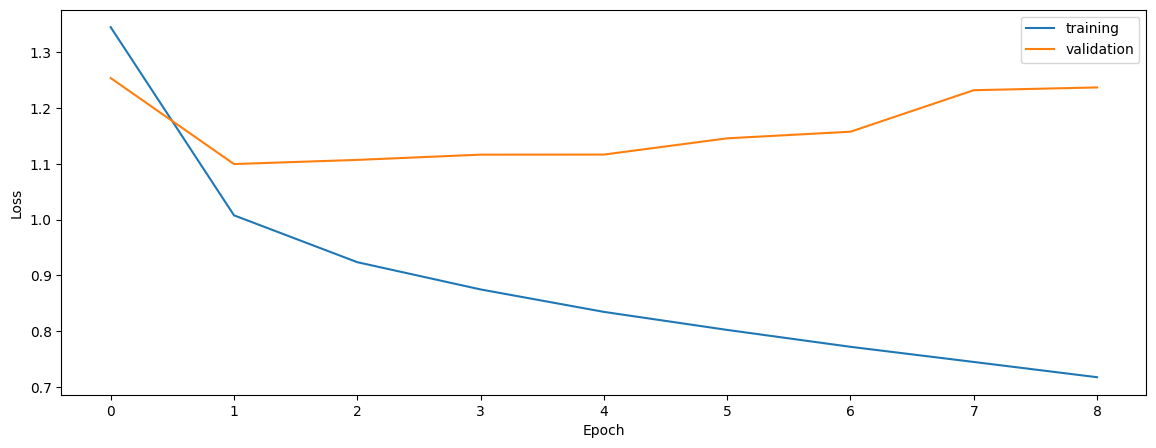

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6232146158724234
0.5714492734954658
0.6104921715975574


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5427429545007302
0.5285141434892541
0.5075438880349487


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5357223127060903
0.5361814488828707
0.5093276352645506


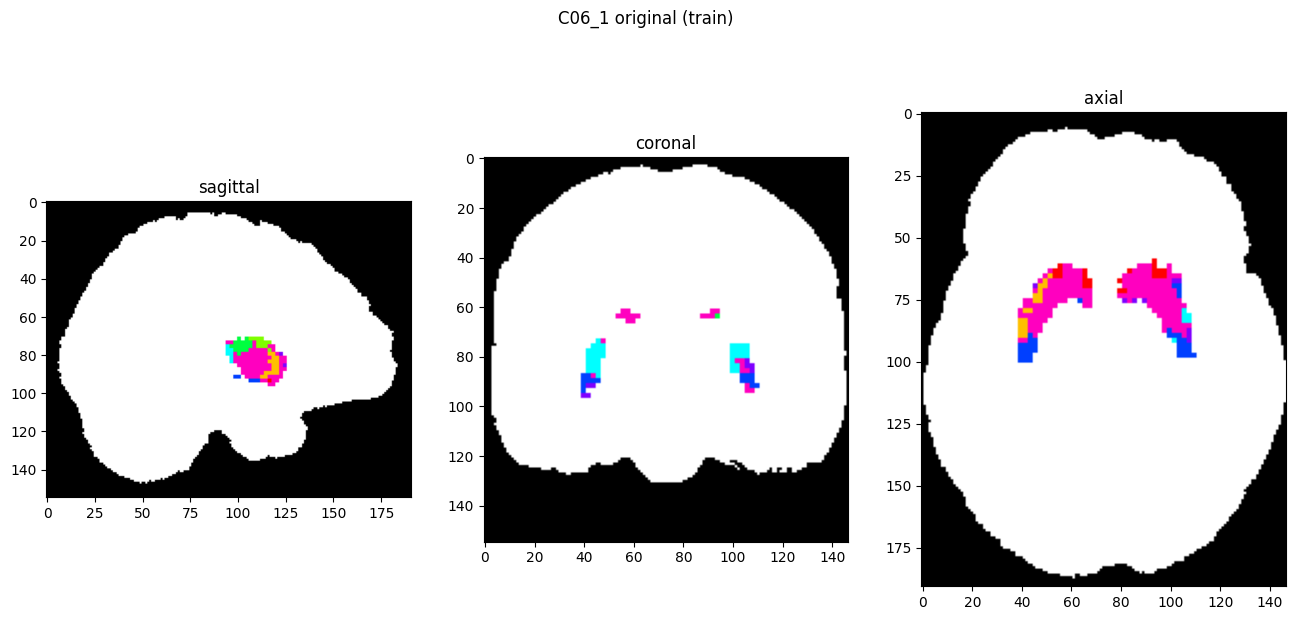

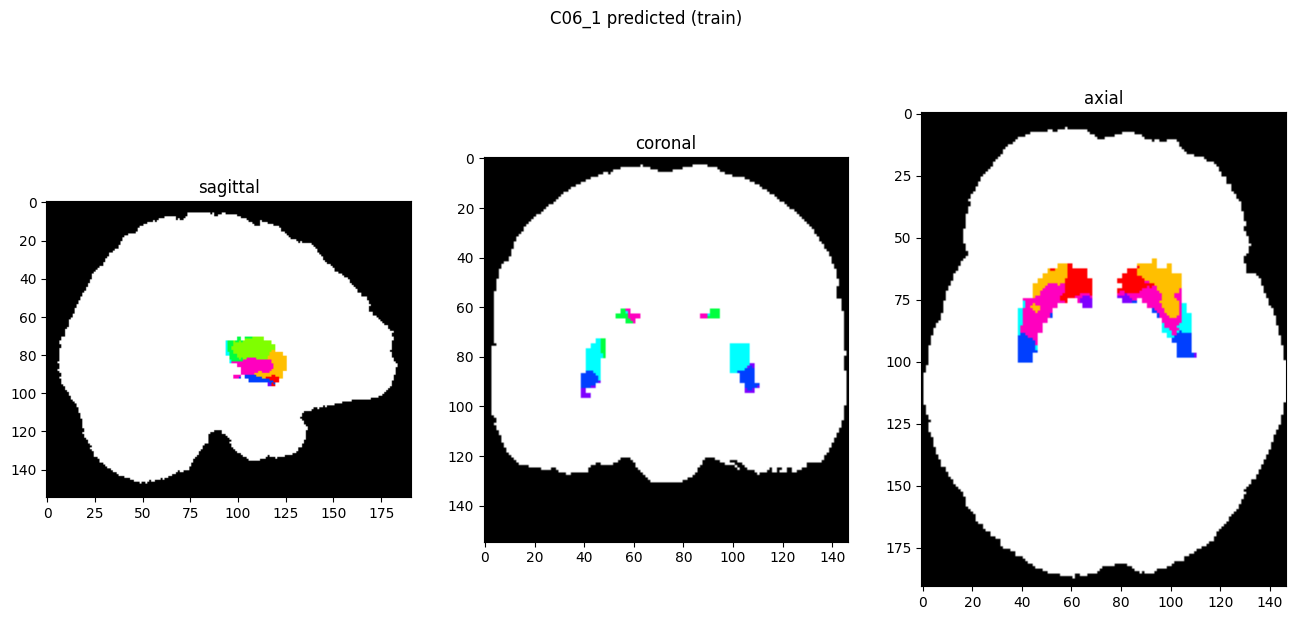

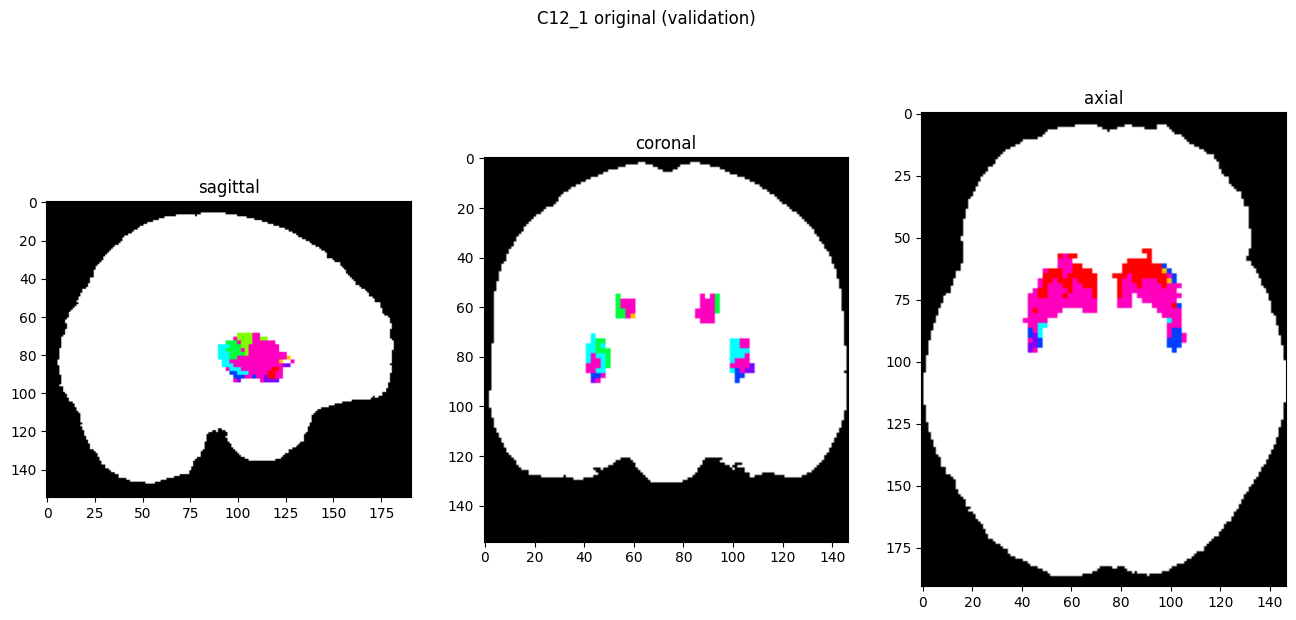

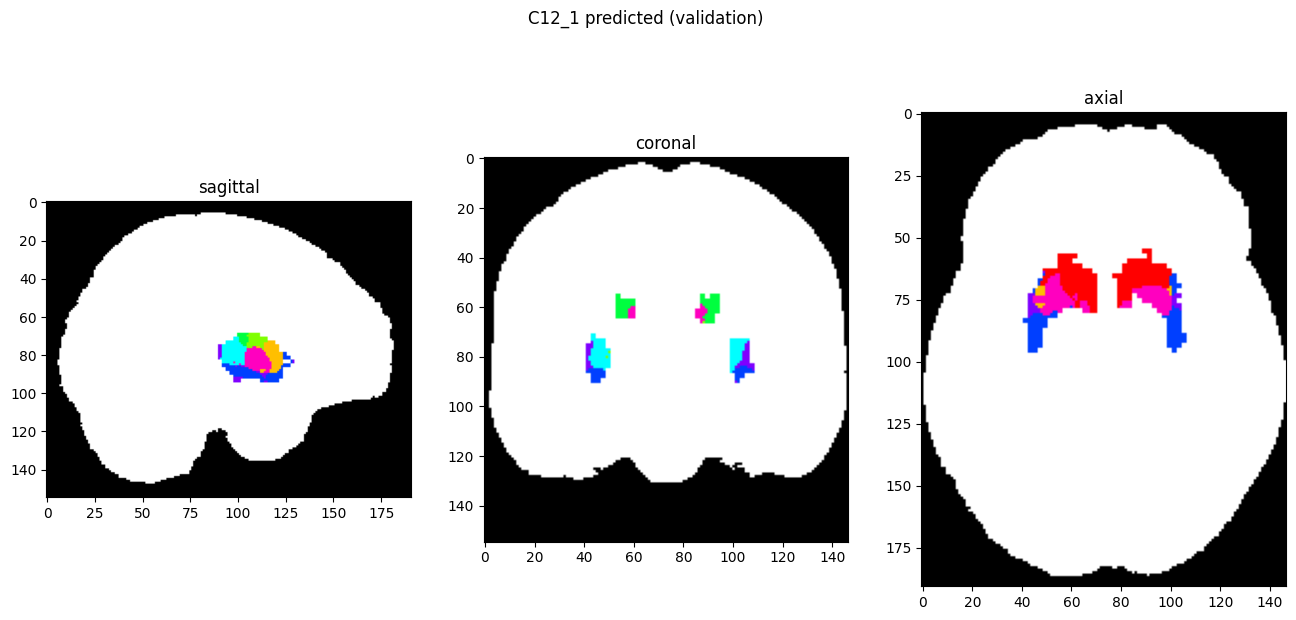

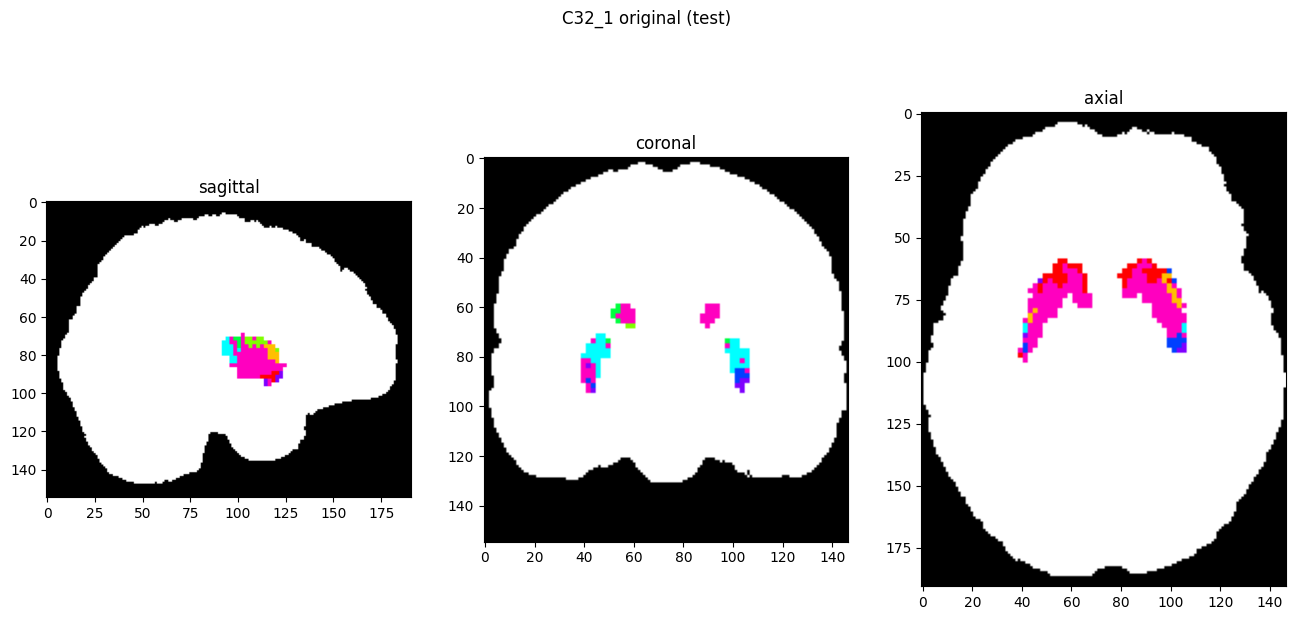

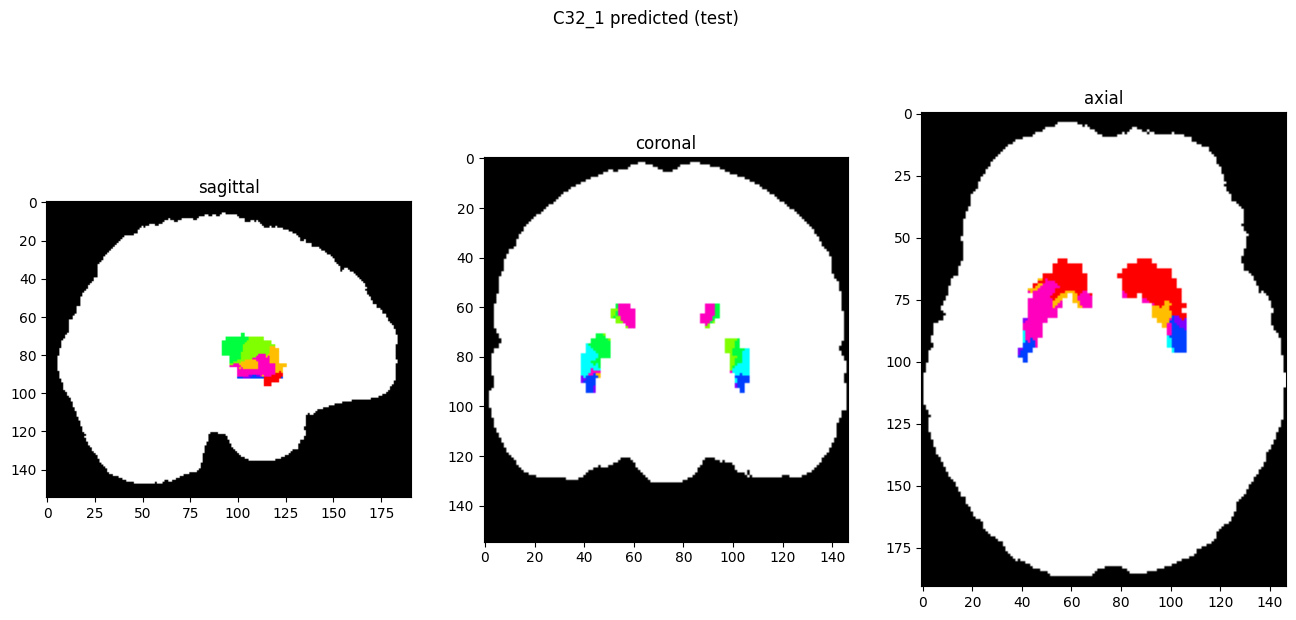

In [10]:
showResults(model, gen, threshold=0)